# Телеком

## Описание проекта


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов:
  - через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия»)
  - оптоволоконный кабель (англ. fiber optic).
- Интернет-безопасность:
   - антивирус (Device Protection)
   - блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV)
- каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.
Информация о договорах актуальна на 1 февраля 2020.

Данная задача прогнозирования оттока пользователей является задачей бинарной классификации.
Для решения задачи нам необходимо подготовить данные:
- Загрузить все таблицы из базы даных с помощью подключения sql
- проанализировать таблицы на предмет полноты, пропусков
- объединить все таблицы
- проанализировать признаки на информативность
- Подготовить признаки для машинного обучения (перевести категориальные признаки в числовые, масштабировать числовые признаки).

**Машинное обучение**

Нам необходимо оптимизировать метрику auc score, которая согласно заданию на проект должна достигать минимального значения 0.85.

В задании имеется требование к используемым моделям, так, нам необходимо использовать модели основанные на алгоритме решающего дерева и градиентного бустинга, а также нейронную сеть.

Поэтому я буду использовать
- RandomForest
- CatBoost
- LightGbm
- Полносвязную нейронную сеть с дропаут.

Для моделей RandomForest, CatBoost, LightGbm будем подбирать гиперпараметры с помощью фреймворка Оптуна и grid_search_cv.



## Импорты и загрузка данных

In [ ]:
import pandas as pd
!pip install -- upgrade pandas

import numpy as np
import datetime
import time
from itertools import product

import warnings# мы будем игнорировать warnings
warnings.filterwarnings(action = 'ignore', category = Warning)

from tqdm.autonotebook import tqdm
tqdm.pandas()

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import matplotlib
matplotlib.rcParams['font.size'] = 13
!python3 -mpip install matplotlib -q

# sklearn

from sklearn.metrics import ( ConfusionMatrixDisplay,
                             precision_recall_curve,
                              PrecisionRecallDisplay,
                              RocCurveDisplay)

from sklearn.metrics import (roc_curve,
                             auc,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             accuracy_score,
                            confusion_matrix)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler

# модельки

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings("ignore")

import torch
#from torch import nn
import  torch.nn  as nn
import torch.optim as optim
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary
!pip install catboost -q
!pip install --upgrade catboost -q
import catboost
from catboost import  Pool, CatBoostClassifier

!pip install lightgbm -q
import lightgbm as lgb

!pip install optuna -q
import optuna

# только для этой версии работает подключение
!pip install SQLAlchemy==1.4.25

# Import necessary libraries
from sqlalchemy import create_engine

%pip install --upgrade matplotlib -q

!pip install phik -q
import phik

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# зафиксируем параметр случайности
RANDOM_STATE = 11122023
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
}

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

**Проверяем наличие и содержание таблиц**

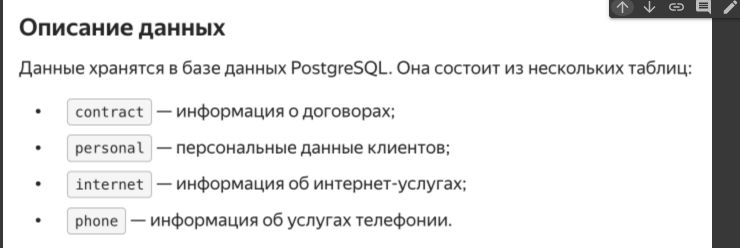

#### contract

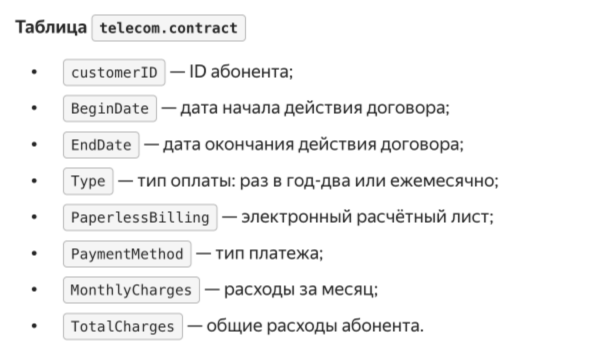

In [ ]:
# проверим
query = '''
SELECT *
FROM telecom.contract;
'''
example = pd.read_sql_query(query, con = engine)
example.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Все столбцы имеются

#### personal

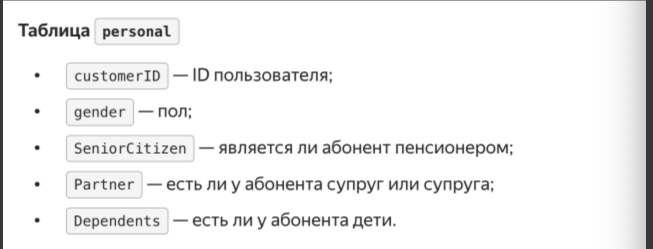

In [ ]:
# сохраним датасет
query = '''
SELECT *
FROM telecom.personal;
'''
example = pd.read_sql_query(query, con = engine)
example.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
4379,7691-XVTZH,Female,0,Yes,No
3880,9470-RTWDV,Male,0,Yes,Yes
4225,5345-BMKWB,Male,0,Yes,No
2908,7780-OTDSO,Male,0,Yes,No
1872,9938-PRCVK,Female,0,Yes,Yes


In [ ]:
example.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### internet

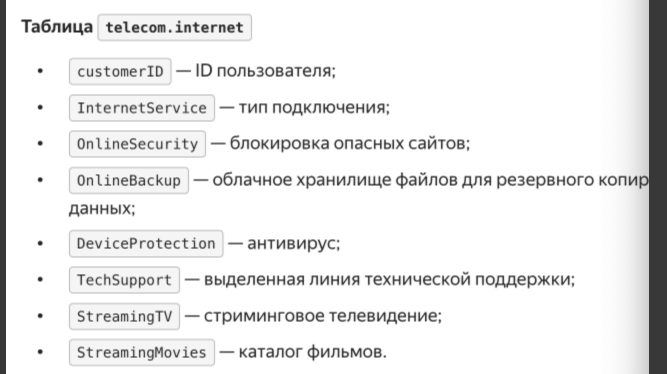

In [ ]:
# сохраним датасет
query = '''
SELECT *
FROM telecom.internet
;
'''
example = pd.read_sql_query(query, con = engine)
example.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


В этом датасете на 1525 наблюдений меньше чем в других

Названия столбцов съехали вниз и теперь они отображены как значения.
- Можно либо объединить это так, имея в виду что с1 это 	customerID

#### phone

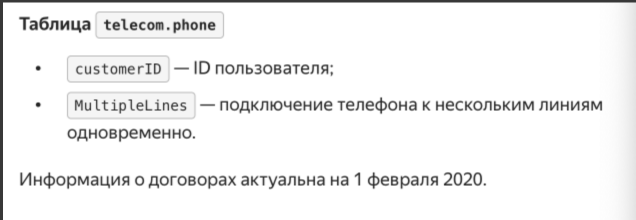

In [ ]:
# сохраним датасет
query = '''
SELECT *
FROM telecom.phone;
'''
example = pd.read_sql_query(query, con = engine)
example.head(5)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


в данной таблице так же названия съехали вниз и количество объектов не совппадает с предыдущими

In [ ]:
example['c1'].duplicated().sum()

0

### **Создаем датасет**

- Все таблицы имеют общий столбец customerID, кроме таблиц internet и phone,
- в данных содержится разное количество объектов поэтому объединять будем так чтобы в общую таблицу попали объекты которые есть во всех таблицах

In [ ]:
query = '''
SELECT *
FROM telecom.contract as tc

LEFT JOIN telecom.personal AS tp ON tc."customerID" = tp."customerID"

LEFT JOIN telecom.internet AS ti ON tc."customerID" = ti."c1"

LEFT JOIN telecom.phone AS tph ON tc."customerID" = tph."c1";
'''

data = pd.read_sql_query(query, con = engine)
data.head(5)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customerID,gender,...,c1,c2,c3,c4,c5,c6,c7,c8,c1,c2
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,4472-LVYGI,Female,...,4472-LVYGI,DSL,Yes,No,Yes,Yes,Yes,No,None,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,3115-CZMZD,Male,...,None,None,None,None,None,None,None,None,3115-CZMZD,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,3668-QPYBK,Male,...,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,3668-QPYBK,No
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,5709-LVOEQ,Female,...,5709-LVOEQ,DSL,Yes,Yes,Yes,No,Yes,Yes,5709-LVOEQ,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9237-HQITU,Female,...,9237-HQITU,Fiber optic,No,No,No,No,No,No,9237-HQITU,No


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   customerID        7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  c1                5517 non-null   object 
 14  c2                5517 non-null   object 
 15  c3                5517 non-null   object 
 16  c4                5517 non-null   object 


<a name = correction1></n>

- В данных имееюся пропуски.
- Названия признаков записаны в camel формате, необходимо заменить на snacke_case для удобства
- имеются признаки с неинформативными названиями (с1, с2 и тд)
- в итоговый датасет вошли все объекты

In [ ]:
# 1 таблицу мы присоединили internet, поэтому сохраним названия
internet = ['customerID', 'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies']


In [ ]:
# 2 таблицу мы присоединили phone, поэтому сохраним названия
phone = ['customerID', 'MultipleLines']


In [ ]:
# сохраним список названий признаков
columns = data.columns.to_list()


In [ ]:
# привидем к строчному регистру
new_columns = (columns + internet + phone)

list(map(lambda x: x.lower(), new_columns))

['customerid',
 'begindate',
 'enddate',
 'type',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'customerid',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c1',
 'c2',
 'customerid',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'customerid',
 'multiplelines']

In [ ]:
# добавим разделитель и отметим дублирующиеся
columns = [
    'customer_id',
    'begin_date',
    'end_date',
    'type',
    'paperless_billing',
    'payment_method',
    'monthly_charges',
    'total_charges',
    'customer_id1',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'customer_id2',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'customer_id3',
    'multiple_lines']

In [ ]:
# сохраним новые названия признаков
data.columns = columns
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,customer_id1,gender,...,customer_id2,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,customer_id3,multiple_lines
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,4472-LVYGI,Female,...,4472-LVYGI,DSL,Yes,No,Yes,Yes,Yes,No,None,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,3115-CZMZD,Male,...,None,None,None,None,None,None,None,None,3115-CZMZD,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,3668-QPYBK,Male,...,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,3668-QPYBK,No
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,5709-LVOEQ,Female,...,5709-LVOEQ,DSL,Yes,Yes,Yes,No,Yes,Yes,5709-LVOEQ,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9237-HQITU,Female,...,9237-HQITU,Fiber optic,No,No,No,No,No,No,9237-HQITU,No


In [ ]:
# удалим  признаки связанные с id клиентов
data.drop(['customer_id', 'customer_id1', 'customer_id2', 'customer_id3'], axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           1869 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7032 non-null   float64
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv       5517 

Исходные данные имеют размерность 7043 объекта объекта, 19 признаков.

- данные имеют пропуски
- названия признаков перезаписаны в snake_case (изначально были в camel case)
- имеются категориальные и числовые признаки
- вероятно булев тип значений представлен в виде категорий.

## Исследовательский анализ и предобработка данных

##### Типы данных

In [ ]:
# оценим типы данных
data.dtypes

begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
gender                object
senior_citizen         int64
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
dtype: object

- begin_date, object нужно перевести в
pd.datetime
- end_date (object) нужно перевести в
pd.datetime

In [ ]:
# заменим на тип данных date
data[['begin_date', 'end_date']] = data[['begin_date', 'end_date']]\
       .apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d', errors = 'coerce'))


In [ ]:
data[['begin_date', 'end_date']]

,begin_date,end_date
0,2020-02-01,NaT
1,2020-02-01,NaT
2,2018-08-09,2019-12-01
3,2020-02-01,NaT
4,2019-01-26,2019-11-01
...,...,...
7038,2019-01-21,NaT
7039,2019-02-26,NaT
7040,2019-09-02,NaT
7041,2019-06-26,NaT


##### Дупликаты

In [ ]:
# проверим дупликаты
data.duplicated(keep = False).sum()

0

Дупликатов нет

##### Пропуски

In [ ]:
# отобразим пропущенные значения
data.isna().sum()

begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

- В признаке total_charges пропусков совсем незначительное количество, что очевидно связано с тем, что это новые клиенты
- в признаке end_date это очевидно объекты для которых нет такой даты
- в признаках характеризующих услуги пропущенные значения означают то что клиент не пользуюется этими услугами и у него они не подключены (internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines) поэтому заменяем 0

In [ ]:
# оценим объекты с пропусками
data.loc[data['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,None
1,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,None,None,None,None,None,None,None,No
3,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
6,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,Yes
7,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,None
9,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,Yes
10,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,No
11,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes
4408,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,No
5160,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,None,None,None,None,None,None,None,No


Для клиентов кто только начал пользоваться услугами компании (так как база заканачивается февралем 20 года)total_charges обратился в Nan, заменим на значение 0, так как вероятнее всего это рассчитывается как произведение периода на сумму месячных затрат и ставить на место этих пропусков значение из признакак monthly_charges может не соответствовать логике



In [ ]:
#  заполняем 0
data.loc[data['total_charges'].isna(), 'total_charges'] = 0

In [ ]:
data[['internet_service',
      'online_security',
      'online_backup',
      'device_protection',
      'tech_support',
      'streaming_tv',
      'streaming_movies',
      'multiple_lines']]

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,DSL,Yes,No,Yes,Yes,Yes,No,None
1,None,None,None,None,None,None,None,No
2,DSL,Yes,Yes,No,No,No,No,No
3,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
7038,None,None,None,None,None,None,None,No
7039,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,DSL,Yes,No,No,No,No,No,None


In [ ]:
# заменим на NO
data[['internet_service',
      'online_security',
      'online_backup',
      'device_protection',
      'tech_support',
      'streaming_tv',
      'streaming_movies',
      'multiple_lines']]

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,DSL,Yes,No,Yes,Yes,Yes,No,None
1,None,None,None,None,None,None,None,No
2,DSL,Yes,Yes,No,No,No,No,No
3,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
7038,None,None,None,None,None,None,None,No
7039,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,DSL,Yes,No,No,No,No,No,None


In [ ]:
for col in ['internet_service',
            'online_security',
            'online_backup',
            'device_protection',
            'tech_support',
            'streaming_tv',
            'streaming_movies',
            'multiple_lines']:
    data.loc[data[col].isna(), col] = \
    data.loc[data[col].isna(), col].fillna('No')

    print (f'''Количество пропущенных значений в {col}: {data[col].isna().sum()}''')

Количество пропущенных значений в internet_service: 0
Количество пропущенных значений в online_security: 0
Количество пропущенных значений в online_backup: 0
Количество пропущенных значений в device_protection: 0
Количество пропущенных значений в tech_support: 0
Количество пропущенных значений в streaming_tv: 0
Количество пропущенных значений в streaming_movies: 0
Количество пропущенных значений в multiple_lines: 0


In [ ]:
# проверяем
data.isna().sum()

begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

Проанализируем целевой признак

In [ ]:
# создадим новый признак churn на основе end_date
data['churn'] = 1
data.loc[data['end_date'].isna(), 'churn'] = 0
data[['end_date', 'churn']]

,end_date,churn
0,NaT,0
1,NaT,0
2,2019-12-01,1
3,NaT,0
4,2019-11-01,1
...,...,...
7038,NaT,0
7039,NaT,0
7040,NaT,0
7041,NaT,0


Далее будем анализировать отдельно категориальные и отдельно числовые, для этого создадим функцию для отбора признаков по типу

In [ ]:
# добавим функцию для выделения типа признаков

#отбирает категориальные
def is_categorical(data):
    return data.select_dtypes(include = 'object').columns.to_list()

#отбирает числовые
def is_numeric(data):
    return data.select_dtypes(exclude = 'object').columns.to_list()

#### Анализ категориальных

In [ ]:
# создаем список категориальных
categorical = is_categorical(data)

In [ ]:
# оценим что содержат в себе эти данные
data[categorical].head()

,type,paperless_billing,payment_method,gender,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Two year,Yes,Bank transfer (automatic),Female,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
1,Two year,No,Mailed check,Male,No,Yes,No,No,No,No,No,No,No,No
2,Month-to-month,Yes,Mailed check,Male,No,No,DSL,Yes,Yes,No,No,No,No,No
3,Two year,No,Mailed check,Female,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,Month-to-month,Yes,Electronic check,Female,No,No,Fiber optic,No,No,No,No,No,No,No


Много признаков вероятнее всего имеют булев тип. Такие признаки переведем в числовые, для удобства анализа. Для этого мы сохраним их в список to_bool с помощью цикла.
Отбирать будем по условию, что содержит всего 2 уникальных значения

In [ ]:
is_bool = []
# найдем булевы типы
for col in categorical:
    if data[col].nunique() == 2:
        is_bool.append(col)
# выведем получившийся список
is_bool

['paperless_billing',
 'gender',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

Признаки отобраны, теперь проанализируем их и затем изменим тип данных на числовой.

In [ ]:
# сгруппируем по целевому признаку
for col in is_bool:
    print(data.groupby(col)['churn'].mean())
    print()


paperless_billing
No     0.163301
Yes    0.335651
Name: churn, dtype: float64

gender
Female    0.269209
Male      0.261603
Name: churn, dtype: float64

partner
No     0.329580
Yes    0.196649
Name: churn, dtype: float64

dependents
No     0.312791
Yes    0.154502
Name: churn, dtype: float64

online_security
No     0.313296
Yes    0.146112
Name: churn, dtype: float64

online_backup
No     0.291721
Yes    0.215315
Name: churn, dtype: float64

device_protection
No     0.286518
Yes    0.225021
Name: churn, dtype: float64

tech_support
No     0.311862
Yes    0.151663
Name: churn, dtype: float64

streaming_tv
No     0.243312
Yes    0.300702
Name: churn, dtype: float64

streaming_movies
No     0.243795
Yes    0.299414
Name: churn, dtype: float64

multiple_lines
No     0.250246
Yes    0.286099
Name: churn, dtype: float64



In [ ]:
# преобразуем признаки internet_service и gender с помощью dummy
data = pd.get_dummies(data,
                      columns = ['internet_service', 'gender'],
                      drop_first = False)
data.head()


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,...,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,internet_service_DSL,internet_service_Fiber optic,internet_service_No,gender_Female,gender_Male
0,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Yes,Yes,...,Yes,Yes,No,No,0,1,0,0,1,0
1,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.00,0,No,Yes,...,No,No,No,No,0,0,0,1,0,1
2,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,No,No,...,No,No,No,No,1,1,0,0,0,1
3,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.00,0,Yes,Yes,...,No,Yes,Yes,No,0,1,0,0,1,0
4,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,No,No,...,No,No,No,No,1,0,1,0,1,0


In [ ]:
# Приведем к типу 0/1 для удобства анализа
data[['internet_service_DSL', 'internet_service_Fiber optic', 'gender_Female','gender_Male']] = \
data[['internet_service_DSL', 'internet_service_Fiber optic', 'gender_Female','gender_Male']].astype('int')

In [ ]:
# пересоберем
is_bool = []

# найдем булевы типы
for col in is_categorical(data):
    if data[col].nunique() == 2:
        is_bool.append(col)
# выведем получившийся список
is_bool

['paperless_billing',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

Теперь можно заменить на 0 и 1 оставшиеся признаки

In [ ]:
# заменим значения yes/no на 0 и 1
data[is_bool] = data[is_bool].applymap(lambda x: 1 if (x == 'Yes') else 0)

In [ ]:
data[is_bool]

,paperless_billing,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,1,1,1,1,0,1,1,1,0,0
1,0,0,1,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0
3,0,1,1,1,1,1,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,0,0,0,0,0,0
7039,1,1,1,1,0,1,1,1,1,1
7040,1,1,1,0,1,1,0,1,1,1
7041,1,1,1,1,0,0,0,0,0,0


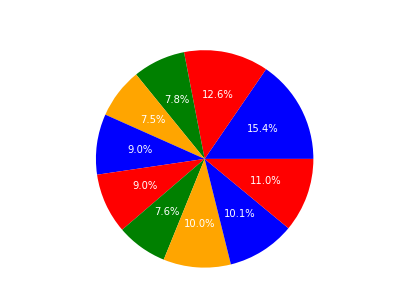

In [ ]:
#Визуализируем булевые признаки на круговой диаграмме
colors = ['blue', 'red', 'green', 'orange']
count_true = [data[col].sum() for col in is_bool]# считаем единицы

#  круговая диаграмма для булевых признаков
plt.figure(figsize = (5,5))
plt.pie(count_true,
        autopct = "%1.1f%%",
        labels = is_bool,
        colors = colors)

plt.title('Распределение булевых признаков на обучающих данных')
plt.show()

Видим, что признаки несбалансированы, нужно будет разделять выборки с учетом дисбаланса

In [ ]:
# оценим оставшиеся категориальные признаки
data[is_categorical(data)]

,type,payment_method
0,Two year,Bank transfer (automatic)
1,Two year,Mailed check
2,Month-to-month,Mailed check
3,Two year,Mailed check
4,Month-to-month,Electronic check
...,...,...
7038,Two year,Bank transfer (automatic)
7039,One year,Mailed check
7040,One year,Credit card (automatic)
7041,Month-to-month,Electronic check


In [ ]:
# оценим уникальные в оставшихся признаках
print(data[is_categorical(data)].nunique())

type              3
payment_method    4
dtype: int64


In [ ]:
type_pivot = pd.pivot_table(data[['type', 'churn']],
               columns = 'type',
               index = 'churn',
               aggfunc = 'size')
type_pivot

type,Month-to-month,One year,Two year
churn,,,
0,2220,1307,1647
1,1655,166,48


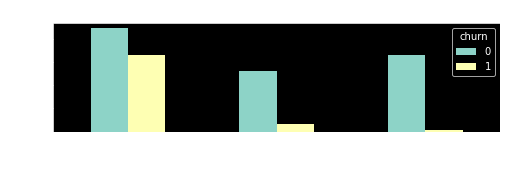

In [ ]:
# Построим столбчатые диаграммы
fig, ax = plt.subplots(figsize=(8, 2))

type_pivot.T.plot(kind = 'bar', stacked = False, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)  # Поворачиваем подписи оси x
ax.set_title('Churn Distribution by Payment Method')
ax.set_ylabel('Count')
ax.set_xlabel('Churn')

plt.show()

Видим что самый высокий уровень оттока для клиентов кто оплачивает счет по факту (month to month), по сравнению с теми кто платит авансом

In [ ]:
# сгруппируем данные по способу платежа
method_pivot = pd.pivot_table(data[['payment_method', 'churn']],
               columns = 'payment_method',
               index = 'churn',
               aggfunc = 'size')
method_pivot

payment_method,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
0,1286,1290,1294,1304
1,258,232,1071,308


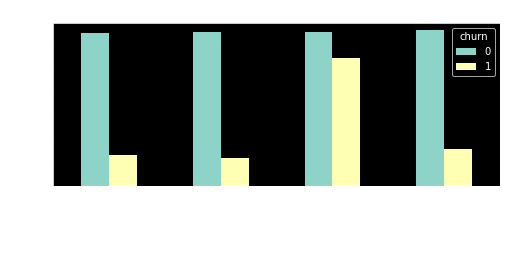

In [ ]:
# Построим столбчатые диаграммы
fig, ax = plt.subplots(figsize=(8, 3))

method_pivot.T.plot(kind = 'bar', stacked = False, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -15)  # Поворачиваем подписи оси x
ax.set_title('Churn Distribution by Payment Method')
ax.set_ylabel('Count')
ax.set_xlabel('Churn')

plt.show()

Видим что почти для всех категорий уровень оттока клиентов одинаковый, только в категории electronic check примерно одинаковый уровень оттока, что учитывая дисбаланс классов говорит о том, что чаще уходят клиенты, c типом оплаты electronic check

In [ ]:
is_categorical(data)

['type', 'payment_method']

Категориальных признаков осталось всего 2: type, payment_method. Они включают в себя 3 и 4 уникальных категорий соответственно, кодировать их в числовые будем далее, после разбиения выборки.

### Анализ числовых

In [ ]:
is_numeric(data)

['begin_date',
 'end_date',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'churn',
 'internet_service_DSL',
 'internet_service_Fiber optic',
 'internet_service_No',
 'gender_Female',
 'gender_Male']

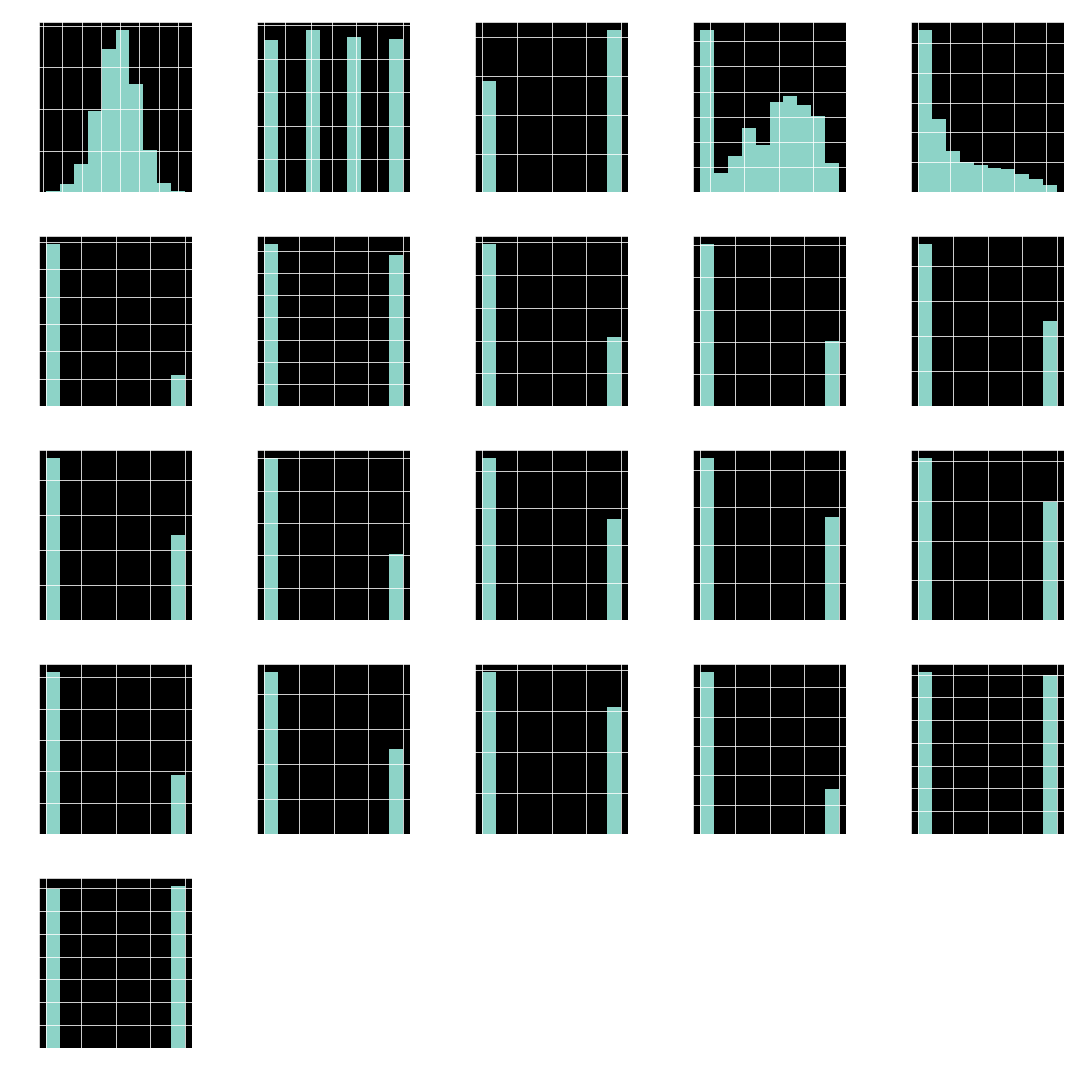

In [ ]:
# отобразим все числовые на графиках

data[is_numeric(data)].hist(figsize = (15, 15))

plt.tight_layout();

Видим, что:
- почти все числовые признаки представлены в виде бинарных значений.
- 2 признака представлены в виде даты
- 2 признака это непрерывные пременные отржажающие сумму трат помесячно и годовое значение суммы трат.
Учитывая что для бинарных переменных мы можем оценить только сбалансированность, будем анализировать оставшиеся признаки на выбросы.
Так же необходимо проверить наличие линейной зависимости с целевой переменной в данных.

In [ ]:
# отобразим диапазон дат для признака begin_date
print(f'''
Самая ранняя дата договора: {data[['begin_date']].min()}

Самая поздняя дата договора: {data[['begin_date']].max()}''')


Самая ранняя дата договора: begin_date   2018-04-17
dtype: datetime64[ns]

Самая поздняя дата договора: begin_date   2020-02-01
dtype: datetime64[ns]


In [ ]:
 data['end_date'] - data['begin_date']

0           NaT
1           NaT
2      479 days
3           NaT
4      279 days
         ...   
7038        NaT
7039        NaT
7040        NaT
7041        NaT
7042        NaT
Length: 7043, dtype: timedelta64[ns]

In [ ]:
# заменим пропуски последней датой актуализации базы
data.loc[data['end_date'].isna(), 'end_date'] = \
data.loc[data['end_date'].isna(), 'end_date'].fillna('2020-02-01')

In [ ]:
# заменим на тип данных date
data[['end_date']] = data[['end_date']]\
       .apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d', errors = 'coerce'))


In [ ]:
# добавим новый признак
data['client_period'] =  (data['end_date'] - data['begin_date']).dt.days
data['client_period'].head()

0      0
1      0
2    479
3      0
4    279
Name: client_period, dtype: int64

На основе признака  end_date и begin_date  мы создали новые признаки:
-  целевой признак
- продолжительность жизни клиента в днях.
Поэтому  мы удалим признаки с датой


In [ ]:
data.drop(['begin_date', 'end_date'], axis = 1, inplace = True)

Посмотрим на значения в признаках 'monthly_charges, 'total_charges' чтобы выяснить не являются ли они дублирующими или линейно зависимыми

In [ ]:
data[['monthly_charges', 'total_charges']]

,monthly_charges,total_charges
0,52.55,0.00
1,20.25,0.00
2,53.85,108.15
3,80.85,0.00
4,70.70,151.65
...,...,...
7038,21.15,1419.40
7039,84.80,1990.50
7040,103.20,7362.90
7041,29.60,346.45


In [ ]:
# проверим можно ли получить признак total_charges умножив период на сумму месячных расходов
np.allclose(np.array(data['total_charges']), \
            np.array((data['monthly_charges'] * data['client_period']/30)))


False

<a name = correction2></n>

In [ ]:
# оценим корреляцию
corr = data.phik_matrix()

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'churn', 'internet_service_DSL', 'internet_service_Fiber optic', 'internet_service_No', 'gender_Female', 'gender_Male', 'client_period']


In [ ]:
corr

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,...,streaming_tv,streaming_movies,multiple_lines,churn,internet_service_DSL,internet_service_Fiber optic,internet_service_No,gender_Female,gender_Male,client_period
type,1.000000,0.106860,0.277462,0.388444,0.505826,0.086231,0.179736,0.147680,0.152145,0.098884,...,0.066961,0.069608,0.065498,0.251639,0.038773,0.154779,0.146647,0.000000,0.000000,0.037860
paperless_billing,0.106860,1.000000,0.370495,0.467812,0.207127,0.242133,0.013218,0.172593,0.000000,0.196443,...,0.343524,0.325551,0.252972,0.295754,0.096737,0.490496,0.482393,0.000000,0.000000,0.050069
payment_method,0.277462,0.370495,1.000000,0.399526,0.350566,0.292725,0.243008,0.224903,0.262911,0.282475,...,0.377209,0.378907,0.339313,0.449125,0.156446,0.564511,0.535120,0.000000,0.000000,0.000868
monthly_charges,0.388444,0.467812,0.399526,1.000000,0.762839,0.304985,0.203545,0.184366,0.551621,0.629541,...,0.835340,0.833307,0.675883,0.360050,0.949706,0.971096,0.998690,0.008175,0.008175,0.015962
total_charges,0.505826,0.207127,0.350566,0.762839,1.000000,0.149384,0.424467,0.119077,0.545067,0.653989,...,0.660753,0.666609,0.606117,0.278498,0.279865,0.480968,0.556129,0.000000,0.000000,0.017197
senior_citizen,0.086231,0.242133,0.292725,0.304985,0.149384,1.000000,0.016992,0.324576,0.057028,0.102065,...,0.163120,0.186141,0.221313,0.233432,0.167696,0.389479,0.281853,0.000000,0.000000,0.034522
partner,0.179736,0.013218,0.243008,0.203545,0.424467,0.016992,1.000000,0.652122,0.221673,0.219223,...,0.193258,0.182011,0.220101,0.232930,0.000000,0.000000,0.000000,0.000000,0.000000,0.016432
dependents,0.147680,0.172593,0.224903,0.184366,0.119077,0.324576,0.652122,1.000000,0.124945,0.031533,...,0.017331,0.058999,0.033103,0.253936,0.078923,0.256423,0.216514,0.000000,0.000000,0.035546
online_security,0.152145,0.000000,0.262911,0.551621,0.545067,0.057028,0.221673,0.124945,1.000000,0.430425,...,0.272186,0.289097,0.151886,0.264580,0.482773,0.043885,0.499319,0.018397,0.018397,0.000000
online_backup,0.098884,0.196443,0.282475,0.629541,0.653989,0.102065,0.219223,0.031533,0.430425,1.000000,...,0.428007,0.417170,0.311403,0.126973,0.244322,0.256185,0.563476,0.009882,0.009882,0.032195


Видим, что сильной линейной корреляции целевого признака с другими нет. Самая сильная корреляция это 0.46 для признака internet_service_Fiber optic. Больше всего коррелирует признака monthly_charges с признаками, которые соответствуют услугам клиентов.

**Оцении выбросы и аномалии**

,count,mean,std,min,25%,50%,75%,max
client_period,7043.0,297.378674,83.868181,0.0,242.0,298.0,351.0,583.0


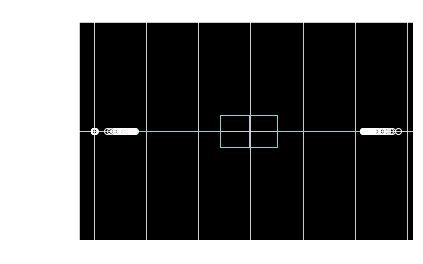

In [ ]:
data[['client_period']].boxplot(vert = False)
plt.title('Boxplot признаков client_period')
data[['client_period']].describe().transpose()

Отрицательных нет, значит с данными все нормально.
Видим что срок жизни клиентов для этой компании не очень велик, клиенты пользующиеся услугами компании дольше полутора лет уже редкость. В среднем люди пользуются их услугами один год

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


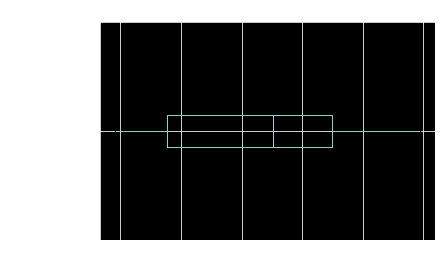

In [ ]:
data[['monthly_charges']].boxplot(vert = False)
plt.title('Boxplot признаков monthly_spending');
data[['monthly_charges']].describe().transpose()

Вообще нет выбросов и редких значений

,count,mean,std,min,25%,50%,75%,max
total_charges,7043.0,2279.734304,2266.79447,0.0,398.55,1394.55,3786.6,8684.8


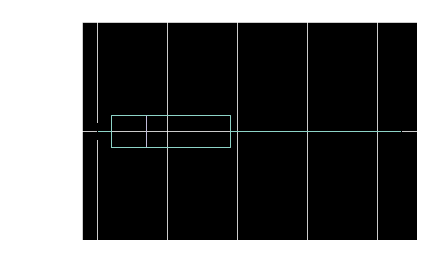

In [ ]:
data[['total_charges']].boxplot(vert = False)
plt.title('Boxplot признака total_charges')
data[['total_charges']].describe().transpose()

Выбросов нет, но есть большой разброс значений, так стандартное отклонение 2415 при среднем 2347 может говорить о том, что потребление услуг очень неравномерно.

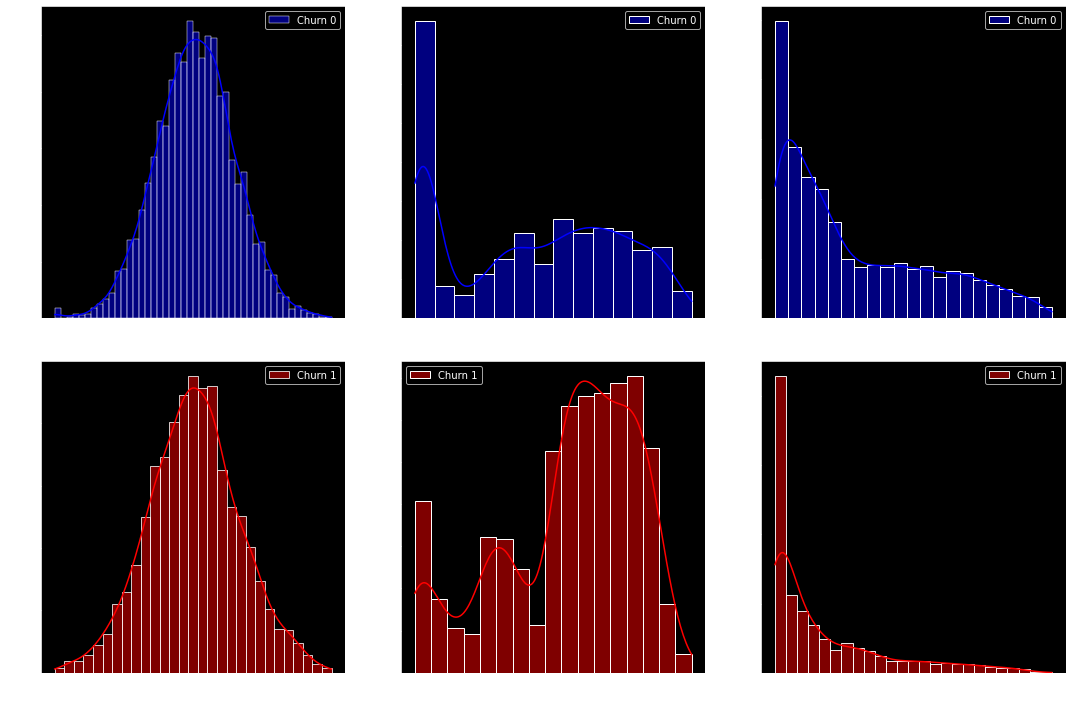

In [ ]:
# Выбираем только строки с churn = 0
to_plot = data[['client_period', 'monthly_charges', 'total_charges', 'churn']]
churn_0 = to_plot[to_plot['churn'] == 0]

# Выбираем только строки с churn = 1
churn_1 = to_plot[to_plot['churn'] == 1]

#
n_rows = 2
n_cols = 3 # Рассматриваем только непрерывные признаки


fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

#  графики для каждого признака
for i, feature in enumerate(['client_period', 'monthly_charges', 'total_charges']):
    # Гистограммы для признака
    sns.histplot(data = churn_0,
                 x = feature,
                 kde=True,
                 ax=axes[0, i],
                 color='blue',
                 label='Churn 0',
                 stat = 'frequency')
    sns.histplot(data = churn_1,
                 x = feature,
                 kde=True,
                 ax=axes[1, i],
                 color='red',
                 label='Churn 1',
                 stat='frequency')
    axes[0, i].legend()
    axes[1, i].legend()

plt.tight_layout()
plt.show()


На графиках видим, что тип распределения меняется для признака 'client_period', основная часть клиентов уходит до 10 месяца, а дальше уменьшается постепенно. После 15 мес клиенты редко уходят.

Те кто ушел значительно больше тратили ежемесячно, что противоречит тем кто остался:те кто остался в большинстве тратят меньше (20$)

А ушедшие клиенты наоборот тратили больше (65-105$)

## Машинное обучение

In [ ]:
is_bool = []
# найдем булевы типы
for col in data.columns:
    if data[col].nunique() == 2:
        is_bool.append(col)
# выведем получившийся список
data[is_bool].mean().sort_values()

senior_citizen                  0.162147
internet_service_No             0.216669
churn                           0.265370
online_security                 0.286668
tech_support                    0.290217
dependents                      0.299588
internet_service_DSL            0.343746
device_protection               0.343888
online_backup                   0.344881
streaming_tv                    0.384353
streaming_movies                0.387903
multiple_lines                  0.421837
internet_service_Fiber optic    0.439585
partner                         0.483033
gender_Female                   0.495244
gender_Male                     0.504756
paperless_billing               0.592219
dtype: float64

Данные несбалансированы по нескольким признакам, senior_citizen, dependents и целевой признак churn. Попробуем разделить выборку по с учетом всех этих признаков

In [ ]:
#разделим выборку
train, test = train_test_split(data,
                                shuffle = True,
                                stratify = data[['churn', 'senior_citizen', 'dependents']],
                                test_size = 0.25,
                                random_state = RANDOM_STATE)


print (f'''
Размер обучающей выборки {train.shape}

Размер тестовой выборки {test.shape}

''')


Размер обучающей выборки (5282, 22)

Размер тестовой выборки (1761, 22)




<a name = correction3></n>

**Кодирование категориальных**

In [ ]:
train[is_categorical(train)].columns

Index(['type', 'payment_method'], dtype='object')

In [ ]:
# Рассчитаем среднее значение таргета для каждой категории на train
mean_type_map = train.groupby(['type'])['churn'].mean()
mean_type_map

type
Month-to-month    0.429318
One year          0.115282
Two year          0.030209
Name: churn, dtype: float64

In [ ]:
# кодируем
train['type_enc'] = train['type'].map(mean_type_map)
# проверяем
train[['type','type_enc']].sample(5)

,type,type_enc
6625,One year,0.115282
6057,Two year,0.030209
1931,Month-to-month,0.429318
5814,Month-to-month,0.429318
3269,Month-to-month,0.429318


In [ ]:
# Рассчитаем среднее значение таргета для каждой категории на train
# в признаке payment_method
mean_method_map = train.groupby(['payment_method'])['churn'].mean()
mean_method_map

payment_method
Bank transfer (automatic)    0.169257
Credit card (automatic)      0.150732
Electronic check             0.450000
Mailed check                 0.201962
Name: churn, dtype: float64

In [ ]:
# кодируем
train['payment_method_enc'] = train['payment_method'].map(mean_method_map)
# проверяем
train[['payment_method_enc','payment_method']].sample(5)

,payment_method_enc,payment_method
1603,0.450000,Electronic check
5958,0.450000,Electronic check
5724,0.201962,Mailed check
6408,0.450000,Electronic check
3626,0.450000,Electronic check


In [ ]:
# Заменяем значения в test средними значениями из train

test['payment_method_enc'] = test['payment_method'].map(mean_method_map)
test['type_enc'] = test['type'].map(mean_type_map)

In [ ]:
# удаляем исходные признаки
train.drop(['type', 'payment_method'], axis = 1, inplace = True)
test.drop(['type', 'payment_method'], axis = 1, inplace = True)

<a name = correction4></n>

**Масштабируем признаки**

In [ ]:
# выделим обучающие и целевые признаки
X = train.drop('churn', axis = 1).columns.to_list()
y = 'churn'

In [ ]:
# инициируем скалер
scaler = StandardScaler()

In [ ]:
#Масштабируем признаки
train[X] = scaler.fit_transform(train[X])
test[X] = scaler.transform(test[X])

train[X].head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,streaming_movies,multiple_lines,internet_service_DSL,internet_service_Fiber optic,internet_service_No,gender_Female,gender_Male,client_period,type_enc,payment_method_enc
6243,-1.186370,-1.027686,-0.762878,-0.439776,-0.978275,-0.653887,1.567420,-0.719897,1.370574,-0.644459,...,-0.789451,-0.858445,1.392603,-0.884337,-0.532538,-0.991329,0.991329,0.509443,0.904539,-0.484266
6736,-1.186370,-1.497489,-0.583775,-0.439776,1.022208,1.529317,-0.637991,-0.719897,-0.729621,-0.644459,...,-0.789451,-0.858445,-0.718080,-0.884337,1.877801,1.008747,-1.008747,0.235312,-1.295701,-0.876331
326,0.842907,0.856491,-0.002110,-0.439776,-0.978275,-0.653887,-0.637991,1.389087,-0.729621,-0.644459,...,-0.789451,1.164896,-0.718080,1.130791,-0.532538,-0.991329,0.991329,0.998110,0.904539,-0.876331
1426,0.842907,0.471053,0.070532,-0.439776,1.022208,-0.653887,-0.637991,-0.719897,1.370574,-0.644459,...,-0.789451,1.164896,-0.718080,1.130791,-0.532538,-0.991329,0.991329,0.509443,0.904539,1.413963
1636,0.842907,1.308098,1.440985,2.273887,1.022208,-0.653887,1.567420,-0.719897,1.370574,-0.644459,...,1.266703,1.164896,-0.718080,1.130791,-0.532538,-0.991329,0.991329,0.664386,0.904539,1.413963


Признаки для машинного обучения готовы, можно обучать модель.

In [ ]:
# Сохраним списки для сбора результатов работы моделей
auc_scores = []
models = []

In [ ]:
#функция для визуализации матрицы ошибок
def ConfMatrix(model):
    model_name = model.__class__.__name__
    pred = model.predict(train[X])
    cm = confusion_matrix(train[y], pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = model.classes_)
    disp.plot()

    plt.show()

In [ ]:
#функция для визуализации roc_auc
def AucDisp(fitted_model):
    model = fitted_model

    model_name = model.__class__.__name__
    pred = model.predict(train[X])
    fpr, tpr, thresholds = roc_curve(train[y], pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr,
                              tpr=tpr,
                              roc_auc = roc_auc,
                              estimator_name = model_name)

    display.plot()
    plt.show()

### RandomForestClassifier

In [ ]:
# инициируем модель случайного леса
random_forest = RandomForestClassifier(random_state = RANDOM_STATE)
random_forest.fit(train[X], train[y])

RandomForestClassifier(random_state=11122023)

In [ ]:
# предсказания на дефолтных параметрах

scores = cross_val_score(random_forest,
                         train[X],
                         train[y],
                         cv = 5,
                         scoring = 'roc_auc')

score_RandomForest = scores.mean()

print (f'''
Среднее значение roc_auc для модели RandomForest: {score_RandomForest:0.4f}''')


Среднее значение roc_auc для модели RandomForest: 0.8264


Получили неплохое значение на дефолтных параметрах

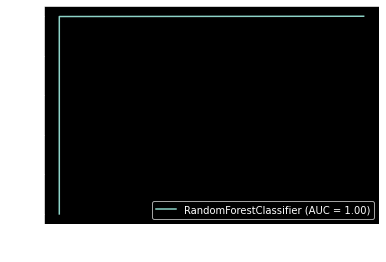

In [ ]:
AucDisp(random_forest)

На валидации значение метрики сильно ниже

In [ ]:
#добавляем результат

models.append('RandomForest(basic)')
auc_scores.append(score_RandomForest)

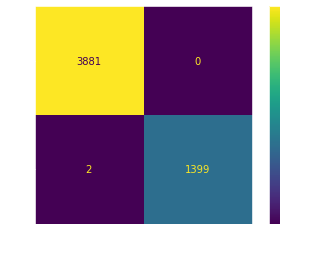

In [ ]:
ConfMatrix(random_forest)

Видим, что модель плохо предсказывает редкий 1 класс

#### RandomizedSearchCV

In [ ]:
# создадим сетку для перебора
param_grid = (
    {'max_depth': np.arange(10, 100),
     'n_estimators': np.arange(50, 500),
     'max_features': ('sqrt', 'log2', None),
    'min_samples_leaf': np.arange(1, 100),
      'min_samples_split': range(2, 200)
    })

In [ ]:
#  инициализируем grid_search
grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = RANDOM_STATE),
                                 param_distributions = param_grid,
                                 cv = 3,
                                 n_iter = 15,
                                 verbose=1,
                                 random_state=RANDOM_STATE,
                                 n_jobs = -1,
                                 scoring = 'roc_auc'
                                 )

In [ ]:
# обучаем

grid_search.fit(train[X],  train[y])

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=11122023),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79,...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
     

In [ ]:
# получаем лучшее значение метрики
grid_search.best_score_

0.8406166019029121

метрика улучшилась незначительно

In [ ]:
for params, std_test_score, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['std_test_score'], grid_search.cv_results_['mean_test_score']):
    print("Параметры:", params)
    print("Стандартное отклонение (std) оценок:", std_test_score)
    print("Средняя оценка:", mean_test_score)
    print()

Параметры: {'n_estimators': 382, 'min_samples_split': 32, 'min_samples_leaf': 44, 'max_features': None, 'max_depth': 95}
Стандартное отклонение (std) оценок: 0.010731096618255397
Средняя оценка: 0.8405319797134453

Параметры: {'n_estimators': 469, 'min_samples_split': 165, 'min_samples_leaf': 58, 'max_features': 'sqrt', 'max_depth': 10}
Стандартное отклонение (std) оценок: 0.011763111673243294
Средняя оценка: 0.8391508482549807

Параметры: {'n_estimators': 339, 'min_samples_split': 146, 'min_samples_leaf': 21, 'max_features': None, 'max_depth': 10}
Стандартное отклонение (std) оценок: 0.010367805143315539
Средняя оценка: 0.8398631926459874

Параметры: {'n_estimators': 77, 'min_samples_split': 78, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'max_depth': 56}
Стандартное отклонение (std) оценок: 0.011685401340938867
Средняя оценка: 0.8400920740597305

Параметры: {'n_estimators': 292, 'min_samples_split': 126, 'min_samples_leaf': 47, 'max_features': None, 'max_depth': 73}
Стандартное о

модель достаточно стабильно предсказывает

In [ ]:
# сохраним модель
random_forest_gs = grid_search.best_estimator_

In [ ]:
score_RandomForest_gs = grid_search.best_score_

# выводим результат
print (f'''
Среднее значение roc_auc для модели RandomForest(grid_search): {score_RandomForest_gs:0.4f}''')


Среднее значение roc_auc для модели RandomForest(grid_search): 0.8406


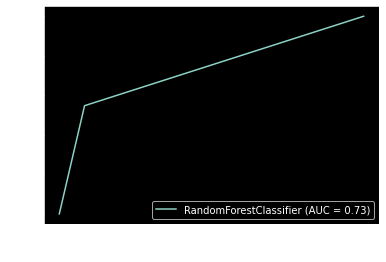

In [ ]:
AucDisp(random_forest_gs)

На валидационном фолде значение метрики сильно ниже чем на train

In [ ]:
# добавляем результат
models.append('RandomForest(grid_search)')
auc_scores.append({score_RandomForest_gs})

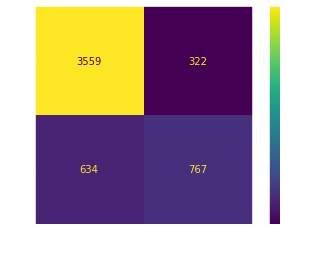

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(grid_search.best_estimator_)

Видим, что нам удалось добиться улучшения в качестве поиска объектов 1 класса. Это хороший результат

In [ ]:
# оценим важность признаков
importances = grid_search.best_estimator_.feature_importances_
rf_feature_importance = pd.DataFrame({'Importances' : importances * 100,
                                      'Features' : X})

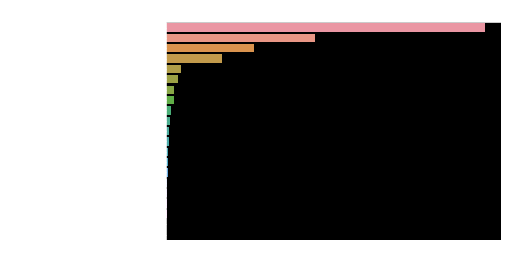

In [ ]:
# построим график
sns.barplot(data = rf_feature_importance.sort_values(by = 'Importances',
                                                     ascending = False),
            x = 'Importances',
            y = 'Features')
plt.title('Важность признаков для RandomForest')
plt.show()

Видим, что randomForest использует мало признаков для предсказаний, что в целом выглядит удивительно.

Согласно этой модели, самыми важными признаками для определения ухода клиента это его траты, тип интернета и способ оплаты услуг. Что не вызывает вопросов, не наблюдается очевидных противоречий с логикой, кроме того что остальные признаки практически совсем игнорируются

### Градиентный бустинг

#### CatBoost

In [ ]:
#инициируем модель
catboost = CatBoostClassifier(random_seed = RANDOM_STATE,
                              verbose = 0)
catboost.fit(train[X], train[y])

In [ ]:
#оценим дефолтные значения
scores = cross_val_score(catboost,
                         train[X],
                         train[y],
                         cv = 5,
                         scoring = 'roc_auc')
scores_catboost = scores.mean()
print (f'''Среднее значение roc_auc для модели CatBoost(basic): {scores_catboost:0.4f}''')

Среднее значение roc_auc для модели CatBoost(basic): 0.8369


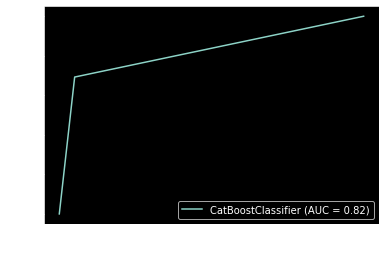

In [ ]:
AucDisp(catboost)

In [ ]:
#сохраним результат
auc_scores.append({scores_catboost})
models.append('CatBoost(basic)')

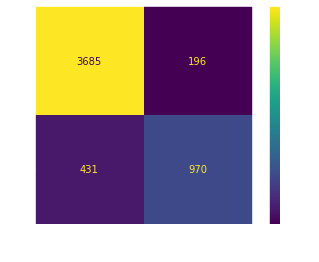

In [ ]:
ConfMatrix(catboost)

На дефолтных параметрах градиентный бустинг дает значения чуть хуже, чем randomforest после подбора гиперпараметров:
- первый класс определяет хорошо

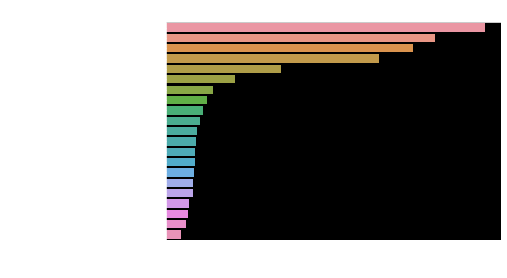

In [ ]:
# проанализируем важность признаков
# обучим модель чтобы извлечь важность признаков

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# построим график
sns.barplot(data = catboost_feature_importance.sort_values(by = 'Importances',ascending = False),
            x='Importances',
            y='Features')
plt.title('Важность признаков для CatBoost')
plt.show()

Catboost использует больше признаков, чем random_forest.
Согласно этой модели, самыми важными признаками для определения ухода клиента это его траты, тип интернета и способ оплаты услуг. Что не вызывает вопросов, не наблюдается очевидных противоречий с логикой использования услуг телеком компаний.

#### Optuna catboost

In [ ]:
# создаем параметры для поиска оптуной
def objective(trial):

    param = {
    'metric': 'auc',
    'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.15),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 1, 9),
    'depth' : trial.suggest_int('depth', 2, 15)
    }

    clf = catboost = CatBoostClassifier(random_seed = RANDOM_STATE, verbose = 100)

    scores = cross_val_score(clf,
                             train[X],
                             train[y],
                             cv = 3,
                             scoring = 'roc_auc')

    return scores.mean()

In [ ]:
# инициализируем обучение
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)

[I 2023-12-23 11:58:32,163] A new study created in memory with name: no-name-0ebb17d8-9134-44e1-9102-98a479d97450


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.59ms	remaining: 2.58s
100:	learn: 0.4075175	total: 248ms	remaining: 2.21s
200:	learn: 0.3785611	total: 474ms	remaining: 1.89s
300:	learn: 0.3601073	total: 724ms	remaining: 1.68s
400:	learn: 0.3439202	total: 951ms	remaining: 1.42s
500:	learn: 0.3278488	total: 1.18s	remaining: 1.18s
600:	learn: 0.3149082	total: 1.41s	remaining: 937ms
700:	learn: 0.3024544	total: 1.64s	remaining: 700ms
800:	learn: 0.2899256	total: 1.89s	remaining: 470ms
900:	learn: 0.2789380	total: 2.12s	remaining: 233ms
999:	learn: 0.2680258	total: 2.35s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 4.86ms	remaining: 4.86s
100:	learn: 0.4019311	total: 285ms	remaining: 2.53s
200:	learn: 0.3709018	total: 510ms	remaining: 2.03s
300:	learn: 0.3511127	total: 744ms	remaining: 1.73s
400:	learn: 0.3342668	total: 1s	remaining: 1.5s
500:	learn: 0.3182841	total: 1.25s	remaining: 1.24s
600:	learn: 0.3045002	total: 1.47s	remaining: 977ms
700:	learn: 

[I 2023-12-23 11:58:42,155] Trial 0 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.14876391912707637, 'l2_leaf_reg': 7, 'depth': 4}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.52ms	remaining: 2.51s
100:	learn: 0.4075175	total: 229ms	remaining: 2.04s
200:	learn: 0.3785611	total: 463ms	remaining: 1.84s
300:	learn: 0.3601073	total: 689ms	remaining: 1.6s
400:	learn: 0.3439202	total: 916ms	remaining: 1.37s
500:	learn: 0.3278488	total: 1.14s	remaining: 1.14s
600:	learn: 0.3149082	total: 1.38s	remaining: 913ms
700:	learn: 0.3024544	total: 1.6s	remaining: 683ms
800:	learn: 0.2899256	total: 1.84s	remaining: 457ms
900:	learn: 0.2789380	total: 2.08s	remaining: 228ms
999:	learn: 0.2680258	total: 2.3s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.59ms	remaining: 2.59s
100:	learn: 0.4019311	total: 258ms	remaining: 2.3s
200:	learn: 0.3709018	total: 517ms	remaining: 2.06s
300:	learn: 0.3511127	total: 750ms	remaining: 1.74s
400:	learn: 0.3342668	total: 979ms	remaining: 1.46s
500:	learn: 0.3182841	total: 1.21s	remaining: 1.2s
600:	learn: 0.3045002	total: 1.44s	remaining: 954ms
700:	learn: 0

[I 2023-12-23 11:58:51,748] Trial 1 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.009689605545120175, 'l2_leaf_reg': 7, 'depth': 5}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.59ms	remaining: 2.59s
100:	learn: 0.4075175	total: 226ms	remaining: 2.01s
200:	learn: 0.3785611	total: 470ms	remaining: 1.87s
300:	learn: 0.3601073	total: 699ms	remaining: 1.62s
400:	learn: 0.3439202	total: 927ms	remaining: 1.38s
500:	learn: 0.3278488	total: 1.16s	remaining: 1.16s
600:	learn: 0.3149082	total: 1.41s	remaining: 934ms
700:	learn: 0.3024544	total: 1.65s	remaining: 703ms
800:	learn: 0.2899256	total: 1.89s	remaining: 470ms
900:	learn: 0.2789380	total: 2.12s	remaining: 233ms
999:	learn: 0.2680258	total: 2.37s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.46ms	remaining: 2.46s
100:	learn: 0.4019311	total: 231ms	remaining: 2.06s
200:	learn: 0.3709018	total: 488ms	remaining: 1.94s
300:	learn: 0.3511127	total: 761ms	remaining: 1.77s
400:	learn: 0.3342668	total: 996ms	remaining: 1.49s
500:	learn: 0.3182841	total: 1.25s	remaining: 1.24s
600:	learn: 0.3045002	total: 1.5s	remaining: 997ms
700:	lear

[I 2023-12-23 11:59:01,697] Trial 2 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.0419808843509445, 'l2_leaf_reg': 8, 'depth': 3}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.44ms	remaining: 2.44s
100:	learn: 0.4075175	total: 225ms	remaining: 2s
200:	learn: 0.3785611	total: 456ms	remaining: 1.81s
300:	learn: 0.3601073	total: 699ms	remaining: 1.62s
400:	learn: 0.3439202	total: 944ms	remaining: 1.41s
500:	learn: 0.3278488	total: 1.18s	remaining: 1.17s
600:	learn: 0.3149082	total: 1.41s	remaining: 935ms
700:	learn: 0.3024544	total: 1.64s	remaining: 698ms
800:	learn: 0.2899256	total: 1.87s	remaining: 464ms
900:	learn: 0.2789380	total: 2.1s	remaining: 231ms
999:	learn: 0.2680258	total: 2.33s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.51ms	remaining: 2.51s
100:	learn: 0.4019311	total: 229ms	remaining: 2.04s
200:	learn: 0.3709018	total: 481ms	remaining: 1.91s
300:	learn: 0.3511127	total: 717ms	remaining: 1.66s
400:	learn: 0.3342668	total: 967ms	remaining: 1.45s
500:	learn: 0.3182841	total: 1.21s	remaining: 1.2s
600:	learn: 0.3045002	total: 1.44s	remaining: 959ms
700:	learn: 0

[I 2023-12-23 11:59:11,893] Trial 3 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.07510444804204806, 'l2_leaf_reg': 2, 'depth': 15}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 3.87ms	remaining: 3.87s
100:	learn: 0.4075175	total: 237ms	remaining: 2.11s
200:	learn: 0.3785611	total: 475ms	remaining: 1.89s
300:	learn: 0.3601073	total: 710ms	remaining: 1.65s
400:	learn: 0.3439202	total: 934ms	remaining: 1.39s
500:	learn: 0.3278488	total: 1.17s	remaining: 1.16s
600:	learn: 0.3149082	total: 1.39s	remaining: 923ms
700:	learn: 0.3024544	total: 1.63s	remaining: 693ms
800:	learn: 0.2899256	total: 1.86s	remaining: 461ms
900:	learn: 0.2789380	total: 2.09s	remaining: 229ms
999:	learn: 0.2680258	total: 2.33s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 3.07ms	remaining: 3.07s
100:	learn: 0.4019311	total: 230ms	remaining: 2.04s
200:	learn: 0.3709018	total: 480ms	remaining: 1.91s
300:	learn: 0.3511127	total: 724ms	remaining: 1.68s
400:	learn: 0.3342668	total: 991ms	remaining: 1.48s
500:	learn: 0.3182841	total: 1.22s	remaining: 1.21s
600:	learn: 0.3045002	total: 1.45s	remaining: 966ms
700:	lea

[I 2023-12-23 11:59:21,740] Trial 4 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.0031256904177682844, 'l2_leaf_reg': 3, 'depth': 6}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.42ms	remaining: 2.42s
100:	learn: 0.4075175	total: 230ms	remaining: 2.05s
200:	learn: 0.3785611	total: 467ms	remaining: 1.85s
300:	learn: 0.3601073	total: 706ms	remaining: 1.64s
400:	learn: 0.3439202	total: 934ms	remaining: 1.4s
500:	learn: 0.3278488	total: 1.17s	remaining: 1.16s
600:	learn: 0.3149082	total: 1.4s	remaining: 930ms
700:	learn: 0.3024544	total: 1.63s	remaining: 697ms
800:	learn: 0.2899256	total: 1.86s	remaining: 463ms
900:	learn: 0.2789380	total: 2.1s	remaining: 231ms
999:	learn: 0.2680258	total: 2.35s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.63ms	remaining: 2.63s
100:	learn: 0.4019311	total: 232ms	remaining: 2.06s
200:	learn: 0.3709018	total: 531ms	remaining: 2.11s
300:	learn: 0.3511127	total: 764ms	remaining: 1.77s
400:	learn: 0.3342668	total: 993ms	remaining: 1.48s
500:	learn: 0.3182841	total: 1.23s	remaining: 1.23s
600:	learn: 0.3045002	total: 1.47s	remaining: 973ms
700:	learn:

[I 2023-12-23 11:59:31,586] Trial 5 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.02220163418491408, 'l2_leaf_reg': 5, 'depth': 14}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 3.82ms	remaining: 3.81s
100:	learn: 0.4075175	total: 231ms	remaining: 2.06s
200:	learn: 0.3785611	total: 456ms	remaining: 1.81s
300:	learn: 0.3601073	total: 688ms	remaining: 1.6s
400:	learn: 0.3439202	total: 922ms	remaining: 1.38s
500:	learn: 0.3278488	total: 1.16s	remaining: 1.16s
600:	learn: 0.3149082	total: 1.39s	remaining: 926ms
700:	learn: 0.3024544	total: 1.62s	remaining: 691ms
800:	learn: 0.2899256	total: 1.85s	remaining: 460ms
900:	learn: 0.2789380	total: 2.08s	remaining: 229ms
999:	learn: 0.2680258	total: 2.32s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.64ms	remaining: 2.64s
100:	learn: 0.4019311	total: 224ms	remaining: 1.99s
200:	learn: 0.3709018	total: 459ms	remaining: 1.82s
300:	learn: 0.3511127	total: 698ms	remaining: 1.62s
400:	learn: 0.3342668	total: 944ms	remaining: 1.41s
500:	learn: 0.3182841	total: 1.17s	remaining: 1.17s
600:	learn: 0.3045002	total: 1.44s	remaining: 953ms
700:	lear

[I 2023-12-23 11:59:41,262] Trial 6 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.03478306528213881, 'l2_leaf_reg': 8, 'depth': 2}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 3.06ms	remaining: 3.06s
100:	learn: 0.4075175	total: 251ms	remaining: 2.24s
200:	learn: 0.3785611	total: 485ms	remaining: 1.93s
300:	learn: 0.3601073	total: 709ms	remaining: 1.65s
400:	learn: 0.3439202	total: 940ms	remaining: 1.4s
500:	learn: 0.3278488	total: 1.18s	remaining: 1.18s
600:	learn: 0.3149082	total: 1.42s	remaining: 941ms
700:	learn: 0.3024544	total: 1.65s	remaining: 703ms
800:	learn: 0.2899256	total: 1.88s	remaining: 466ms
900:	learn: 0.2789380	total: 2.11s	remaining: 232ms
999:	learn: 0.2680258	total: 2.34s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.73ms	remaining: 2.73s
100:	learn: 0.4019311	total: 226ms	remaining: 2.01s
200:	learn: 0.3709018	total: 459ms	remaining: 1.82s
300:	learn: 0.3511127	total: 687ms	remaining: 1.59s
400:	learn: 0.3342668	total: 919ms	remaining: 1.37s
500:	learn: 0.3182841	total: 1.16s	remaining: 1.16s
600:	learn: 0.3045002	total: 1.42s	remaining: 946ms
700:	lear

[I 2023-12-23 11:59:51,004] Trial 7 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.12060309224488897, 'l2_leaf_reg': 9, 'depth': 7}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.62ms	remaining: 2.61s
100:	learn: 0.4075175	total: 225ms	remaining: 2s
200:	learn: 0.3785611	total: 464ms	remaining: 1.84s
300:	learn: 0.3601073	total: 691ms	remaining: 1.6s
400:	learn: 0.3439202	total: 949ms	remaining: 1.42s
500:	learn: 0.3278488	total: 1.18s	remaining: 1.18s
600:	learn: 0.3149082	total: 1.42s	remaining: 940ms
700:	learn: 0.3024544	total: 1.64s	remaining: 701ms
800:	learn: 0.2899256	total: 1.88s	remaining: 467ms
900:	learn: 0.2789380	total: 2.12s	remaining: 233ms
999:	learn: 0.2680258	total: 2.35s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.53ms	remaining: 2.53s
100:	learn: 0.4019311	total: 232ms	remaining: 2.06s
200:	learn: 0.3709018	total: 458ms	remaining: 1.82s
300:	learn: 0.3511127	total: 689ms	remaining: 1.6s
400:	learn: 0.3342668	total: 921ms	remaining: 1.38s
500:	learn: 0.3182841	total: 1.2s	remaining: 1.19s
600:	learn: 0.3045002	total: 1.44s	remaining: 959ms
700:	learn: 0.

[I 2023-12-23 12:00:01,042] Trial 8 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.10020755153311871, 'l2_leaf_reg': 1, 'depth': 8}. Best is trial 0 with value: 0.8332034580532511.


Learning rate set to 0.017634
0:	learn: 0.6805187	total: 2.62ms	remaining: 2.62s
100:	learn: 0.4075175	total: 231ms	remaining: 2.06s
200:	learn: 0.3785611	total: 477ms	remaining: 1.9s
300:	learn: 0.3601073	total: 711ms	remaining: 1.65s
400:	learn: 0.3439202	total: 941ms	remaining: 1.41s
500:	learn: 0.3278488	total: 1.17s	remaining: 1.17s
600:	learn: 0.3149082	total: 1.44s	remaining: 955ms
700:	learn: 0.3024544	total: 1.67s	remaining: 713ms
800:	learn: 0.2899256	total: 1.91s	remaining: 475ms
900:	learn: 0.2789380	total: 2.14s	remaining: 236ms
999:	learn: 0.2680258	total: 2.38s	remaining: 0us
Learning rate set to 0.017634
0:	learn: 0.6800845	total: 2.6ms	remaining: 2.6s
100:	learn: 0.4019311	total: 228ms	remaining: 2.02s
200:	learn: 0.3709018	total: 468ms	remaining: 1.86s
300:	learn: 0.3511127	total: 732ms	remaining: 1.7s
400:	learn: 0.3342668	total: 984ms	remaining: 1.47s
500:	learn: 0.3182841	total: 1.22s	remaining: 1.22s
600:	learn: 0.3045002	total: 1.46s	remaining: 967ms
700:	learn: 

[I 2023-12-23 12:00:11,388] Trial 9 finished with value: 0.8332034580532511 and parameters: {'learning_rate': 0.09747486932075675, 'l2_leaf_reg': 5, 'depth': 14}. Best is trial 0 with value: 0.8332034580532511.


In [ ]:
# получаем максимальные скор
score_catboost_optuna =  study.best_value
print (f'''Лучшее значение метрики roc_auc на train {score_catboost_optuna}''')

Лучшее значение метрики roc_auc на train 0.8332034580532511


In [ ]:
# сохраняем лучшие параметры для модели
best_params_catboost = study.best_params
best_params_catboost

{'learning_rate': 0.14876391912707637, 'l2_leaf_reg': 7, 'depth': 4}

In [ ]:
# сохраним результат
auc_scores.append({score_catboost_optuna})
models.append('Catboost(Optuna)')

In [ ]:
# сохраняем модель
catboost_opt = CatBoostClassifier(random_seed = RANDOM_STATE,
                                  verbose = 100,
                                  **best_params_catboost)
catboost_opt.fit(train[X], train[y])

0:	learn: 0.6036383	total: 1.87ms	remaining: 1.87s
100:	learn: 0.3712416	total: 161ms	remaining: 1.44s
200:	learn: 0.3368781	total: 341ms	remaining: 1.35s
300:	learn: 0.3099409	total: 500ms	remaining: 1.16s
400:	learn: 0.2885576	total: 664ms	remaining: 992ms
500:	learn: 0.2691649	total: 842ms	remaining: 839ms
600:	learn: 0.2527082	total: 1s	remaining: 667ms
700:	learn: 0.2367516	total: 1.16s	remaining: 497ms
800:	learn: 0.2224868	total: 1.32s	remaining: 329ms
900:	learn: 0.2095501	total: 1.49s	remaining: 163ms
999:	learn: 0.1989866	total: 1.65s	remaining: 0us


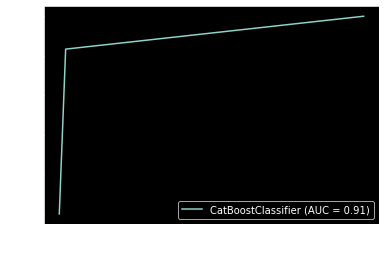

In [ ]:
AucDisp(catboost_opt)

У catboos на гиперпараметрах подобранных с помощью оптуны так же сильно ниже  значение метрики чем на train

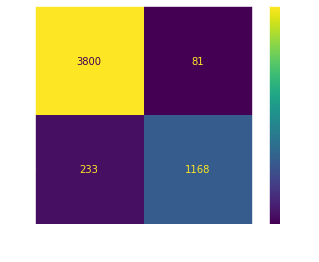

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(catboost_opt)

Видим, что способность определять первый класс сильно не изменилась и не очень высокая

#### lightgbm

In [ ]:
# параметры модели
param = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1}

In [ ]:
# Передаем параметры
lgbm = lgb.LGBMClassifier(**param)
lgbm.fit(train[X], train[y])

LGBMClassifier(metric='auc', objective='binary', verbosity=-1)

In [ ]:
# получаем скор
scores = cross_val_score(lgbm,
                         train[X],
                         train[y],
                         cv = 3,
                         scoring = 'roc_auc')

scores_lgbm = scores.mean()
print (f'''Среднее значение roc_auc на train для модели LightGBM: {scores_lgbm}''')

Среднее значение roc_auc на train для модели LightGBM: 0.8218423052563462


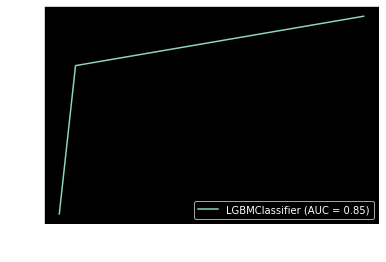

In [ ]:
AucDisp(lgbm)

На валидационной выборке roc auc сильно меньше, чем на train

Метрика  этой модели на дефолтных параметрах соответствует модели random_forest на дефолтных параметрах

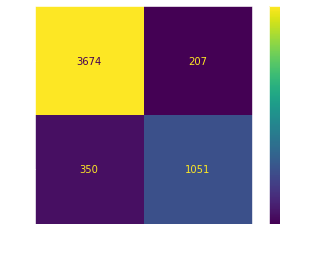

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(lgbm)

Первый класс определяет плохо

In [ ]:
# сохраним результат
auc_scores.append({scores_lgbm})
models.append('LightGBM(basic)')

#### Подбор гиперпараметров

In [ ]:
# создаем параметры для поиска оптуной
def objective(trial):

    param = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'num_leaves': trial.suggest_int('num_leaves', 32, 256),
    'learning_rate' : trial.suggest_float('learning_rate', 0.0001, 0.1),
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    clf = lgb.LGBMClassifier(**param)  # Передаем параметры как именованные аргументы

    scores = cross_val_score(clf,
                      train[X],
                      train[y],
                      cv=3,
                      scoring='roc_auc')

    return scores.mean()

In [ ]:
# инициализируем обучение
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100)

[I 2023-12-23 12:03:23,449] A new study created in memory with name: no-name-ae6ec97b-a64f-4b57-b36b-f45ff533f5ec


[LightGBM] [Warning] bagging_fraction is set=0.5491605018870602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5491605018870602
[LightGBM] [Warning] lambda_l2 is set=1.9478911051110324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9478911051110324
[LightGBM] [Warning] lambda_l1 is set=3.1475028363578934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1475028363578934
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5491605018870602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5491605018870602
[LightGBM] [Warning] lambda_l2 is set=1.9478911051110324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9478911051110324
[LightGBM] [Warning] lambda_l1 is set=3.1475028363578934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1475028363578934
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 wil

[I 2023-12-23 12:03:25,571] Trial 0 finished with value: 0.8332590920112639 and parameters: {'num_leaves': 138, 'learning_rate': 0.0026232667026887253, 'boosting_type': 'gbdt', 'lambda_l1': 3.1475028363578934, 'lambda_l2': 1.9478911051110324, 'bagging_fraction': 0.5491605018870602, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 0 with value: 0.8332590920112639.


[LightGBM] [Warning] bagging_fraction is set=0.4162294446845163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4162294446845163
[LightGBM] [Warning] lambda_l2 is set=6.780416127239951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.780416127239951
[LightGBM] [Warning] lambda_l1 is set=7.040955605479484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.040955605479484
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4162294446845163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4162294446845163
[LightGBM] [Warning] lambda_l2 is set=6.780416127239951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.780416127239951
[LightGBM] [Warning] lambda_l1 is set=7.040955605479484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.040955605479484
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:03:27,887] Trial 1 finished with value: 0.8396390649259348 and parameters: {'num_leaves': 65, 'learning_rate': 0.07677241723582094, 'boosting_type': 'dart', 'lambda_l1': 7.040955605479484, 'lambda_l2': 6.780416127239951, 'bagging_fraction': 0.4162294446845163, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 1 with value: 0.8396390649259348.


[LightGBM] [Warning] bagging_fraction is set=0.95694254522759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95694254522759
[LightGBM] [Warning] lambda_l2 is set=1.4981802436230387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4981802436230387
[LightGBM] [Warning] lambda_l1 is set=0.9321315024769015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9321315024769015
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.95694254522759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95694254522759
[LightGBM] [Warning] lambda_l2 is set=1.4981802436230387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4981802436230387
[LightGBM] [Warning] lambda_l1 is set=0.9321315024769015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9321315024769015
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ign

[I 2023-12-23 12:03:31,766] Trial 2 finished with value: 0.8304769835003638 and parameters: {'num_leaves': 120, 'learning_rate': 0.05380882621236934, 'boosting_type': 'rf', 'lambda_l1': 0.9321315024769015, 'lambda_l2': 1.4981802436230387, 'bagging_fraction': 0.95694254522759, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 1 with value: 0.8396390649259348.


[LightGBM] [Warning] bagging_fraction is set=0.44627916155106473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44627916155106473
[LightGBM] [Warning] lambda_l2 is set=1.2172211813230291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2172211813230291
[LightGBM] [Warning] lambda_l1 is set=6.480560329677315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.480560329677315
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.44627916155106473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44627916155106473
[LightGBM] [Warning] lambda_l2 is set=1.2172211813230291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2172211813230291
[LightGBM] [Warning] lambda_l1 is set=6.480560329677315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.480560329677315
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 wil

[I 2023-12-23 12:03:33,981] Trial 3 finished with value: 0.8289953604589494 and parameters: {'num_leaves': 155, 'learning_rate': 0.0934126775021369, 'boosting_type': 'rf', 'lambda_l1': 6.480560329677315, 'lambda_l2': 1.2172211813230291, 'bagging_fraction': 0.44627916155106473, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 1 with value: 0.8396390649259348.


[LightGBM] [Warning] bagging_fraction is set=0.4694008264115179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4694008264115179
[LightGBM] [Warning] lambda_l2 is set=3.1226467547309444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1226467547309444
[LightGBM] [Warning] lambda_l1 is set=2.7218942754453583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7218942754453583
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4694008264115179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4694008264115179
[LightGBM] [Warning] lambda_l2 is set=3.1226467547309444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1226467547309444
[LightGBM] [Warning] lambda_l1 is set=2.7218942754453583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7218942754453583
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 wil

[I 2023-12-23 12:03:36,076] Trial 4 finished with value: 0.8307800418183581 and parameters: {'num_leaves': 93, 'learning_rate': 0.056483654056777154, 'boosting_type': 'rf', 'lambda_l1': 2.7218942754453583, 'lambda_l2': 3.1226467547309444, 'bagging_fraction': 0.4694008264115179, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 1 with value: 0.8396390649259348.


[LightGBM] [Warning] bagging_fraction is set=0.8649649217167905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649649217167905
[LightGBM] [Warning] lambda_l2 is set=6.927692734281084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.927692734281084
[LightGBM] [Warning] lambda_l1 is set=3.904989196905332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.904989196905332
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8649649217167905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649649217167905
[LightGBM] [Warning] lambda_l2 is set=6.927692734281084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.927692734281084
[LightGBM] [Warning] lambda_l1 is set=3.904989196905332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.904989196905332
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:03:39,676] Trial 5 finished with value: 0.841676141695825 and parameters: {'num_leaves': 59, 'learning_rate': 0.05472236256063294, 'boosting_type': 'gbdt', 'lambda_l1': 3.904989196905332, 'lambda_l2': 6.927692734281084, 'bagging_fraction': 0.8649649217167905, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 5 with value: 0.841676141695825.


[LightGBM] [Warning] bagging_fraction is set=0.533511642182036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.533511642182036
[LightGBM] [Warning] lambda_l2 is set=2.6229582090597963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6229582090597963
[LightGBM] [Warning] lambda_l1 is set=0.13103240885549233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13103240885549233
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.533511642182036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.533511642182036
[LightGBM] [Warning] lambda_l2 is set=2.6229582090597963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6229582090597963
[LightGBM] [Warning] lambda_l1 is set=0.13103240885549233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13103240885549233
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 wil

[I 2023-12-23 12:03:41,681] Trial 6 finished with value: 0.83270807372686 and parameters: {'num_leaves': 227, 'learning_rate': 0.023931175861907465, 'boosting_type': 'rf', 'lambda_l1': 0.13103240885549233, 'lambda_l2': 2.6229582090597963, 'bagging_fraction': 0.533511642182036, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 5 with value: 0.841676141695825.


[LightGBM] [Warning] bagging_fraction is set=0.6863600215224098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6863600215224098
[LightGBM] [Warning] lambda_l2 is set=5.122008772817679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.122008772817679
[LightGBM] [Warning] lambda_l1 is set=1.8186084675377414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8186084675377414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6863600215224098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6863600215224098
[LightGBM] [Warning] lambda_l2 is set=5.122008772817679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.122008772817679
[LightGBM] [Warning] lambda_l1 is set=1.8186084675377414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8186084675377414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be

[I 2023-12-23 12:03:47,278] Trial 7 finished with value: 0.8397026052112525 and parameters: {'num_leaves': 192, 'learning_rate': 0.043839703750623904, 'boosting_type': 'gbdt', 'lambda_l1': 1.8186084675377414, 'lambda_l2': 5.122008772817679, 'bagging_fraction': 0.6863600215224098, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 5 with value: 0.841676141695825.


[LightGBM] [Warning] bagging_fraction is set=0.9471511819391324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471511819391324
[LightGBM] [Warning] lambda_l2 is set=8.494647398962945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.494647398962945
[LightGBM] [Warning] lambda_l1 is set=3.1943840876140435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1943840876140435
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9471511819391324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471511819391324
[LightGBM] [Warning] lambda_l2 is set=8.494647398962945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.494647398962945
[LightGBM] [Warning] lambda_l1 is set=3.1943840876140435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1943840876140435
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be

[I 2023-12-23 12:03:51,379] Trial 8 finished with value: 0.8223188155886385 and parameters: {'num_leaves': 150, 'learning_rate': 0.03449714470978938, 'boosting_type': 'rf', 'lambda_l1': 3.1943840876140435, 'lambda_l2': 8.494647398962945, 'bagging_fraction': 0.9471511819391324, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 5 with value: 0.841676141695825.


[LightGBM] [Warning] bagging_fraction is set=0.5159102724454803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5159102724454803
[LightGBM] [Warning] lambda_l2 is set=4.2442777806025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2442777806025
[LightGBM] [Warning] lambda_l1 is set=6.855931832122424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.855931832122424
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5159102724454803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5159102724454803
[LightGBM] [Warning] lambda_l2 is set=4.2442777806025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2442777806025
[LightGBM] [Warning] lambda_l1 is set=6.855931832122424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.855931832122424
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:03:53,072] Trial 9 finished with value: 0.825581611991327 and parameters: {'num_leaves': 104, 'learning_rate': 0.06416580213008756, 'boosting_type': 'rf', 'lambda_l1': 6.855931832122424, 'lambda_l2': 4.2442777806025, 'bagging_fraction': 0.5159102724454803, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 5 with value: 0.841676141695825.


[LightGBM] [Warning] bagging_fraction is set=0.8168872685922054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8168872685922054
[LightGBM] [Warning] lambda_l2 is set=9.536114424292311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.536114424292311
[LightGBM] [Warning] lambda_l1 is set=9.07923665776333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.07923665776333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8168872685922054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8168872685922054
[LightGBM] [Warning] lambda_l2 is set=9.536114424292311, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.536114424292311
[LightGBM] [Warning] lambda_l1 is set=9.07923665776333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.07923665776333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:03:55,184] Trial 10 finished with value: 0.8434455389680185 and parameters: {'num_leaves': 39, 'learning_rate': 0.09831037092674005, 'boosting_type': 'gbdt', 'lambda_l1': 9.07923665776333, 'lambda_l2': 9.536114424292311, 'bagging_fraction': 0.8168872685922054, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 10 with value: 0.8434455389680185.


[LightGBM] [Warning] bagging_fraction is set=0.8224604259775958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8224604259775958
[LightGBM] [Warning] lambda_l2 is set=9.824572525322077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.824572525322077
[LightGBM] [Warning] lambda_l1 is set=8.925582479964689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.925582479964689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8224604259775958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8224604259775958
[LightGBM] [Warning] lambda_l2 is set=9.824572525322077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.824572525322077
[LightGBM] [Warning] lambda_l1 is set=8.925582479964689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.925582479964689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:03:57,575] Trial 11 finished with value: 0.8441956362532154 and parameters: {'num_leaves': 32, 'learning_rate': 0.09920114899287999, 'boosting_type': 'gbdt', 'lambda_l1': 8.925582479964689, 'lambda_l2': 9.824572525322077, 'bagging_fraction': 0.8224604259775958, 'bagging_freq': 1, 'min_child_samples': 69}. Best is trial 11 with value: 0.8441956362532154.


[LightGBM] [Warning] bagging_fraction is set=0.7765505260398807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7765505260398807
[LightGBM] [Warning] lambda_l2 is set=9.97775926371674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.97775926371674
[LightGBM] [Warning] lambda_l1 is set=9.958396774180274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.958396774180274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7765505260398807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7765505260398807
[LightGBM] [Warning] lambda_l2 is set=9.97775926371674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.97775926371674
[LightGBM] [Warning] lambda_l1 is set=9.958396774180274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.958396774180274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:03:59,771] Trial 12 finished with value: 0.843638052257357 and parameters: {'num_leaves': 35, 'learning_rate': 0.09745606922165356, 'boosting_type': 'gbdt', 'lambda_l1': 9.958396774180274, 'lambda_l2': 9.97775926371674, 'bagging_fraction': 0.7765505260398807, 'bagging_freq': 1, 'min_child_samples': 76}. Best is trial 11 with value: 0.8441956362532154.


[LightGBM] [Warning] bagging_fraction is set=0.7326172328686308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7326172328686308
[LightGBM] [Warning] lambda_l2 is set=9.716002734309747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.716002734309747
[LightGBM] [Warning] lambda_l1 is set=9.954247997970091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.954247997970091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7326172328686308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7326172328686308
[LightGBM] [Warning] lambda_l2 is set=9.716002734309747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.716002734309747
[LightGBM] [Warning] lambda_l1 is set=9.954247997970091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.954247997970091
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:04:01,766] Trial 13 finished with value: 0.8442519800870514 and parameters: {'num_leaves': 37, 'learning_rate': 0.08206771283342124, 'boosting_type': 'gbdt', 'lambda_l1': 9.954247997970091, 'lambda_l2': 9.716002734309747, 'bagging_fraction': 0.7326172328686308, 'bagging_freq': 1, 'min_child_samples': 77}. Best is trial 13 with value: 0.8442519800870514.


[LightGBM] [Warning] bagging_fraction is set=0.6539759526982858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539759526982858
[LightGBM] [Warning] lambda_l2 is set=7.855681671074723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.855681671074723
[LightGBM] [Warning] lambda_l1 is set=8.44212109281564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.44212109281564
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6539759526982858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539759526982858
[LightGBM] [Warning] lambda_l2 is set=7.855681671074723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.855681671074723
[LightGBM] [Warning] lambda_l1 is set=8.44212109281564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.44212109281564
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:03,978] Trial 14 finished with value: 0.8421329804902378 and parameters: {'num_leaves': 81, 'learning_rate': 0.07830146778500327, 'boosting_type': 'dart', 'lambda_l1': 8.44212109281564, 'lambda_l2': 7.855681671074723, 'bagging_fraction': 0.6539759526982858, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 13 with value: 0.8442519800870514.


[LightGBM] [Warning] bagging_fraction is set=0.7485304929421398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7485304929421398
[LightGBM] [Warning] lambda_l2 is set=8.589247635653651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.589247635653651
[LightGBM] [Warning] lambda_l1 is set=8.17358856227183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.17358856227183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7485304929421398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7485304929421398
[LightGBM] [Warning] lambda_l2 is set=8.589247635653651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.589247635653651
[LightGBM] [Warning] lambda_l1 is set=8.17358856227183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.17358856227183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:06,367] Trial 15 finished with value: 0.8447396890944058 and parameters: {'num_leaves': 32, 'learning_rate': 0.07956138321740153, 'boosting_type': 'gbdt', 'lambda_l1': 8.17358856227183, 'lambda_l2': 8.589247635653651, 'bagging_fraction': 0.7485304929421398, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.6196240441425327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6196240441425327
[LightGBM] [Warning] lambda_l2 is set=6.061507597311671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.061507597311671
[LightGBM] [Warning] lambda_l1 is set=5.296394351851906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.296394351851906
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6196240441425327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6196240441425327
[LightGBM] [Warning] lambda_l2 is set=6.061507597311671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.061507597311671
[LightGBM] [Warning] lambda_l1 is set=5.296394351851906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.296394351851906
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ign

[I 2023-12-23 12:04:08,775] Trial 16 finished with value: 0.8417539377296125 and parameters: {'num_leaves': 63, 'learning_rate': 0.0772150444261497, 'boosting_type': 'gbdt', 'lambda_l1': 5.296394351851906, 'lambda_l2': 6.061507597311671, 'bagging_fraction': 0.6196240441425327, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7467964686978165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467964686978165
[LightGBM] [Warning] lambda_l2 is set=8.318743614124449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.318743614124449
[LightGBM] [Warning] lambda_l1 is set=7.862404438225626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.862404438225626
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7467964686978165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467964686978165
[LightGBM] [Warning] lambda_l2 is set=8.318743614124449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.318743614124449
[LightGBM] [Warning] lambda_l1 is set=7.862404438225626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.862404438225626
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:04:11,076] Trial 17 finished with value: 0.843837324724908 and parameters: {'num_leaves': 244, 'learning_rate': 0.06712865987994583, 'boosting_type': 'gbdt', 'lambda_l1': 7.862404438225626, 'lambda_l2': 8.318743614124449, 'bagging_fraction': 0.7467964686978165, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7275597728081374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7275597728081374
[LightGBM] [Warning] lambda_l2 is set=8.806249989557942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.806249989557942
[LightGBM] [Warning] lambda_l1 is set=9.939256243782983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.939256243782983
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7275597728081374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7275597728081374
[LightGBM] [Warning] lambda_l2 is set=8.806249989557942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.806249989557942
[LightGBM] [Warning] lambda_l1 is set=9.939256243782983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.939256243782983
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ign

[I 2023-12-23 12:04:13,575] Trial 18 finished with value: 0.8422764076154792 and parameters: {'num_leaves': 186, 'learning_rate': 0.0863557793546214, 'boosting_type': 'dart', 'lambda_l1': 9.939256243782983, 'lambda_l2': 8.806249989557942, 'bagging_fraction': 0.7275597728081374, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.8852234877171421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8852234877171421
[LightGBM] [Warning] lambda_l2 is set=0.26522404252253473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26522404252253473
[LightGBM] [Warning] lambda_l1 is set=5.552075697218698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.552075697218698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8852234877171421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8852234877171421
[LightGBM] [Warning] lambda_l2 is set=0.26522404252253473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26522404252253473
[LightGBM] [Warning] lambda_l1 is set=5.552075697218698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.552075697218698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wil

[I 2023-12-23 12:04:16,475] Trial 19 finished with value: 0.8408690593848677 and parameters: {'num_leaves': 116, 'learning_rate': 0.06755367238438242, 'boosting_type': 'gbdt', 'lambda_l1': 5.552075697218698, 'lambda_l2': 0.26522404252253473, 'bagging_fraction': 0.8852234877171421, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.6167605832351034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6167605832351034
[LightGBM] [Warning] lambda_l2 is set=7.619357758155686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.619357758155686
[LightGBM] [Warning] lambda_l1 is set=7.8968281333304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8968281333304
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6167605832351034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6167605832351034
[LightGBM] [Warning] lambda_l2 is set=7.619357758155686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.619357758155686
[LightGBM] [Warning] lambda_l1 is set=7.8968281333304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8968281333304
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:04:18,973] Trial 20 finished with value: 0.8429977835125676 and parameters: {'num_leaves': 69, 'learning_rate': 0.08492679900197717, 'boosting_type': 'gbdt', 'lambda_l1': 7.8968281333304, 'lambda_l2': 7.619357758155686, 'bagging_fraction': 0.6167605832351034, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.8182932825662919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182932825662919
[LightGBM] [Warning] lambda_l2 is set=9.182223635425585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.182223635425585
[LightGBM] [Warning] lambda_l1 is set=8.760422726380263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.760422726380263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8182932825662919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182932825662919
[LightGBM] [Warning] lambda_l2 is set=9.182223635425585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.182223635425585
[LightGBM] [Warning] lambda_l1 is set=8.760422726380263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.760422726380263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:04:21,278] Trial 21 finished with value: 0.8435907849367535 and parameters: {'num_leaves': 35, 'learning_rate': 0.08658291059694098, 'boosting_type': 'gbdt', 'lambda_l1': 8.760422726380263, 'lambda_l2': 9.182223635425585, 'bagging_fraction': 0.8182932825662919, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7938562950429657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938562950429657
[LightGBM] [Warning] lambda_l2 is set=9.937508109677026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937508109677026
[LightGBM] [Warning] lambda_l1 is set=9.311446556849678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.311446556849678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7938562950429657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938562950429657
[LightGBM] [Warning] lambda_l2 is set=9.937508109677026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937508109677026
[LightGBM] [Warning] lambda_l1 is set=9.311446556849678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.311446556849678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:04:23,882] Trial 22 finished with value: 0.8443069464034393 and parameters: {'num_leaves': 50, 'learning_rate': 0.09012913542627919, 'boosting_type': 'gbdt', 'lambda_l1': 9.311446556849678, 'lambda_l2': 9.937508109677026, 'bagging_fraction': 0.7938562950429657, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7017033511698814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7017033511698814
[LightGBM] [Warning] lambda_l2 is set=8.958208033310754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.958208033310754
[LightGBM] [Warning] lambda_l1 is set=9.90158682321903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.90158682321903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7017033511698814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7017033511698814
[LightGBM] [Warning] lambda_l2 is set=8.958208033310754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.958208033310754
[LightGBM] [Warning] lambda_l1 is set=9.90158682321903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.90158682321903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:26,184] Trial 23 finished with value: 0.8441799325969663 and parameters: {'num_leaves': 53, 'learning_rate': 0.07242991256175976, 'boosting_type': 'gbdt', 'lambda_l1': 9.90158682321903, 'lambda_l2': 8.958208033310754, 'bagging_fraction': 0.7017033511698814, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7756026615661255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7756026615661255
[LightGBM] [Warning] lambda_l2 is set=7.333303373814809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.333303373814809
[LightGBM] [Warning] lambda_l1 is set=7.82187362417564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.82187362417564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7756026615661255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7756026615661255
[LightGBM] [Warning] lambda_l2 is set=7.333303373814809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.333303373814809
[LightGBM] [Warning] lambda_l1 is set=7.82187362417564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.82187362417564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:28,277] Trial 24 finished with value: 0.8439534335759734 and parameters: {'num_leaves': 81, 'learning_rate': 0.0878886367165817, 'boosting_type': 'gbdt', 'lambda_l1': 7.82187362417564, 'lambda_l2': 7.333303373814809, 'bagging_fraction': 0.7756026615661255, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.900369718735183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900369718735183
[LightGBM] [Warning] lambda_l2 is set=6.001309962701136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.001309962701136
[LightGBM] [Warning] lambda_l1 is set=6.162812640274504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.162812640274504
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.900369718735183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900369718735183
[LightGBM] [Warning] lambda_l2 is set=6.001309962701136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.001309962701136
[LightGBM] [Warning] lambda_l1 is set=6.162812640274504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.162812640274504
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:31,574] Trial 25 finished with value: 0.8417124882765222 and parameters: {'num_leaves': 52, 'learning_rate': 0.06146790586425159, 'boosting_type': 'dart', 'lambda_l1': 6.162812640274504, 'lambda_l2': 6.001309962701136, 'bagging_fraction': 0.900369718735183, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.6694475430440343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694475430440343
[LightGBM] [Warning] lambda_l2 is set=9.922119265771547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.922119265771547
[LightGBM] [Warning] lambda_l1 is set=9.278129434737941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.278129434737941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6694475430440343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694475430440343
[LightGBM] [Warning] lambda_l2 is set=9.922119265771547, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.922119265771547
[LightGBM] [Warning] lambda_l1 is set=9.278129434737941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.278129434737941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:04:34,273] Trial 26 finished with value: 0.8432989924845916 and parameters: {'num_leaves': 86, 'learning_rate': 0.044409015375736514, 'boosting_type': 'gbdt', 'lambda_l1': 9.278129434737941, 'lambda_l2': 9.922119265771547, 'bagging_fraction': 0.6694475430440343, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7689499338625274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689499338625274
[LightGBM] [Warning] lambda_l2 is set=8.069903971412685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.069903971412685
[LightGBM] [Warning] lambda_l1 is set=7.4150243845586195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4150243845586195
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7689499338625274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689499338625274
[LightGBM] [Warning] lambda_l2 is set=8.069903971412685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.069903971412685
[LightGBM] [Warning] lambda_l1 is set=7.4150243845586195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4150243845586195
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:04:37,268] Trial 27 finished with value: 0.8437717761821152 and parameters: {'num_leaves': 46, 'learning_rate': 0.08129441079457532, 'boosting_type': 'gbdt', 'lambda_l1': 7.4150243845586195, 'lambda_l2': 8.069903971412685, 'bagging_fraction': 0.7689499338625274, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.6050562312395737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6050562312395737
[LightGBM] [Warning] lambda_l2 is set=8.99951132324346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.99951132324346
[LightGBM] [Warning] lambda_l1 is set=8.450862759242222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.450862759242222
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6050562312395737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6050562312395737
[LightGBM] [Warning] lambda_l2 is set=8.99951132324346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.99951132324346
[LightGBM] [Warning] lambda_l1 is set=8.450862759242222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.450862759242222
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:39,276] Trial 28 finished with value: 0.8433726237571252 and parameters: {'num_leaves': 73, 'learning_rate': 0.09203281527589023, 'boosting_type': 'gbdt', 'lambda_l1': 8.450862759242222, 'lambda_l2': 8.99951132324346, 'bagging_fraction': 0.6050562312395737, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7216137820875321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216137820875321
[LightGBM] [Warning] lambda_l2 is set=6.512557547676769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.512557547676769
[LightGBM] [Warning] lambda_l1 is set=9.57991191385225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.57991191385225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7216137820875321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216137820875321
[LightGBM] [Warning] lambda_l2 is set=6.512557547676769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.512557547676769
[LightGBM] [Warning] lambda_l1 is set=9.57991191385225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.57991191385225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:41,477] Trial 29 finished with value: 0.8374679415022834 and parameters: {'num_leaves': 132, 'learning_rate': 0.01576029345564499, 'boosting_type': 'gbdt', 'lambda_l1': 9.57991191385225, 'lambda_l2': 6.512557547676769, 'bagging_fraction': 0.7216137820875321, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.8400409156019571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8400409156019571
[LightGBM] [Warning] lambda_l2 is set=4.965332162181081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965332162181081
[LightGBM] [Warning] lambda_l1 is set=5.8229946466268245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8229946466268245
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8400409156019571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8400409156019571
[LightGBM] [Warning] lambda_l2 is set=4.965332162181081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.965332162181081
[LightGBM] [Warning] lambda_l1 is set=5.8229946466268245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8229946466268245
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:04:44,469] Trial 30 finished with value: 0.8289270993287629 and parameters: {'num_leaves': 101, 'learning_rate': 0.004538395761407341, 'boosting_type': 'dart', 'lambda_l1': 5.8229946466268245, 'lambda_l2': 4.965332162181081, 'bagging_fraction': 0.8400409156019571, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.8047700753260805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8047700753260805
[LightGBM] [Warning] lambda_l2 is set=9.991309260570667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.991309260570667
[LightGBM] [Warning] lambda_l1 is set=8.830099014872776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.830099014872776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8047700753260805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8047700753260805
[LightGBM] [Warning] lambda_l2 is set=9.991309260570667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.991309260570667
[LightGBM] [Warning] lambda_l1 is set=8.830099014872776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.830099014872776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:04:47,484] Trial 31 finished with value: 0.8436780836652323 and parameters: {'num_leaves': 33, 'learning_rate': 0.09963302132190205, 'boosting_type': 'gbdt', 'lambda_l1': 8.830099014872776, 'lambda_l2': 9.991309260570667, 'bagging_fraction': 0.8047700753260805, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.854415661002844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.854415661002844
[LightGBM] [Warning] lambda_l2 is set=9.415447245874121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.415447245874121
[LightGBM] [Warning] lambda_l1 is set=4.35956571570326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35956571570326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.854415661002844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.854415661002844
[LightGBM] [Warning] lambda_l2 is set=9.415447245874121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.415447245874121
[LightGBM] [Warning] lambda_l1 is set=4.35956571570326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35956571570326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:04:50,375] Trial 32 finished with value: 0.8402172071645402 and parameters: {'num_leaves': 50, 'learning_rate': 0.09123424957301202, 'boosting_type': 'gbdt', 'lambda_l1': 4.35956571570326, 'lambda_l2': 9.415447245874121, 'bagging_fraction': 0.854415661002844, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.9862165108361135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9862165108361135
[LightGBM] [Warning] lambda_l2 is set=8.57413988543072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57413988543072
[LightGBM] [Warning] lambda_l1 is set=9.395354464955261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.395354464955261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9862165108361135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9862165108361135
[LightGBM] [Warning] lambda_l2 is set=8.57413988543072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57413988543072
[LightGBM] [Warning] lambda_l1 is set=9.395354464955261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.395354464955261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:52,970] Trial 33 finished with value: 0.8432100210258819 and parameters: {'num_leaves': 32, 'learning_rate': 0.07456929264254189, 'boosting_type': 'gbdt', 'lambda_l1': 9.395354464955261, 'lambda_l2': 8.57413988543072, 'bagging_fraction': 0.9862165108361135, 'bagging_freq': 1, 'min_child_samples': 72}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.9115624876301381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9115624876301381
[LightGBM] [Warning] lambda_l2 is set=9.514505875757797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.514505875757797
[LightGBM] [Warning] lambda_l1 is set=7.21518643629014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.21518643629014
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9115624876301381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9115624876301381
[LightGBM] [Warning] lambda_l2 is set=9.514505875757797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.514505875757797
[LightGBM] [Warning] lambda_l1 is set=7.21518643629014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.21518643629014
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:56,375] Trial 34 finished with value: 0.8418105652578132 and parameters: {'num_leaves': 62, 'learning_rate': 0.08186478122050339, 'boosting_type': 'gbdt', 'lambda_l1': 7.21518643629014, 'lambda_l2': 9.514505875757797, 'bagging_fraction': 0.9115624876301381, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7895573442839077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7895573442839077
[LightGBM] [Warning] lambda_l2 is set=7.27268041938415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.27268041938415
[LightGBM] [Warning] lambda_l1 is set=8.375175785252742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.375175785252742
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7895573442839077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7895573442839077
[LightGBM] [Warning] lambda_l2 is set=7.27268041938415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.27268041938415
[LightGBM] [Warning] lambda_l1 is set=8.375175785252742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.375175785252742
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:04:58,580] Trial 35 finished with value: 0.8437184996602806 and parameters: {'num_leaves': 49, 'learning_rate': 0.0920732396539643, 'boosting_type': 'gbdt', 'lambda_l1': 8.375175785252742, 'lambda_l2': 7.27268041938415, 'bagging_fraction': 0.7895573442839077, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 15 with value: 0.8447396890944058.


[LightGBM] [Warning] bagging_fraction is set=0.7499483481798909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7499483481798909
[LightGBM] [Warning] lambda_l2 is set=8.31308925129641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.31308925129641
[LightGBM] [Warning] lambda_l1 is set=9.040526777195717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.040526777195717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7499483481798909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7499483481798909
[LightGBM] [Warning] lambda_l2 is set=8.31308925129641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.31308925129641
[LightGBM] [Warning] lambda_l1 is set=9.040526777195717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.040526777195717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:05:00,974] Trial 36 finished with value: 0.8447818648477301 and parameters: {'num_leaves': 75, 'learning_rate': 0.07223518852545129, 'boosting_type': 'gbdt', 'lambda_l1': 9.040526777195717, 'lambda_l2': 8.31308925129641, 'bagging_fraction': 0.7499483481798909, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7375837517551832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375837517551832
[LightGBM] [Warning] lambda_l2 is set=8.09197320270517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.09197320270517
[LightGBM] [Warning] lambda_l1 is set=6.62486508545258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.62486508545258
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7375837517551832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375837517551832
[LightGBM] [Warning] lambda_l2 is set=8.09197320270517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.09197320270517
[LightGBM] [Warning] lambda_l1 is set=6.62486508545258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.62486508545258
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:05:04,273] Trial 37 finished with value: 0.8420979254654634 and parameters: {'num_leaves': 73, 'learning_rate': 0.0712323872411797, 'boosting_type': 'dart', 'lambda_l1': 6.62486508545258, 'lambda_l2': 8.09197320270517, 'bagging_fraction': 0.7375837517551832, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.649929183399797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.649929183399797
[LightGBM] [Warning] lambda_l2 is set=6.748225153848686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.748225153848686
[LightGBM] [Warning] lambda_l1 is set=8.058939652882053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.058939652882053
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.649929183399797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.649929183399797
[LightGBM] [Warning] lambda_l2 is set=6.748225153848686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.748225153848686
[LightGBM] [Warning] lambda_l1 is set=8.058939652882053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.058939652882053
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored

[I 2023-12-23 12:05:06,577] Trial 38 finished with value: 0.822605992994732 and parameters: {'num_leaves': 105, 'learning_rate': 0.061563983338086214, 'boosting_type': 'rf', 'lambda_l1': 8.058939652882053, 'lambda_l2': 6.748225153848686, 'bagging_fraction': 0.649929183399797, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7062928431176237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7062928431176237
[LightGBM] [Warning] lambda_l2 is set=8.518530191170733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.518530191170733
[LightGBM] [Warning] lambda_l1 is set=9.464583454998412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.464583454998412
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7062928431176237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7062928431176237
[LightGBM] [Warning] lambda_l2 is set=8.518530191170733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.518530191170733
[LightGBM] [Warning] lambda_l1 is set=9.464583454998412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.464583454998412
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:05:09,667] Trial 39 finished with value: 0.8442419782609214 and parameters: {'num_leaves': 176, 'learning_rate': 0.04967641498252637, 'boosting_type': 'gbdt', 'lambda_l1': 9.464583454998412, 'lambda_l2': 8.518530191170733, 'bagging_fraction': 0.7062928431176237, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.5756642989274403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5756642989274403
[LightGBM] [Warning] lambda_l2 is set=3.8220935687744895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8220935687744895
[LightGBM] [Warning] lambda_l1 is set=7.396296120106459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.396296120106459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5756642989274403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5756642989274403
[LightGBM] [Warning] lambda_l2 is set=3.8220935687744895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8220935687744895
[LightGBM] [Warning] lambda_l1 is set=7.396296120106459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.396296120106459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:05:13,872] Trial 40 finished with value: 0.8265518740209382 and parameters: {'num_leaves': 129, 'learning_rate': 0.08119925056211963, 'boosting_type': 'rf', 'lambda_l1': 7.396296120106459, 'lambda_l2': 3.8220935687744895, 'bagging_fraction': 0.5756642989274403, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.70760581274569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.70760581274569
[LightGBM] [Warning] lambda_l2 is set=8.706850367762623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.706850367762623
[LightGBM] [Warning] lambda_l1 is set=9.436373798218714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.436373798218714
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.70760581274569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.70760581274569
[LightGBM] [Warning] lambda_l2 is set=8.706850367762623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.706850367762623
[LightGBM] [Warning] lambda_l1 is set=9.436373798218714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.436373798218714
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:05:17,669] Trial 41 finished with value: 0.8443813368250281 and parameters: {'num_leaves': 173, 'learning_rate': 0.04975247001043403, 'boosting_type': 'gbdt', 'lambda_l1': 9.436373798218714, 'lambda_l2': 8.706850367762623, 'bagging_fraction': 0.70760581274569, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7529105850022978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7529105850022978
[LightGBM] [Warning] lambda_l2 is set=8.972385233356416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.972385233356416
[LightGBM] [Warning] lambda_l1 is set=9.134852493709024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.134852493709024
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7529105850022978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7529105850022978
[LightGBM] [Warning] lambda_l2 is set=8.972385233356416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.972385233356416
[LightGBM] [Warning] lambda_l1 is set=9.134852493709024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.134852493709024
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:05:20,186] Trial 42 finished with value: 0.8442703521767593 and parameters: {'num_leaves': 162, 'learning_rate': 0.0495117405049894, 'boosting_type': 'gbdt', 'lambda_l1': 9.134852493709024, 'lambda_l2': 8.972385233356416, 'bagging_fraction': 0.7529105850022978, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7566891024128678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566891024128678
[LightGBM] [Warning] lambda_l2 is set=9.134275945799022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.134275945799022
[LightGBM] [Warning] lambda_l1 is set=8.976624967878607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.976624967878607
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7566891024128678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566891024128678
[LightGBM] [Warning] lambda_l2 is set=9.134275945799022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.134275945799022
[LightGBM] [Warning] lambda_l1 is set=8.976624967878607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.976624967878607
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:05:25,266] Trial 43 finished with value: 0.8437578201258124 and parameters: {'num_leaves': 157, 'learning_rate': 0.044642270971373035, 'boosting_type': 'gbdt', 'lambda_l1': 8.976624967878607, 'lambda_l2': 9.134275945799022, 'bagging_fraction': 0.7566891024128678, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.6826734779788705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826734779788705
[LightGBM] [Warning] lambda_l2 is set=7.6729295132474205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.6729295132474205
[LightGBM] [Warning] lambda_l1 is set=8.587844115183316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.587844115183316
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6826734779788705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826734779788705
[LightGBM] [Warning] lambda_l2 is set=7.6729295132474205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.6729295132474205
[LightGBM] [Warning] lambda_l1 is set=8.587844115183316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.587844115183316
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:05:27,975] Trial 44 finished with value: 0.8433605394437165 and parameters: {'num_leaves': 168, 'learning_rate': 0.033625382876181054, 'boosting_type': 'gbdt', 'lambda_l1': 8.587844115183316, 'lambda_l2': 7.6729295132474205, 'bagging_fraction': 0.6826734779788705, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7889506701711851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889506701711851
[LightGBM] [Warning] lambda_l2 is set=8.548050867611344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.548050867611344
[LightGBM] [Warning] lambda_l1 is set=9.444350319786778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.444350319786778
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7889506701711851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889506701711851
[LightGBM] [Warning] lambda_l2 is set=8.548050867611344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.548050867611344
[LightGBM] [Warning] lambda_l1 is set=9.444350319786778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.444350319786778
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:05:30,578] Trial 45 finished with value: 0.8433980363730663 and parameters: {'num_leaves': 205, 'learning_rate': 0.05299553798090699, 'boosting_type': 'gbdt', 'lambda_l1': 9.444350319786778, 'lambda_l2': 8.548050867611344, 'bagging_fraction': 0.7889506701711851, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7062901861701147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7062901861701147
[LightGBM] [Warning] lambda_l2 is set=2.280734050721246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.280734050721246
[LightGBM] [Warning] lambda_l1 is set=1.6646098346698186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6646098346698186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7062901861701147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7062901861701147
[LightGBM] [Warning] lambda_l2 is set=2.280734050721246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.280734050721246
[LightGBM] [Warning] lambda_l1 is set=1.6646098346698186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6646098346698186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:05:34,671] Trial 46 finished with value: 0.8406267673332358 and parameters: {'num_leaves': 205, 'learning_rate': 0.03800302097610136, 'boosting_type': 'gbdt', 'lambda_l1': 1.6646098346698186, 'lambda_l2': 2.280734050721246, 'bagging_fraction': 0.7062901861701147, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.8377835895210238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377835895210238
[LightGBM] [Warning] lambda_l2 is set=7.250756578149652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.250756578149652
[LightGBM] [Warning] lambda_l1 is set=8.2193363475869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.2193363475869
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8377835895210238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377835895210238
[LightGBM] [Warning] lambda_l2 is set=7.250756578149652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.250756578149652
[LightGBM] [Warning] lambda_l1 is set=8.2193363475869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.2193363475869
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:05:37,474] Trial 47 finished with value: 0.8222592231343725 and parameters: {'num_leaves': 140, 'learning_rate': 0.056194168746967435, 'boosting_type': 'rf', 'lambda_l1': 8.2193363475869, 'lambda_l2': 7.250756578149652, 'bagging_fraction': 0.8377835895210238, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7522315607642662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522315607642662
[LightGBM] [Warning] lambda_l2 is set=9.285758208594148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.285758208594148
[LightGBM] [Warning] lambda_l1 is set=9.08975470470767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.08975470470767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7522315607642662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522315607642662
[LightGBM] [Warning] lambda_l2 is set=9.285758208594148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.285758208594148
[LightGBM] [Warning] lambda_l1 is set=9.08975470470767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.08975470470767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:05:40,669] Trial 48 finished with value: 0.8412447144508332 and parameters: {'num_leaves': 169, 'learning_rate': 0.024866195530504363, 'boosting_type': 'gbdt', 'lambda_l1': 9.08975470470767, 'lambda_l2': 9.285758208594148, 'bagging_fraction': 0.7522315607642662, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.651527515095507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.651527515095507
[LightGBM] [Warning] lambda_l2 is set=8.202387761196436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202387761196436
[LightGBM] [Warning] lambda_l1 is set=7.771047478468363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.771047478468363
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.651527515095507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.651527515095507
[LightGBM] [Warning] lambda_l2 is set=8.202387761196436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.202387761196436
[LightGBM] [Warning] lambda_l1 is set=7.771047478468363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.771047478468363
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored

[I 2023-12-23 12:05:43,873] Trial 49 finished with value: 0.8433924377820995 and parameters: {'num_leaves': 150, 'learning_rate': 0.04828516155342931, 'boosting_type': 'gbdt', 'lambda_l1': 7.771047478468363, 'lambda_l2': 8.202387761196436, 'bagging_fraction': 0.651527515095507, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.8773921612436048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8773921612436048
[LightGBM] [Warning] lambda_l2 is set=6.169063713856303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.169063713856303
[LightGBM] [Warning] lambda_l1 is set=9.637292593794573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.637292593794573
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8773921612436048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8773921612436048
[LightGBM] [Warning] lambda_l2 is set=6.169063713856303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.169063713856303
[LightGBM] [Warning] lambda_l1 is set=9.637292593794573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.637292593794573
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ign

[I 2023-12-23 12:05:46,369] Trial 50 finished with value: 0.8431808655640655 and parameters: {'num_leaves': 208, 'learning_rate': 0.06033366979990154, 'boosting_type': 'gbdt', 'lambda_l1': 9.637292593794573, 'lambda_l2': 6.169063713856303, 'bagging_fraction': 0.8773921612436048, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7284960030819932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7284960030819932
[LightGBM] [Warning] lambda_l2 is set=9.580629307674409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.580629307674409
[LightGBM] [Warning] lambda_l1 is set=9.934953864517874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.934953864517874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7284960030819932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7284960030819932
[LightGBM] [Warning] lambda_l2 is set=9.580629307674409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.580629307674409
[LightGBM] [Warning] lambda_l1 is set=9.934953864517874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.934953864517874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:05:48,473] Trial 51 finished with value: 0.8445298907127142 and parameters: {'num_leaves': 44, 'learning_rate': 0.06847351219315803, 'boosting_type': 'gbdt', 'lambda_l1': 9.934953864517874, 'lambda_l2': 9.580629307674409, 'bagging_fraction': 0.7284960030819932, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7978762055237066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7978762055237066
[LightGBM] [Warning] lambda_l2 is set=8.800257068085024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.800257068085024
[LightGBM] [Warning] lambda_l1 is set=9.11875809580642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.11875809580642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7978762055237066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7978762055237066
[LightGBM] [Warning] lambda_l2 is set=8.800257068085024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.800257068085024
[LightGBM] [Warning] lambda_l1 is set=9.11875809580642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.11875809580642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:05:50,986] Trial 52 finished with value: 0.8441293228021581 and parameters: {'num_leaves': 185, 'learning_rate': 0.06814858520249278, 'boosting_type': 'gbdt', 'lambda_l1': 9.11875809580642, 'lambda_l2': 8.800257068085024, 'bagging_fraction': 0.7978762055237066, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7233202436462693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7233202436462693
[LightGBM] [Warning] lambda_l2 is set=9.550850711776944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.550850711776944
[LightGBM] [Warning] lambda_l1 is set=8.794141733393127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.794141733393127
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7233202436462693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7233202436462693
[LightGBM] [Warning] lambda_l2 is set=9.550850711776944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.550850711776944
[LightGBM] [Warning] lambda_l1 is set=8.794141733393127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.794141733393127
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:05:53,575] Trial 53 finished with value: 0.8433882979774175 and parameters: {'num_leaves': 44, 'learning_rate': 0.03943974479121136, 'boosting_type': 'gbdt', 'lambda_l1': 8.794141733393127, 'lambda_l2': 9.550850711776944, 'bagging_fraction': 0.7233202436462693, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.4183319333372425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4183319333372425
[LightGBM] [Warning] lambda_l2 is set=7.878640845481738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.878640845481738
[LightGBM] [Warning] lambda_l1 is set=9.814050193656112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814050193656112
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4183319333372425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4183319333372425
[LightGBM] [Warning] lambda_l2 is set=7.878640845481738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.878640845481738
[LightGBM] [Warning] lambda_l1 is set=9.814050193656112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814050193656112
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:05:55,668] Trial 54 finished with value: 0.8435508021621975 and parameters: {'num_leaves': 58, 'learning_rate': 0.05766263470546326, 'boosting_type': 'gbdt', 'lambda_l1': 9.814050193656112, 'lambda_l2': 7.878640845481738, 'bagging_fraction': 0.4183319333372425, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7585773072189115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7585773072189115
[LightGBM] [Warning] lambda_l2 is set=8.862978800534954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.862978800534954
[LightGBM] [Warning] lambda_l1 is set=9.99101572617337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.99101572617337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7585773072189115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7585773072189115
[LightGBM] [Warning] lambda_l2 is set=8.862978800534954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.862978800534954
[LightGBM] [Warning] lambda_l1 is set=9.99101572617337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.99101572617337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:05:57,867] Trial 55 finished with value: 0.8443220749920141 and parameters: {'num_leaves': 158, 'learning_rate': 0.07669048893635302, 'boosting_type': 'gbdt', 'lambda_l1': 9.99101572617337, 'lambda_l2': 8.862978800534954, 'bagging_fraction': 0.7585773072189115, 'bagging_freq': 1, 'min_child_samples': 65}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.6719642014616106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6719642014616106
[LightGBM] [Warning] lambda_l2 is set=9.604667291913767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.604667291913767
[LightGBM] [Warning] lambda_l1 is set=4.692886850101046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.692886850101046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6719642014616106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6719642014616106
[LightGBM] [Warning] lambda_l2 is set=9.604667291913767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.604667291913767
[LightGBM] [Warning] lambda_l1 is set=4.692886850101046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.692886850101046
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:00,977] Trial 56 finished with value: 0.8435389955706403 and parameters: {'num_leaves': 119, 'learning_rate': 0.07807842167379998, 'boosting_type': 'dart', 'lambda_l1': 4.692886850101046, 'lambda_l2': 9.604667291913767, 'bagging_fraction': 0.6719642014616106, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7757224827611687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757224827611687
[LightGBM] [Warning] lambda_l2 is set=8.649478785197564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.649478785197564
[LightGBM] [Warning] lambda_l1 is set=3.311519684898178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311519684898178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7757224827611687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757224827611687
[LightGBM] [Warning] lambda_l2 is set=8.649478785197564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.649478785197564
[LightGBM] [Warning] lambda_l1 is set=3.311519684898178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311519684898178
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:04,275] Trial 57 finished with value: 0.8416739649281636 and parameters: {'num_leaves': 42, 'learning_rate': 0.07273381684226328, 'boosting_type': 'gbdt', 'lambda_l1': 3.311519684898178, 'lambda_l2': 8.649478785197564, 'bagging_fraction': 0.7757224827611687, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.699404240957573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.699404240957573
[LightGBM] [Warning] lambda_l2 is set=1.091777295809734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.091777295809734
[LightGBM] [Warning] lambda_l1 is set=9.945844085999916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.945844085999916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.699404240957573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.699404240957573
[LightGBM] [Warning] lambda_l2 is set=1.091777295809734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.091777295809734
[LightGBM] [Warning] lambda_l1 is set=9.945844085999916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.945844085999916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:06:06,169] Trial 58 finished with value: 0.827777765150179 and parameters: {'num_leaves': 59, 'learning_rate': 0.06653701364098787, 'boosting_type': 'rf', 'lambda_l1': 9.945844085999916, 'lambda_l2': 1.091777295809734, 'bagging_fraction': 0.699404240957573, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.489290698416592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.489290698416592
[LightGBM] [Warning] lambda_l2 is set=8.282083664496136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.282083664496136
[LightGBM] [Warning] lambda_l1 is set=8.55066025651288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.55066025651288
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.489290698416592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.489290698416592
[LightGBM] [Warning] lambda_l2 is set=8.282083664496136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.282083664496136
[LightGBM] [Warning] lambda_l1 is set=8.55066025651288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.55066025651288
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:06:08,069] Trial 59 finished with value: 0.8424169694276388 and parameters: {'num_leaves': 91, 'learning_rate': 0.09454385042801403, 'boosting_type': 'gbdt', 'lambda_l1': 8.55066025651288, 'lambda_l2': 8.282083664496136, 'bagging_fraction': 0.489290698416592, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.8186637640407369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186637640407369
[LightGBM] [Warning] lambda_l2 is set=5.38550115761746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.38550115761746
[LightGBM] [Warning] lambda_l1 is set=0.1053685885727269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1053685885727269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8186637640407369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8186637640407369
[LightGBM] [Warning] lambda_l2 is set=5.38550115761746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.38550115761746
[LightGBM] [Warning] lambda_l1 is set=0.1053685885727269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1053685885727269
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:11,769] Trial 60 finished with value: 0.8378238657318479 and parameters: {'num_leaves': 147, 'learning_rate': 0.06984983669550147, 'boosting_type': 'gbdt', 'lambda_l1': 0.1053685885727269, 'lambda_l2': 5.38550115761746, 'bagging_fraction': 0.8186637640407369, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7540791206585336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7540791206585336
[LightGBM] [Warning] lambda_l2 is set=9.147922204460606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.147922204460606
[LightGBM] [Warning] lambda_l1 is set=9.234400181509375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.234400181509375
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7540791206585336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7540791206585336
[LightGBM] [Warning] lambda_l2 is set=9.147922204460606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.147922204460606
[LightGBM] [Warning] lambda_l1 is set=9.234400181509375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.234400181509375
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ign

[I 2023-12-23 12:06:14,075] Trial 61 finished with value: 0.8436120594544448 and parameters: {'num_leaves': 154, 'learning_rate': 0.0525952855711893, 'boosting_type': 'gbdt', 'lambda_l1': 9.234400181509375, 'lambda_l2': 9.147922204460606, 'bagging_fraction': 0.7540791206585336, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7324630746385028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7324630746385028
[LightGBM] [Warning] lambda_l2 is set=8.85692608403528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.85692608403528
[LightGBM] [Warning] lambda_l1 is set=9.586997550082096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.586997550082096
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7324630746385028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7324630746385028
[LightGBM] [Warning] lambda_l2 is set=8.85692608403528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.85692608403528
[LightGBM] [Warning] lambda_l1 is set=9.586997550082096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.586997550082096
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:06:16,566] Trial 62 finished with value: 0.8444819636427353 and parameters: {'num_leaves': 166, 'learning_rate': 0.06408520599849613, 'boosting_type': 'gbdt', 'lambda_l1': 9.586997550082096, 'lambda_l2': 8.85692608403528, 'bagging_fraction': 0.7324630746385028, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 36 with value: 0.8447818648477301.


[LightGBM] [Warning] bagging_fraction is set=0.7153573304878539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7153573304878539
[LightGBM] [Warning] lambda_l2 is set=9.697483917595987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.697483917595987
[LightGBM] [Warning] lambda_l1 is set=9.624439177943476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624439177943476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7153573304878539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7153573304878539
[LightGBM] [Warning] lambda_l2 is set=9.697483917595987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.697483917595987
[LightGBM] [Warning] lambda_l1 is set=9.624439177943476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624439177943476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:18,765] Trial 63 finished with value: 0.8449475688063162 and parameters: {'num_leaves': 178, 'learning_rate': 0.06480955967312624, 'boosting_type': 'gbdt', 'lambda_l1': 9.624439177943476, 'lambda_l2': 9.697483917595987, 'bagging_fraction': 0.7153573304878539, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6398112674734124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6398112674734124
[LightGBM] [Warning] lambda_l2 is set=9.404841307561423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.404841307561423
[LightGBM] [Warning] lambda_l1 is set=9.663871064011856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.663871064011856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6398112674734124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6398112674734124
[LightGBM] [Warning] lambda_l2 is set=9.404841307561423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.404841307561423
[LightGBM] [Warning] lambda_l1 is set=9.663871064011856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.663871064011856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:21,470] Trial 64 finished with value: 0.8444096192334355 and parameters: {'num_leaves': 181, 'learning_rate': 0.06332659022684403, 'boosting_type': 'gbdt', 'lambda_l1': 9.663871064011856, 'lambda_l2': 9.404841307561423, 'bagging_fraction': 0.6398112674734124, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6401440741692029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6401440741692029
[LightGBM] [Warning] lambda_l2 is set=9.327187816185628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.327187816185628
[LightGBM] [Warning] lambda_l1 is set=9.548068836561882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.548068836561882
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6401440741692029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6401440741692029
[LightGBM] [Warning] lambda_l2 is set=9.327187816185628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.327187816185628
[LightGBM] [Warning] lambda_l1 is set=9.548068836561882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.548068836561882
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:06:24,575] Trial 65 finished with value: 0.8428333794287616 and parameters: {'num_leaves': 194, 'learning_rate': 0.06293010006287068, 'boosting_type': 'gbdt', 'lambda_l1': 9.548068836561882, 'lambda_l2': 9.327187816185628, 'bagging_fraction': 0.6401440741692029, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6288159614118103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288159614118103
[LightGBM] [Warning] lambda_l2 is set=9.703488239567625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.703488239567625
[LightGBM] [Warning] lambda_l1 is set=9.651189379543752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.651189379543752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6288159614118103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6288159614118103
[LightGBM] [Warning] lambda_l2 is set=9.703488239567625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.703488239567625
[LightGBM] [Warning] lambda_l1 is set=9.651189379543752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.651189379543752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:27,473] Trial 66 finished with value: 0.844188766156905 and parameters: {'num_leaves': 179, 'learning_rate': 0.05832189427918698, 'boosting_type': 'gbdt', 'lambda_l1': 9.651189379543752, 'lambda_l2': 9.703488239567625, 'bagging_fraction': 0.6288159614118103, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.5894093304944015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5894093304944015
[LightGBM] [Warning] lambda_l2 is set=7.553829308146544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.553829308146544
[LightGBM] [Warning] lambda_l1 is set=8.723078287685611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.723078287685611
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5894093304944015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5894093304944015
[LightGBM] [Warning] lambda_l2 is set=7.553829308146544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.553829308146544
[LightGBM] [Warning] lambda_l1 is set=8.723078287685611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.723078287685611
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ign

[I 2023-12-23 12:06:30,668] Trial 67 finished with value: 0.843036737095162 and parameters: {'num_leaves': 196, 'learning_rate': 0.074011217418541, 'boosting_type': 'gbdt', 'lambda_l1': 8.723078287685611, 'lambda_l2': 7.553829308146544, 'bagging_fraction': 0.5894093304944015, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6760481316628335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760481316628335
[LightGBM] [Warning] lambda_l2 is set=7.9038769769292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9038769769292
[LightGBM] [Warning] lambda_l1 is set=8.185648158596198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.185648158596198
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6760481316628335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760481316628335
[LightGBM] [Warning] lambda_l2 is set=7.9038769769292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.9038769769292
[LightGBM] [Warning] lambda_l1 is set=8.185648158596198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.185648158596198
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:06:35,478] Trial 68 finished with value: 0.8415379639828476 and parameters: {'num_leaves': 215, 'learning_rate': 0.0643274283984171, 'boosting_type': 'dart', 'lambda_l1': 8.185648158596198, 'lambda_l2': 7.9038769769292, 'bagging_fraction': 0.6760481316628335, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.5539301580641889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5539301580641889
[LightGBM] [Warning] lambda_l2 is set=8.35030290185762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.35030290185762
[LightGBM] [Warning] lambda_l1 is set=7.6680029658783795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.6680029658783795
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5539301580641889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5539301580641889
[LightGBM] [Warning] lambda_l2 is set=8.35030290185762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.35030290185762
[LightGBM] [Warning] lambda_l1 is set=7.6680029658783795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.6680029658783795
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ign

[I 2023-12-23 12:06:38,069] Trial 69 finished with value: 0.8427154316836237 and parameters: {'num_leaves': 173, 'learning_rate': 0.06958933036703954, 'boosting_type': 'gbdt', 'lambda_l1': 7.6680029658783795, 'lambda_l2': 8.35030290185762, 'bagging_fraction': 0.5539301580641889, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7171766874138428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7171766874138428
[LightGBM] [Warning] lambda_l2 is set=9.997993683853101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.997993683853101
[LightGBM] [Warning] lambda_l1 is set=8.952100372732838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.952100372732838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7171766874138428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7171766874138428
[LightGBM] [Warning] lambda_l2 is set=9.997993683853101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.997993683853101
[LightGBM] [Warning] lambda_l1 is set=8.952100372732838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.952100372732838
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:40,966] Trial 70 finished with value: 0.8444086708837029 and parameters: {'num_leaves': 185, 'learning_rate': 0.06484465185261086, 'boosting_type': 'gbdt', 'lambda_l1': 8.952100372732838, 'lambda_l2': 9.997993683853101, 'bagging_fraction': 0.7171766874138428, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7207307658508786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207307658508786
[LightGBM] [Warning] lambda_l2 is set=9.759819388995925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.759819388995925
[LightGBM] [Warning] lambda_l1 is set=8.960531911931241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.960531911931241
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7207307658508786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207307658508786
[LightGBM] [Warning] lambda_l2 is set=9.759819388995925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.759819388995925
[LightGBM] [Warning] lambda_l1 is set=8.960531911931241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.960531911931241
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:43,879] Trial 71 finished with value: 0.8444521878927894 and parameters: {'num_leaves': 180, 'learning_rate': 0.06571872780083718, 'boosting_type': 'gbdt', 'lambda_l1': 8.960531911931241, 'lambda_l2': 9.759819388995925, 'bagging_fraction': 0.7207307658508786, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7300079081174217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7300079081174217
[LightGBM] [Warning] lambda_l2 is set=9.985454142288866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.985454142288866
[LightGBM] [Warning] lambda_l1 is set=8.729959833920079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.729959833920079
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7300079081174217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7300079081174217
[LightGBM] [Warning] lambda_l2 is set=9.985454142288866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.985454142288866
[LightGBM] [Warning] lambda_l1 is set=8.729959833920079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.729959833920079
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:06:46,977] Trial 72 finished with value: 0.8442362399558127 and parameters: {'num_leaves': 185, 'learning_rate': 0.06453748064081107, 'boosting_type': 'gbdt', 'lambda_l1': 8.729959833920079, 'lambda_l2': 9.985454142288866, 'bagging_fraction': 0.7300079081174217, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6949821852160109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949821852160109
[LightGBM] [Warning] lambda_l2 is set=9.45944637651355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.45944637651355
[LightGBM] [Warning] lambda_l1 is set=9.016534221670693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.016534221670693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6949821852160109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6949821852160109
[LightGBM] [Warning] lambda_l2 is set=9.45944637651355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.45944637651355
[LightGBM] [Warning] lambda_l1 is set=9.016534221670693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.016534221670693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:06:49,871] Trial 73 finished with value: 0.8441410035443356 and parameters: {'num_leaves': 225, 'learning_rate': 0.06591458242885544, 'boosting_type': 'gbdt', 'lambda_l1': 9.016534221670693, 'lambda_l2': 9.45944637651355, 'bagging_fraction': 0.6949821852160109, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6630080387888605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6630080387888605
[LightGBM] [Warning] lambda_l2 is set=9.72222068135647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.72222068135647
[LightGBM] [Warning] lambda_l1 is set=9.742752527437263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.742752527437263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6630080387888605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6630080387888605
[LightGBM] [Warning] lambda_l2 is set=9.72222068135647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.72222068135647
[LightGBM] [Warning] lambda_l1 is set=9.742752527437263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.742752527437263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:06:52,178] Trial 74 finished with value: 0.8447049853813745 and parameters: {'num_leaves': 165, 'learning_rate': 0.07465799724009597, 'boosting_type': 'gbdt', 'lambda_l1': 9.742752527437263, 'lambda_l2': 9.72222068135647, 'bagging_fraction': 0.6630080387888605, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6647394353199968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6647394353199968
[LightGBM] [Warning] lambda_l2 is set=9.64542533684768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64542533684768
[LightGBM] [Warning] lambda_l1 is set=9.688231268992807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.688231268992807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6647394353199968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6647394353199968
[LightGBM] [Warning] lambda_l2 is set=9.64542533684768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64542533684768
[LightGBM] [Warning] lambda_l1 is set=9.688231268992807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.688231268992807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:06:55,076] Trial 75 finished with value: 0.844416635229705 and parameters: {'num_leaves': 168, 'learning_rate': 0.07489350112794539, 'boosting_type': 'gbdt', 'lambda_l1': 9.688231268992807, 'lambda_l2': 9.64542533684768, 'bagging_fraction': 0.6647394353199968, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6647439594065063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6647439594065063
[LightGBM] [Warning] lambda_l2 is set=9.640380520583951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.640380520583951
[LightGBM] [Warning] lambda_l1 is set=9.72488523780342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.72488523780342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6647439594065063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6647439594065063
[LightGBM] [Warning] lambda_l2 is set=9.640380520583951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.640380520583951
[LightGBM] [Warning] lambda_l1 is set=9.72488523780342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.72488523780342
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:06:57,667] Trial 76 finished with value: 0.8446397397303089 and parameters: {'num_leaves': 164, 'learning_rate': 0.08426415049540623, 'boosting_type': 'gbdt', 'lambda_l1': 9.72488523780342, 'lambda_l2': 9.640380520583951, 'bagging_fraction': 0.6647439594065063, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6890563428431167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6890563428431167
[LightGBM] [Warning] lambda_l2 is set=9.089878764830843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.089878764830843
[LightGBM] [Warning] lambda_l1 is set=9.297411488014767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.297411488014767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6890563428431167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6890563428431167
[LightGBM] [Warning] lambda_l2 is set=9.089878764830843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.089878764830843
[LightGBM] [Warning] lambda_l1 is set=9.297411488014767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.297411488014767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:07:00,281] Trial 77 finished with value: 0.8440523827574573 and parameters: {'num_leaves': 164, 'learning_rate': 0.08317669370629861, 'boosting_type': 'gbdt', 'lambda_l1': 9.297411488014767, 'lambda_l2': 9.089878764830843, 'bagging_fraction': 0.6890563428431167, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7384050511668118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384050511668118
[LightGBM] [Warning] lambda_l2 is set=9.71686051153344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.71686051153344
[LightGBM] [Warning] lambda_l1 is set=8.509639989102158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.509639989102158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7384050511668118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384050511668118
[LightGBM] [Warning] lambda_l2 is set=9.71686051153344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.71686051153344
[LightGBM] [Warning] lambda_l1 is set=8.509639989102158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.509639989102158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:07:02,577] Trial 78 finished with value: 0.8219335750660166 and parameters: {'num_leaves': 133, 'learning_rate': 0.07916746042709458, 'boosting_type': 'rf', 'lambda_l1': 8.509639989102158, 'lambda_l2': 9.71686051153344, 'bagging_fraction': 0.7384050511668118, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6032675827285369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6032675827285369
[LightGBM] [Warning] lambda_l2 is set=9.240905755571216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.240905755571216
[LightGBM] [Warning] lambda_l1 is set=9.995091118847945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.995091118847945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6032675827285369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6032675827285369
[LightGBM] [Warning] lambda_l2 is set=9.240905755571216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.240905755571216
[LightGBM] [Warning] lambda_l1 is set=9.995091118847945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.995091118847945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:07:04,969] Trial 79 finished with value: 0.8440736839381527 and parameters: {'num_leaves': 145, 'learning_rate': 0.0877529078031408, 'boosting_type': 'gbdt', 'lambda_l1': 9.995091118847945, 'lambda_l2': 9.240905755571216, 'bagging_fraction': 0.6032675827285369, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7156069906742099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156069906742099
[LightGBM] [Warning] lambda_l2 is set=8.95492548748491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.95492548748491
[LightGBM] [Warning] lambda_l1 is set=8.2881503592073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.2881503592073
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7156069906742099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156069906742099
[LightGBM] [Warning] lambda_l2 is set=8.95492548748491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.95492548748491
[LightGBM] [Warning] lambda_l1 is set=8.2881503592073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.2881503592073
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Curren

[I 2023-12-23 12:07:09,186] Trial 80 finished with value: 0.8421287747746097 and parameters: {'num_leaves': 161, 'learning_rate': 0.07119015824917553, 'boosting_type': 'dart', 'lambda_l1': 8.2881503592073, 'lambda_l2': 8.95492548748491, 'bagging_fraction': 0.7156069906742099, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6685571914305721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6685571914305721
[LightGBM] [Warning] lambda_l2 is set=9.459229253171163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.459229253171163
[LightGBM] [Warning] lambda_l1 is set=9.708102567006113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.708102567006113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6685571914305721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6685571914305721
[LightGBM] [Warning] lambda_l2 is set=9.459229253171163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.459229253171163
[LightGBM] [Warning] lambda_l1 is set=9.708102567006113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.708102567006113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:07:14,770] Trial 81 finished with value: 0.8441922184826868 and parameters: {'num_leaves': 166, 'learning_rate': 0.07564821130625173, 'boosting_type': 'gbdt', 'lambda_l1': 9.708102567006113, 'lambda_l2': 9.459229253171163, 'bagging_fraction': 0.6685571914305721, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.662565799201361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662565799201361
[LightGBM] [Warning] lambda_l2 is set=9.66014596868454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.66014596868454
[LightGBM] [Warning] lambda_l1 is set=9.261433780902216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.261433780902216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.662565799201361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662565799201361
[LightGBM] [Warning] lambda_l2 is set=9.66014596868454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.66014596868454
[LightGBM] [Warning] lambda_l1 is set=9.261433780902216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.261433780902216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:07:17,566] Trial 82 finished with value: 0.8445952649861118 and parameters: {'num_leaves': 197, 'learning_rate': 0.08472402177765273, 'boosting_type': 'gbdt', 'lambda_l1': 9.261433780902216, 'lambda_l2': 9.66014596868454, 'bagging_fraction': 0.662565799201361, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7404276033839947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7404276033839947
[LightGBM] [Warning] lambda_l2 is set=9.749181444471919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.749181444471919
[LightGBM] [Warning] lambda_l1 is set=9.316985397937614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.316985397937614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7404276033839947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7404276033839947
[LightGBM] [Warning] lambda_l2 is set=9.749181444471919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.749181444471919
[LightGBM] [Warning] lambda_l1 is set=9.316985397937614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.316985397937614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:07:20,178] Trial 83 finished with value: 0.8444303272156141 and parameters: {'num_leaves': 191, 'learning_rate': 0.0843008399573305, 'boosting_type': 'gbdt', 'lambda_l1': 9.316985397937614, 'lambda_l2': 9.749181444471919, 'bagging_fraction': 0.7404276033839947, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6887834223059454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6887834223059454
[LightGBM] [Warning] lambda_l2 is set=8.761165244578505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.761165244578505
[LightGBM] [Warning] lambda_l1 is set=8.879809741133275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.879809741133275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6887834223059454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6887834223059454
[LightGBM] [Warning] lambda_l2 is set=8.761165244578505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.761165244578505
[LightGBM] [Warning] lambda_l1 is set=8.879809741133275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.879809741133275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:07:23,077] Trial 84 finished with value: 0.8437902960915181 and parameters: {'num_leaves': 177, 'learning_rate': 0.08523169202058631, 'boosting_type': 'gbdt', 'lambda_l1': 8.879809741133275, 'lambda_l2': 8.761165244578505, 'bagging_fraction': 0.6887834223059454, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.7710427854857546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710427854857546
[LightGBM] [Warning] lambda_l2 is set=8.43950849665801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.43950849665801
[LightGBM] [Warning] lambda_l1 is set=8.039638189634438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.039638189634438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7710427854857546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710427854857546
[LightGBM] [Warning] lambda_l2 is set=8.43950849665801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.43950849665801
[LightGBM] [Warning] lambda_l1 is set=8.039638189634438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.039638189634438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:07:25,565] Trial 85 finished with value: 0.843907153853045 and parameters: {'num_leaves': 199, 'learning_rate': 0.07986879003764422, 'boosting_type': 'gbdt', 'lambda_l1': 8.039638189634438, 'lambda_l2': 8.43950849665801, 'bagging_fraction': 0.7710427854857546, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6560781667921339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560781667921339
[LightGBM] [Warning] lambda_l2 is set=9.20589219382579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.20589219382579
[LightGBM] [Warning] lambda_l1 is set=6.931465551458001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.931465551458001
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6560781667921339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560781667921339
[LightGBM] [Warning] lambda_l2 is set=9.20589219382579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.20589219382579
[LightGBM] [Warning] lambda_l1 is set=6.931465551458001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.931465551458001
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:07:41,085] Trial 86 finished with value: 0.8431719347374876 and parameters: {'num_leaves': 255, 'learning_rate': 0.09553992605819422, 'boosting_type': 'gbdt', 'lambda_l1': 6.931465551458001, 'lambda_l2': 9.20589219382579, 'bagging_fraction': 0.6560781667921339, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6260145804221028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6260145804221028
[LightGBM] [Warning] lambda_l2 is set=9.737868180860367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.737868180860367
[LightGBM] [Warning] lambda_l1 is set=9.379316923539813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.379316923539813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6260145804221028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6260145804221028
[LightGBM] [Warning] lambda_l2 is set=9.737868180860367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.737868180860367
[LightGBM] [Warning] lambda_l1 is set=9.379316923539813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.379316923539813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:10:16,075] Trial 87 finished with value: 0.8445473089067844 and parameters: {'num_leaves': 38, 'learning_rate': 0.08937766110052003, 'boosting_type': 'gbdt', 'lambda_l1': 9.379316923539813, 'lambda_l2': 9.737868180860367, 'bagging_fraction': 0.6260145804221028, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6194477699089379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6194477699089379
[LightGBM] [Warning] lambda_l2 is set=8.950954517125128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.950954517125128
[LightGBM] [Warning] lambda_l1 is set=9.426217007451555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.426217007451555
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6194477699089379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6194477699089379
[LightGBM] [Warning] lambda_l2 is set=8.950954517125128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.950954517125128
[LightGBM] [Warning] lambda_l1 is set=9.426217007451555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.426217007451555
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:13:19,782] Trial 88 finished with value: 0.8435489105820286 and parameters: {'num_leaves': 40, 'learning_rate': 0.09031489972159477, 'boosting_type': 'gbdt', 'lambda_l1': 9.426217007451555, 'lambda_l2': 8.950954517125128, 'bagging_fraction': 0.6194477699089379, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6345881510373302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345881510373302
[LightGBM] [Warning] lambda_l2 is set=9.3841774543229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.3841774543229
[LightGBM] [Warning] lambda_l1 is set=9.211235868993418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.211235868993418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6345881510373302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345881510373302
[LightGBM] [Warning] lambda_l2 is set=9.3841774543229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.3841774543229
[LightGBM] [Warning] lambda_l1 is set=9.211235868993418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.211235868993418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 12:13:21,675] Trial 89 finished with value: 0.8445841416073739 and parameters: {'num_leaves': 55, 'learning_rate': 0.0879828672153004, 'boosting_type': 'gbdt', 'lambda_l1': 9.211235868993418, 'lambda_l2': 9.3841774543229, 'bagging_fraction': 0.6345881510373302, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.6059057958337092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6059057958337092
[LightGBM] [Warning] lambda_l2 is set=9.797723209111805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.797723209111805
[LightGBM] [Warning] lambda_l1 is set=9.202822390961993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.202822390961993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6059057958337092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6059057958337092
[LightGBM] [Warning] lambda_l2 is set=9.797723209111805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.797723209111805
[LightGBM] [Warning] lambda_l1 is set=9.202822390961993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.202822390961993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:13:23,579] Trial 90 finished with value: 0.844340862171371 and parameters: {'num_leaves': 65, 'learning_rate': 0.08847809270023801, 'boosting_type': 'gbdt', 'lambda_l1': 9.202822390961993, 'lambda_l2': 9.797723209111805, 'bagging_fraction': 0.6059057958337092, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 63 with value: 0.8449475688063162.


[LightGBM] [Warning] bagging_fraction is set=0.5725881421190249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5725881421190249
[LightGBM] [Warning] lambda_l2 is set=3.178276805226691, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178276805226691
[LightGBM] [Warning] lambda_l1 is set=9.799815140361941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.799815140361941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5725881421190249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5725881421190249
[LightGBM] [Warning] lambda_l2 is set=3.178276805226691, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.178276805226691
[LightGBM] [Warning] lambda_l1 is set=9.799815140361941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.799815140361941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:13:25,471] Trial 91 finished with value: 0.8450521084732134 and parameters: {'num_leaves': 56, 'learning_rate': 0.08122423693443319, 'boosting_type': 'gbdt', 'lambda_l1': 9.799815140361941, 'lambda_l2': 3.178276805226691, 'bagging_fraction': 0.5725881421190249, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 91 with value: 0.8450521084732134.


[LightGBM] [Warning] bagging_fraction is set=0.5639886373767324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5639886373767324
[LightGBM] [Warning] lambda_l2 is set=2.7993700373379653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7993700373379653
[LightGBM] [Warning] lambda_l1 is set=9.800778086464708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.800778086464708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5639886373767324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5639886373767324
[LightGBM] [Warning] lambda_l2 is set=2.7993700373379653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7993700373379653
[LightGBM] [Warning] lambda_l1 is set=9.800778086464708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.800778086464708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:13:27,280] Trial 92 finished with value: 0.8447729163169173 and parameters: {'num_leaves': 56, 'learning_rate': 0.08200005504782362, 'boosting_type': 'gbdt', 'lambda_l1': 9.800778086464708, 'lambda_l2': 2.7993700373379653, 'bagging_fraction': 0.5639886373767324, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 91 with value: 0.8450521084732134.


[LightGBM] [Warning] bagging_fraction is set=0.5741197584702001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5741197584702001
[LightGBM] [Warning] lambda_l2 is set=3.72363867360252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.72363867360252
[LightGBM] [Warning] lambda_l1 is set=9.754714464884138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.754714464884138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5741197584702001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5741197584702001
[LightGBM] [Warning] lambda_l2 is set=3.72363867360252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.72363867360252
[LightGBM] [Warning] lambda_l1 is set=9.754714464884138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.754714464884138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:13:28,987] Trial 93 finished with value: 0.8451718784747092 and parameters: {'num_leaves': 55, 'learning_rate': 0.08282758166332632, 'boosting_type': 'gbdt', 'lambda_l1': 9.754714464884138, 'lambda_l2': 3.72363867360252, 'bagging_fraction': 0.5741197584702001, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 93 with value: 0.8451718784747092.


[LightGBM] [Warning] bagging_fraction is set=0.541795026520735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541795026520735
[LightGBM] [Warning] lambda_l2 is set=3.0665724433238593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0665724433238593
[LightGBM] [Warning] lambda_l1 is set=9.748928856434969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.748928856434969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.541795026520735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541795026520735
[LightGBM] [Warning] lambda_l2 is set=3.0665724433238593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0665724433238593
[LightGBM] [Warning] lambda_l1 is set=9.748928856434969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.748928856434969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:13:30,877] Trial 94 finished with value: 0.8447029865092767 and parameters: {'num_leaves': 72, 'learning_rate': 0.08192294795136451, 'boosting_type': 'gbdt', 'lambda_l1': 9.748928856434969, 'lambda_l2': 3.0665724433238593, 'bagging_fraction': 0.541795026520735, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 93 with value: 0.8451718784747092.


[LightGBM] [Warning] bagging_fraction is set=0.5235033763859811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5235033763859811
[LightGBM] [Warning] lambda_l2 is set=3.104533560911169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.104533560911169
[LightGBM] [Warning] lambda_l1 is set=9.772618933546015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.772618933546015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5235033763859811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5235033763859811
[LightGBM] [Warning] lambda_l2 is set=3.104533560911169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.104533560911169
[LightGBM] [Warning] lambda_l1 is set=9.772618933546015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.772618933546015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:13:33,267] Trial 95 finished with value: 0.8444076813662914 and parameters: {'num_leaves': 69, 'learning_rate': 0.08254649112429628, 'boosting_type': 'gbdt', 'lambda_l1': 9.772618933546015, 'lambda_l2': 3.104533560911169, 'bagging_fraction': 0.5235033763859811, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 93 with value: 0.8451718784747092.


[LightGBM] [Warning] bagging_fraction is set=0.5546353488966487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5546353488966487
[LightGBM] [Warning] lambda_l2 is set=3.8077168263245937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8077168263245937
[LightGBM] [Warning] lambda_l1 is set=9.789000643817245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.789000643817245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5546353488966487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5546353488966487
[LightGBM] [Warning] lambda_l2 is set=3.8077168263245937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8077168263245937
[LightGBM] [Warning] lambda_l1 is set=9.789000643817245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.789000643817245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:13:34,673] Trial 96 finished with value: 0.8254687613593731 and parameters: {'num_leaves': 84, 'learning_rate': 0.0801910564231563, 'boosting_type': 'rf', 'lambda_l1': 9.789000643817245, 'lambda_l2': 3.8077168263245937, 'bagging_fraction': 0.5546353488966487, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 93 with value: 0.8451718784747092.


[LightGBM] [Warning] bagging_fraction is set=0.5711714107331424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5711714107331424
[LightGBM] [Warning] lambda_l2 is set=3.278307768399414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.278307768399414
[LightGBM] [Warning] lambda_l1 is set=0.7030275888286859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7030275888286859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5711714107331424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5711714107331424
[LightGBM] [Warning] lambda_l2 is set=3.278307768399414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.278307768399414
[LightGBM] [Warning] lambda_l1 is set=0.7030275888286859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7030275888286859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:13:37,367] Trial 97 finished with value: 0.8403401844054835 and parameters: {'num_leaves': 80, 'learning_rate': 0.07778509240413119, 'boosting_type': 'gbdt', 'lambda_l1': 0.7030275888286859, 'lambda_l2': 3.278307768399414, 'bagging_fraction': 0.5711714107331424, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 93 with value: 0.8451718784747092.


[LightGBM] [Warning] bagging_fraction is set=0.5157180053580046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5157180053580046
[LightGBM] [Warning] lambda_l2 is set=2.6903860091124026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6903860091124026
[LightGBM] [Warning] lambda_l1 is set=9.534827746026652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.534827746026652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5157180053580046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5157180053580046
[LightGBM] [Warning] lambda_l2 is set=2.6903860091124026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6903860091124026
[LightGBM] [Warning] lambda_l1 is set=9.534827746026652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.534827746026652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:13:39,181] Trial 98 finished with value: 0.8441811996229251 and parameters: {'num_leaves': 74, 'learning_rate': 0.08348381735822016, 'boosting_type': 'gbdt', 'lambda_l1': 9.534827746026652, 'lambda_l2': 2.6903860091124026, 'bagging_fraction': 0.5157180053580046, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 93 with value: 0.8451718784747092.


[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:13:41,384] Trial 99 finished with value: 0.8454539389303436 and parameters: {'num_leaves': 97, 'learning_rate': 0.08662671415672688, 'boosting_type': 'gbdt', 'lambda_l1': 8.752655495416343, 'lambda_l2': 4.311732423099294, 'bagging_fraction': 0.5026845431932541, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 99 with value: 0.8454539389303436.


In [ ]:
# получаем максимальные скор
score_lgbm_optuna =  study.best_value
score_lgbm_optuna

0.8454539389303436

In [ ]:
# сохраняем лучшие параметры для модели
best_params_lgbm = study.best_params
best_params_lgbm

{'num_leaves': 97,
 'learning_rate': 0.08662671415672688,
 'boosting_type': 'gbdt',
 'lambda_l1': 8.752655495416343,
 'lambda_l2': 4.311732423099294,
 'bagging_fraction': 0.5026845431932541,
 'bagging_freq': 1,
 'min_child_samples': 93}

In [ ]:
# сохраним результат
auc_scores.append({score_lgbm_optuna})
models.append('LightGBM(Optuna)')

In [ ]:
# сохраняем модель
light_gbm_opt = lgb.LGBMClassifier(**best_params_lgbm)
light_gbm_opt.fit(train[X], train[y])

[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541


LGBMClassifier(bagging_fraction=0.5026845431932541, bagging_freq=1,
               lambda_l1=8.752655495416343, lambda_l2=4.311732423099294,
               learning_rate=0.08662671415672688, min_child_samples=93,
               num_leaves=97)

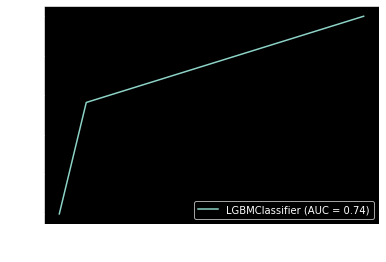

In [ ]:
AucDisp(light_gbm_opt)

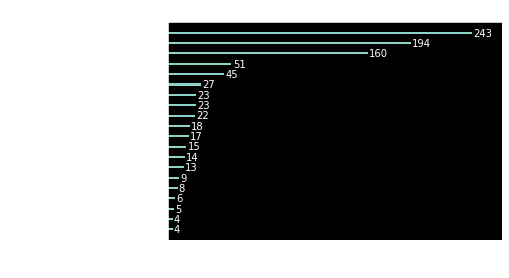

In [ ]:
# оценим важность признаков для этой модели
lgb.plot_importance(light_gbm_opt,
                    height = 0.2,
                    title = 'LGBM Feature importance',
                    xlabel = 'Feature importance',
                    ylabel='Features',
                    importance_type ='auto',
                    grid = False,
                    precision = 3);

<a name = correction5></n>

LightGbm  для определения ухода клиента в большей степени полагается на его траты (monthly_charges, total_charges), тип интернета и способ оплаты услуг, но также использует и признак client_period, который не использовали другие модели

In [ ]:
light_gbm_feature_importances = pd.DataFrame({'Importances' : light_gbm_opt.feature_importances_,
                                              'Features' : X}
)


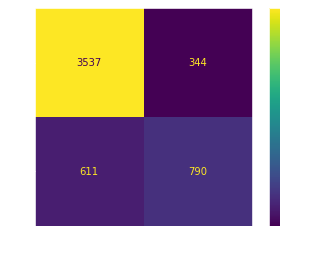

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(light_gbm_opt)

Несмотря на то, что метрика значительно увеличилась, мы видим что увеличение произошло исключительно за счет 0 класса, а способность находить 1 не изменилась

### Нейронная сеть


In [ ]:
# переводим данные в тензоры
X_train = torch.tensor(train[X].to_numpy(), dtype = torch.float32)
y_train = torch.tensor(np.array(train[y]), dtype = torch.float32)

# Проверка размерностей
print(f'''
Train features shape: {X_train.shape}
Train target shape: {y_train.shape}''')


Train features shape: torch.Size([5282, 21])
Train target shape: torch.Size([5282])


In [ ]:
# инициируем полносвязную нейронную сеть с дропаутом
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob = 0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(p = dropout_prob))

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
            )


        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size2, output_size),
            nn.Sigmoid()
            )


    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [ ]:
# Параметры нейронной сети
input_size = len(X)  # Размер входных данных
hidden_size1 = 128  # Размер скрытого слоя
hidden_size2 = 512
output_size = 1

In [ ]:
# Инициализация нейронной сети, функции потерь и оптимизатора
model = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# выведем архитектуру модели
summary(model , input_size = (X_train.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,816
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                  [-1, 512]          66,048
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                    [-1, 1]             513
           Sigmoid-8                    [-1, 1]               0
Total params: 69,377
Trainable params: 69,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.26
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [ ]:
# Обучение нейронной сети
num_epochs = 2500
for epoch in range(num_epochs):

    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# получаем предсказания
with torch.no_grad():
    model.eval()
    predictions = model(X_train)
    probabilities = predictions.numpy()# вероятности принадлежности к классу 1

Epoch [100/2500], Loss: 0.5357
Epoch [200/2500], Loss: 0.5185
Epoch [300/2500], Loss: 0.4998
Epoch [400/2500], Loss: 0.4852
Epoch [500/2500], Loss: 0.4785
Epoch [600/2500], Loss: 0.4684
Epoch [700/2500], Loss: 0.4628
Epoch [800/2500], Loss: 0.4619
Epoch [900/2500], Loss: 0.4560
Epoch [1000/2500], Loss: 0.4564
Epoch [1100/2500], Loss: 0.4541
Epoch [1200/2500], Loss: 0.4510
Epoch [1300/2500], Loss: 0.4501
Epoch [1400/2500], Loss: 0.4524
Epoch [1500/2500], Loss: 0.4482
Epoch [1600/2500], Loss: 0.4523
Epoch [1700/2500], Loss: 0.4423
Epoch [1800/2500], Loss: 0.4425
Epoch [1900/2500], Loss: 0.4452
Epoch [2000/2500], Loss: 0.4448
Epoch [2100/2500], Loss: 0.4442
Epoch [2200/2500], Loss: 0.4421
Epoch [2300/2500], Loss: 0.4432
Epoch [2400/2500], Loss: 0.4418
Epoch [2500/2500], Loss: 0.4420


In [ ]:
# переведем вероятности в метки классов
preds = (probabilities > 0.5).astype('int')

# посчитаем метрику roc_auc
simple_nn_auc = roc_auc_score(y_train, probabilities)
print (f'''Значение метрики roc_auc нейронной сети на валидационной выборке {simple_nn_auc}''')

Значение метрики roc_auc нейронной сети на валидационной выборке 0.8384237452506133


In [ ]:
# сохраним результат
auc_scores.append({simple_nn_auc})
models.append('Neural Net with dropout')

### Сравнительный анализ работы моделей


In [ ]:
# отобразим все результаты в датафрейме
result_origin = pd.DataFrame({'model': models,
                              'roc_auc_score' : auc_scores})

result_origin

,model,roc_auc_score
0,RandomForest(basic),0.826395
1,RandomForest(grid_search),{0.8406166019029121}
2,CatBoost(basic),{0.8369142685994566}
3,Catboost(Optuna),{0.8332034580532511}
4,LightGBM(basic),{0.8218423052563462}
5,LightGBM(Optuna),{0.8454539389303436}
6,Neural Net with dropout,{0.8384237452506133}


На основе проделанной работы нам не удалось достичь требуемых показателей roc auc score, вместо требуемого уровня 0.85 мы имеем только 0.82.
Мной были использованы следующие модели:
- RandomForest
- CatBoost
- LightGBM
- Полносвязная нейронная сеть с дропаутом.
Для каждой модели я подбирала гиперпараметры, но метрику улучшить до требуемого значения так и не удалось.
В результате лучший результ показали 3 модели:

|Модель | Значение метрики |
|---------------------|-------|
|  CatBoost(basic)      | 0.837  
|   LightGBM (Optuna)          | 0.844
| Neural net          | 0.839

CatBoost показал результаты хуже других, что удивительно, оптимизация гиперпараметров несущественно повлияла.

## Генерация новых признаков

Объединим все значения важности признаков и найдем самые важные признаки для моделей, чтобы на их основе составить новые

In [ ]:
important_features = pd.concat([
    rf_feature_importance.sort_values(by ='Importances', ascending = False).head(10),
    catboost_feature_importance.sort_values(by ='Importances', ascending = False).head(10),
    light_gbm_feature_importances.sort_values(by = 'Importances', ascending = False).head(10)])\
                    .groupby('Features')['Importances'].sum()
# выведем признаки с наибольшей важностью для всех моделей
important_features.sort_values(ascending = False)

Features
total_charges                   283.663088
monthly_charges                 218.290193
client_period                   176.944471
type_enc                        110.081256
payment_method_enc               53.699459
senior_citizen                   27.000000
paperless_billing                26.640085
streaming_tv                     23.000000
online_security                  22.000000
tech_support                     20.049257
internet_service_Fiber optic     16.993469
internet_service_DSL              3.474037
multiple_lines                    3.096900
internet_service_No               1.253349
Name: Importances, dtype: float64

На основе самых важных исходных признаков составим новые:
- total_services: сумма всех услуг клиента
- mean_monthly_spending: средниие траты в месяц
- service_per_period: сколько сервисом клиент оформил за период



In [ ]:
train.columns

Index(['paperless_billing', 'monthly_charges', 'total_charges',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'churn', 'internet_service_DSL',
       'internet_service_Fiber optic', 'internet_service_No', 'gender_Female',
       'gender_Male', 'client_period', 'type_enc', 'payment_method_enc'],
      dtype='object')

In [ ]:
# функция для создания новых признаков
def make_new_data(data):

    data = data.copy()

    #признаки на основе которых получим total_services
    columns_to_sum = ['online_security',
                      'online_backup',
                      'device_protection',
                      'tech_support',
                      'streaming_tv',
                      'streaming_movies',
                      'multiple_lines',
                      'internet_service_DSL',
                      'internet_service_Fiber optic']
     # 1
    data['total_services'] = data[columns_to_sum].sum(axis = 1)
    # заменим нулевые значения чтобы не было ошибок при делении
    data.loc[data['total_services'] == 0, 'total_services'] = data.loc[data['total_services'] == 0, 'total_services'] = 0.01

    data.loc[data['client_period'] == 0, 'client_period'] = data.loc[data['client_period'] == 0, 'client_period'] = 0.01
    # 2
    #считаем среднее значение месячных трат
    data['mean_monthly_spending'] = data['monthly_charges'] / (data['client_period']/30)
     # заменим нулевые значения чтобы не было ошибок при делении
    data.loc[data['total_charges'] == 0, 'total_charges'] = data.loc[data['total_charges'] == 0, 'total_charges'] = 0.01

    # 3
    # сколько серввисом оформили за весь период
    data['cost_per_service'] = data['total_services'] / data['total_charges']


    return data

In [ ]:
train_new = make_new_data(train)
test_new = make_new_data(test)

In [ ]:
X_new = train_new.drop('churn', axis = 1).columns.to_list()
y_new = 'churn'

In [ ]:
light_gbm_opt.fit(train_new[X_new], train[y_new])

[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541


LGBMClassifier(bagging_fraction=0.5026845431932541, bagging_freq=1,
               lambda_l1=8.752655495416343, lambda_l2=4.311732423099294,
               learning_rate=0.08662671415672688, min_child_samples=93,
               num_leaves=97)

In [ ]:
#оценим дефолтные значения
scores = cross_val_score(light_gbm_opt,
                         train_new[X_new],
                         train_new[y_new],
                         cv = 5,
                         scoring = 'roc_auc')
scores_lgbm_new = scores.mean()
print (f'''Среднее значение roc_auc для модели LightGbm(new features): {scores_lgbm_new : 0.4f}''')

[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541
[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: 

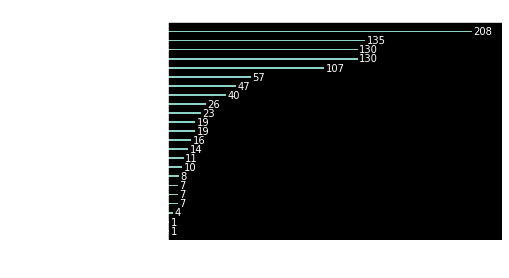

In [ ]:
# оценим важность признаков для этой модели
lgb.plot_importance(light_gbm_opt,
                    height = 0.2,
                    title = 'LGBM Feature importance',
                    xlabel = 'Feature importance',
                    ylabel='Features',
                    importance_type ='auto',
                    grid = False,
                    precision = 3);

In [ ]:
lgbm = light_gbm_opt.fit(train_new[X_new],
                         train_new[y_new])

[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541


In [ ]:
# посмотрим результат
roc_auc_score(y_train.numpy(), preds)

0.73430037917849

In [ ]:
# создаем параметры для поиска оптуной
def objective(trial):

    param = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'num_leaves': trial.suggest_int('num_leaves', 32, 256),
    'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.1),
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    clf = lgb.LGBMClassifier(**param)  # Передаем параметры как именованные аргументы

    scores = cross_val_score(clf,
                      train_new[X],
                      train_new[y],
                      cv=3,
                      scoring='roc_auc')

    return scores.mean()
# инициализируем обучение
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100)

[I 2023-12-23 12:49:16,479] A new study created in memory with name: no-name-45265f75-8c11-48c3-94ac-2dc1084c3d0e


[LightGBM] [Warning] bagging_fraction is set=0.747608726242756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.747608726242756
[LightGBM] [Warning] lambda_l2 is set=3.3886928681875945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3886928681875945
[LightGBM] [Warning] lambda_l1 is set=4.002543844236143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.002543844236143
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.747608726242756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.747608726242756
[LightGBM] [Warning] lambda_l2 is set=3.3886928681875945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3886928681875945
[LightGBM] [Warning] lambda_l1 is set=4.002543844236143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.002543844236143
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:49:19,572] Trial 0 finished with value: 0.8426752038227332 and parameters: {'num_leaves': 238, 'learning_rate': 0.038945665527574384, 'boosting_type': 'gbdt', 'lambda_l1': 4.002543844236143, 'lambda_l2': 3.3886928681875945, 'bagging_fraction': 0.747608726242756, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 0 with value: 0.8426752038227332.


[LightGBM] [Warning] bagging_fraction is set=0.8529011292239821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529011292239821
[LightGBM] [Warning] lambda_l2 is set=8.929423092368657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.929423092368657
[LightGBM] [Warning] lambda_l1 is set=4.703953728547225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.703953728547225
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8529011292239821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8529011292239821
[LightGBM] [Warning] lambda_l2 is set=8.929423092368657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.929423092368657
[LightGBM] [Warning] lambda_l1 is set=4.703953728547225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.703953728547225
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:49:23,379] Trial 1 finished with value: 0.8404977017552646 and parameters: {'num_leaves': 129, 'learning_rate': 0.05039531660176562, 'boosting_type': 'dart', 'lambda_l1': 4.703953728547225, 'lambda_l2': 8.929423092368657, 'bagging_fraction': 0.8529011292239821, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 0 with value: 0.8426752038227332.


[LightGBM] [Warning] bagging_fraction is set=0.4036801129000013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4036801129000013
[LightGBM] [Warning] lambda_l2 is set=9.58631728738109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.58631728738109
[LightGBM] [Warning] lambda_l1 is set=1.2820440652657954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2820440652657954
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4036801129000013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4036801129000013
[LightGBM] [Warning] lambda_l2 is set=9.58631728738109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.58631728738109
[LightGBM] [Warning] lambda_l1 is set=1.2820440652657954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2820440652657954
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ign

[I 2023-12-23 12:49:25,673] Trial 2 finished with value: 0.8430323873993113 and parameters: {'num_leaves': 99, 'learning_rate': 0.06765682318547818, 'boosting_type': 'gbdt', 'lambda_l1': 1.2820440652657954, 'lambda_l2': 9.58631728738109, 'bagging_fraction': 0.4036801129000013, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 2 with value: 0.8430323873993113.


[LightGBM] [Warning] bagging_fraction is set=0.9094638976175262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9094638976175262
[LightGBM] [Warning] lambda_l2 is set=7.917496950482641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.917496950482641
[LightGBM] [Warning] lambda_l1 is set=0.7497374882644068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7497374882644068
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9094638976175262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9094638976175262
[LightGBM] [Warning] lambda_l2 is set=7.917496950482641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.917496950482641
[LightGBM] [Warning] lambda_l1 is set=0.7497374882644068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7497374882644068
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be

[I 2023-12-23 12:49:30,374] Trial 3 finished with value: 0.8411150381834142 and parameters: {'num_leaves': 247, 'learning_rate': 0.049062425907831345, 'boosting_type': 'dart', 'lambda_l1': 0.7497374882644068, 'lambda_l2': 7.917496950482641, 'bagging_fraction': 0.9094638976175262, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 2 with value: 0.8430323873993113.


[LightGBM] [Warning] bagging_fraction is set=0.7628819588299189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7628819588299189
[LightGBM] [Warning] lambda_l2 is set=5.290649360473422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.290649360473422
[LightGBM] [Warning] lambda_l1 is set=6.144408623119161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.144408623119161
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7628819588299189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7628819588299189
[LightGBM] [Warning] lambda_l2 is set=5.290649360473422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.290649360473422
[LightGBM] [Warning] lambda_l1 is set=6.144408623119161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.144408623119161
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ign

[I 2023-12-23 12:49:33,173] Trial 4 finished with value: 0.8420908038836975 and parameters: {'num_leaves': 147, 'learning_rate': 0.05810819086566605, 'boosting_type': 'dart', 'lambda_l1': 6.144408623119161, 'lambda_l2': 5.290649360473422, 'bagging_fraction': 0.7628819588299189, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 2 with value: 0.8430323873993113.


[LightGBM] [Warning] bagging_fraction is set=0.9453575653063353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9453575653063353
[LightGBM] [Warning] lambda_l2 is set=1.756407283001259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.756407283001259
[LightGBM] [Warning] lambda_l1 is set=7.0135778367294845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.0135778367294845
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9453575653063353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9453575653063353
[LightGBM] [Warning] lambda_l2 is set=1.756407283001259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.756407283001259
[LightGBM] [Warning] lambda_l1 is set=7.0135778367294845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.0135778367294845
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:49:35,574] Trial 5 finished with value: 0.8242328012132317 and parameters: {'num_leaves': 208, 'learning_rate': 0.08629924835621004, 'boosting_type': 'rf', 'lambda_l1': 7.0135778367294845, 'lambda_l2': 1.756407283001259, 'bagging_fraction': 0.9453575653063353, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 2 with value: 0.8430323873993113.


[LightGBM] [Warning] bagging_fraction is set=0.5962012951189456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5962012951189456
[LightGBM] [Warning] lambda_l2 is set=5.792219740080302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.792219740080302
[LightGBM] [Warning] lambda_l1 is set=6.296574962778338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.296574962778338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5962012951189456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5962012951189456
[LightGBM] [Warning] lambda_l2 is set=5.792219740080302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.792219740080302
[LightGBM] [Warning] lambda_l1 is set=6.296574962778338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.296574962778338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:49:37,574] Trial 6 finished with value: 0.8293888020950511 and parameters: {'num_leaves': 146, 'learning_rate': 0.08238503099422775, 'boosting_type': 'rf', 'lambda_l1': 6.296574962778338, 'lambda_l2': 5.792219740080302, 'bagging_fraction': 0.5962012951189456, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 2 with value: 0.8430323873993113.


[LightGBM] [Warning] bagging_fraction is set=0.7913721818951084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7913721818951084
[LightGBM] [Warning] lambda_l2 is set=1.1956956238516039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1956956238516039
[LightGBM] [Warning] lambda_l1 is set=5.387770523862418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.387770523862418
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7913721818951084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7913721818951084
[LightGBM] [Warning] lambda_l2 is set=1.1956956238516039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1956956238516039
[LightGBM] [Warning] lambda_l1 is set=5.387770523862418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.387770523862418
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be

[I 2023-12-23 12:49:43,666] Trial 7 finished with value: 0.841044130163476 and parameters: {'num_leaves': 88, 'learning_rate': 0.06782245730755192, 'boosting_type': 'dart', 'lambda_l1': 5.387770523862418, 'lambda_l2': 1.1956956238516039, 'bagging_fraction': 0.7913721818951084, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 2 with value: 0.8430323873993113.


[LightGBM] [Warning] bagging_fraction is set=0.462980569905914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.462980569905914
[LightGBM] [Warning] lambda_l2 is set=7.318258196468552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.318258196468552
[LightGBM] [Warning] lambda_l1 is set=2.618383011043234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.618383011043234
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.462980569905914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.462980569905914
[LightGBM] [Warning] lambda_l2 is set=7.318258196468552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.318258196468552
[LightGBM] [Warning] lambda_l1 is set=2.618383011043234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.618383011043234
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored

[I 2023-12-23 12:49:45,778] Trial 8 finished with value: 0.8431182139033514 and parameters: {'num_leaves': 163, 'learning_rate': 0.03298200177464779, 'boosting_type': 'gbdt', 'lambda_l1': 2.618383011043234, 'lambda_l2': 7.318258196468552, 'bagging_fraction': 0.462980569905914, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.7723059740238551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723059740238551
[LightGBM] [Warning] lambda_l2 is set=7.363762322513793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.363762322513793
[LightGBM] [Warning] lambda_l1 is set=9.749868117474353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.749868117474353
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7723059740238551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723059740238551
[LightGBM] [Warning] lambda_l2 is set=7.363762322513793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.363762322513793
[LightGBM] [Warning] lambda_l1 is set=9.749868117474353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.749868117474353
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ign

[I 2023-12-23 12:49:48,672] Trial 9 finished with value: 0.8159925854784196 and parameters: {'num_leaves': 162, 'learning_rate': 0.07433851744735047, 'boosting_type': 'rf', 'lambda_l1': 9.749868117474353, 'lambda_l2': 7.363762322513793, 'bagging_fraction': 0.7723059740238551, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.5663755933857301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5663755933857301
[LightGBM] [Warning] lambda_l2 is set=3.580964741917902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.580964741917902
[LightGBM] [Warning] lambda_l1 is set=2.7035966043806137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7035966043806137
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5663755933857301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5663755933857301
[LightGBM] [Warning] lambda_l2 is set=3.580964741917902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.580964741917902
[LightGBM] [Warning] lambda_l1 is set=2.7035966043806137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7035966043806137
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be

[I 2023-12-23 12:49:50,572] Trial 10 finished with value: 0.834241699225117 and parameters: {'num_leaves': 36, 'learning_rate': 0.007010747734776203, 'boosting_type': 'gbdt', 'lambda_l1': 2.7035966043806137, 'lambda_l2': 3.580964741917902, 'bagging_fraction': 0.5663755933857301, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.4256452223361183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4256452223361183
[LightGBM] [Warning] lambda_l2 is set=9.679102896825002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.679102896825002
[LightGBM] [Warning] lambda_l1 is set=0.06870244215286858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06870244215286858
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4256452223361183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4256452223361183
[LightGBM] [Warning] lambda_l2 is set=9.679102896825002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.679102896825002
[LightGBM] [Warning] lambda_l1 is set=0.06870244215286858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06870244215286858
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 wil

[I 2023-12-23 12:49:52,972] Trial 11 finished with value: 0.8424910917260576 and parameters: {'num_leaves': 91, 'learning_rate': 0.02688795532846681, 'boosting_type': 'gbdt', 'lambda_l1': 0.06870244215286858, 'lambda_l2': 9.679102896825002, 'bagging_fraction': 0.4256452223361183, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.40027935234077583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40027935234077583
[LightGBM] [Warning] lambda_l2 is set=7.434200553598929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.434200553598929
[LightGBM] [Warning] lambda_l1 is set=2.312731003971789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.312731003971789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.40027935234077583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40027935234077583
[LightGBM] [Warning] lambda_l2 is set=7.434200553598929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.434200553598929
[LightGBM] [Warning] lambda_l1 is set=2.312731003971789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.312731003971789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be

[I 2023-12-23 12:49:55,376] Trial 12 finished with value: 0.8424351235206243 and parameters: {'num_leaves': 183, 'learning_rate': 0.023022266848342583, 'boosting_type': 'gbdt', 'lambda_l1': 2.312731003971789, 'lambda_l2': 7.434200553598929, 'bagging_fraction': 0.40027935234077583, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.5126989786397322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5126989786397322
[LightGBM] [Warning] lambda_l2 is set=9.944115218689316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.944115218689316
[LightGBM] [Warning] lambda_l1 is set=2.0741546759224967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0741546759224967
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5126989786397322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5126989786397322
[LightGBM] [Warning] lambda_l2 is set=9.944115218689316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.944115218689316
[LightGBM] [Warning] lambda_l1 is set=2.0741546759224967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0741546759224967
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be

[I 2023-12-23 12:49:57,677] Trial 13 finished with value: 0.8423302024661151 and parameters: {'num_leaves': 103, 'learning_rate': 0.030091745179269682, 'boosting_type': 'gbdt', 'lambda_l1': 2.0741546759224967, 'lambda_l2': 9.944115218689316, 'bagging_fraction': 0.5126989786397322, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.4925047131285838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4925047131285838
[LightGBM] [Warning] lambda_l2 is set=6.638648526497027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.638648526497027
[LightGBM] [Warning] lambda_l1 is set=3.488030333729844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.488030333729844
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4925047131285838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4925047131285838
[LightGBM] [Warning] lambda_l2 is set=6.638648526497027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.638648526497027
[LightGBM] [Warning] lambda_l1 is set=3.488030333729844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.488030333729844
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:50:00,578] Trial 14 finished with value: 0.8379042184277807 and parameters: {'num_leaves': 35, 'learning_rate': 0.09627913268223429, 'boosting_type': 'gbdt', 'lambda_l1': 3.488030333729844, 'lambda_l2': 6.638648526497027, 'bagging_fraction': 0.4925047131285838, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.605665929889431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605665929889431
[LightGBM] [Warning] lambda_l2 is set=8.560732405882892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.560732405882892
[LightGBM] [Warning] lambda_l1 is set=1.5933700126029173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5933700126029173
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.605665929889431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.605665929889431
[LightGBM] [Warning] lambda_l2 is set=8.560732405882892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.560732405882892
[LightGBM] [Warning] lambda_l1 is set=1.5933700126029173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5933700126029173
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ign

[I 2023-12-23 12:50:03,576] Trial 15 finished with value: 0.8321377422553526 and parameters: {'num_leaves': 64, 'learning_rate': 0.0014574339527990074, 'boosting_type': 'gbdt', 'lambda_l1': 1.5933700126029173, 'lambda_l2': 8.560732405882892, 'bagging_fraction': 0.605665929889431, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.6714131636586713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6714131636586713
[LightGBM] [Warning] lambda_l2 is set=4.1055607164622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1055607164622
[LightGBM] [Warning] lambda_l1 is set=0.8317687658628738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8317687658628738
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6714131636586713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6714131636586713
[LightGBM] [Warning] lambda_l2 is set=4.1055607164622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1055607164622
[LightGBM] [Warning] lambda_l1 is set=0.8317687658628738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8317687658628738
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored

[I 2023-12-23 12:50:07,067] Trial 16 finished with value: 0.8377468661753215 and parameters: {'num_leaves': 120, 'learning_rate': 0.06116330356945225, 'boosting_type': 'gbdt', 'lambda_l1': 0.8317687658628738, 'lambda_l2': 4.1055607164622, 'bagging_fraction': 0.6714131636586713, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.48407320179668173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48407320179668173
[LightGBM] [Warning] lambda_l2 is set=6.419343013347952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.419343013347952
[LightGBM] [Warning] lambda_l1 is set=3.4359761102411044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4359761102411044
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.48407320179668173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48407320179668173
[LightGBM] [Warning] lambda_l2 is set=6.419343013347952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.419343013347952
[LightGBM] [Warning] lambda_l1 is set=3.4359761102411044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4359761102411044
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 wil

[I 2023-12-23 12:50:09,069] Trial 17 finished with value: 0.8425853512050613 and parameters: {'num_leaves': 194, 'learning_rate': 0.041441031230258656, 'boosting_type': 'gbdt', 'lambda_l1': 3.4359761102411044, 'lambda_l2': 6.419343013347952, 'bagging_fraction': 0.48407320179668173, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.6648560603492584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6648560603492584
[LightGBM] [Warning] lambda_l2 is set=8.410990082864169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.410990082864169
[LightGBM] [Warning] lambda_l1 is set=7.924715059171206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.924715059171206
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6648560603492584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6648560603492584
[LightGBM] [Warning] lambda_l2 is set=8.410990082864169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.410990082864169
[LightGBM] [Warning] lambda_l1 is set=7.924715059171206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.924715059171206
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:50:11,169] Trial 18 finished with value: 0.8387562485912815 and parameters: {'num_leaves': 168, 'learning_rate': 0.014530790814134855, 'boosting_type': 'gbdt', 'lambda_l1': 7.924715059171206, 'lambda_l2': 8.410990082864169, 'bagging_fraction': 0.6648560603492584, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.4568556825765736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4568556825765736
[LightGBM] [Warning] lambda_l2 is set=0.13343296401648352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13343296401648352
[LightGBM] [Warning] lambda_l1 is set=1.3465638362923973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3465638362923973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4568556825765736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4568556825765736
[LightGBM] [Warning] lambda_l2 is set=0.13343296401648352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13343296401648352
[LightGBM] [Warning] lambda_l1 is set=1.3465638362923973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3465638362923973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0

[I 2023-12-23 12:50:14,477] Trial 19 finished with value: 0.8377608651057349 and parameters: {'num_leaves': 70, 'learning_rate': 0.038761561365128865, 'boosting_type': 'rf', 'lambda_l1': 1.3465638362923973, 'lambda_l2': 0.13343296401648352, 'bagging_fraction': 0.4568556825765736, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.5445994557410245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5445994557410245
[LightGBM] [Warning] lambda_l2 is set=9.19682240187936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.19682240187936
[LightGBM] [Warning] lambda_l1 is set=2.6683463518336765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6683463518336765
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5445994557410245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5445994557410245
[LightGBM] [Warning] lambda_l2 is set=9.19682240187936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.19682240187936
[LightGBM] [Warning] lambda_l1 is set=2.6683463518336765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6683463518336765
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ign

[I 2023-12-23 12:50:16,871] Trial 20 finished with value: 0.8428946691432221 and parameters: {'num_leaves': 214, 'learning_rate': 0.07030960622403835, 'boosting_type': 'gbdt', 'lambda_l1': 2.6683463518336765, 'lambda_l2': 9.19682240187936, 'bagging_fraction': 0.5445994557410245, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.544071349652896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.544071349652896
[LightGBM] [Warning] lambda_l2 is set=9.213773955903665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.213773955903665
[LightGBM] [Warning] lambda_l1 is set=2.4733544178530256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4733544178530256
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.544071349652896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.544071349652896
[LightGBM] [Warning] lambda_l2 is set=9.213773955903665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.213773955903665
[LightGBM] [Warning] lambda_l1 is set=2.4733544178530256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4733544178530256
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ign

[I 2023-12-23 12:50:19,174] Trial 21 finished with value: 0.8419885962697982 and parameters: {'num_leaves': 211, 'learning_rate': 0.07360811969069386, 'boosting_type': 'gbdt', 'lambda_l1': 2.4733544178530256, 'lambda_l2': 9.213773955903665, 'bagging_fraction': 0.544071349652896, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 8 with value: 0.8431182139033514.


[LightGBM] [Warning] bagging_fraction is set=0.44612726765842214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44612726765842214
[LightGBM] [Warning] lambda_l2 is set=8.120467504758684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.120467504758684
[LightGBM] [Warning] lambda_l1 is set=3.1552889534319464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1552889534319464
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.44612726765842214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44612726765842214
[LightGBM] [Warning] lambda_l2 is set=8.120467504758684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.120467504758684
[LightGBM] [Warning] lambda_l1 is set=3.1552889534319464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1552889534319464
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 wil

[I 2023-12-23 12:50:21,369] Trial 22 finished with value: 0.8432475778936651 and parameters: {'num_leaves': 224, 'learning_rate': 0.06048180057391024, 'boosting_type': 'gbdt', 'lambda_l1': 3.1552889534319464, 'lambda_l2': 8.120467504758684, 'bagging_fraction': 0.44612726765842214, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 22 with value: 0.8432475778936651.


[LightGBM] [Warning] bagging_fraction is set=0.44732346798307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44732346798307815
[LightGBM] [Warning] lambda_l2 is set=7.0171011909893535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0171011909893535
[LightGBM] [Warning] lambda_l1 is set=4.3175076122679865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3175076122679865
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.44732346798307815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44732346798307815
[LightGBM] [Warning] lambda_l2 is set=7.0171011909893535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0171011909893535
[LightGBM] [Warning] lambda_l1 is set=4.3175076122679865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3175076122679865
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0

[I 2023-12-23 12:50:23,476] Trial 23 finished with value: 0.8427040273834736 and parameters: {'num_leaves': 120, 'learning_rate': 0.0603383944846428, 'boosting_type': 'gbdt', 'lambda_l1': 4.3175076122679865, 'lambda_l2': 7.0171011909893535, 'bagging_fraction': 0.44732346798307815, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 22 with value: 0.8432475778936651.


[LightGBM] [Warning] bagging_fraction is set=0.41161085666252567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41161085666252567
[LightGBM] [Warning] lambda_l2 is set=7.877390693229701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.877390693229701
[LightGBM] [Warning] lambda_l1 is set=3.203007524993559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203007524993559
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.41161085666252567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41161085666252567
[LightGBM] [Warning] lambda_l2 is set=7.877390693229701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.877390693229701
[LightGBM] [Warning] lambda_l1 is set=3.203007524993559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203007524993559
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be

[I 2023-12-23 12:50:25,684] Trial 24 finished with value: 0.8437521270411589 and parameters: {'num_leaves': 167, 'learning_rate': 0.04639351152953768, 'boosting_type': 'gbdt', 'lambda_l1': 3.203007524993559, 'lambda_l2': 7.877390693229701, 'bagging_fraction': 0.41161085666252567, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 24 with value: 0.8437521270411589.


[LightGBM] [Warning] bagging_fraction is set=0.4648614909843724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4648614909843724
[LightGBM] [Warning] lambda_l2 is set=6.108490788434846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.108490788434846
[LightGBM] [Warning] lambda_l1 is set=3.5524125922206107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5524125922206107
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4648614909843724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4648614909843724
[LightGBM] [Warning] lambda_l2 is set=6.108490788434846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.108490788434846
[LightGBM] [Warning] lambda_l1 is set=3.5524125922206107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5524125922206107
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be

[I 2023-12-23 12:50:27,972] Trial 25 finished with value: 0.8437963558458055 and parameters: {'num_leaves': 231, 'learning_rate': 0.0445433800906277, 'boosting_type': 'gbdt', 'lambda_l1': 3.5524125922206107, 'lambda_l2': 6.108490788434846, 'bagging_fraction': 0.4648614909843724, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.6254028017899536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6254028017899536
[LightGBM] [Warning] lambda_l2 is set=5.937256158795275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.937256158795275
[LightGBM] [Warning] lambda_l1 is set=5.265421682777951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.265421682777951
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6254028017899536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6254028017899536
[LightGBM] [Warning] lambda_l2 is set=5.937256158795275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.937256158795275
[LightGBM] [Warning] lambda_l1 is set=5.265421682777951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.265421682777951
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:50:30,478] Trial 26 finished with value: 0.8437877756910585 and parameters: {'num_leaves': 232, 'learning_rate': 0.04584998718564219, 'boosting_type': 'gbdt', 'lambda_l1': 5.265421682777951, 'lambda_l2': 5.937256158795275, 'bagging_fraction': 0.6254028017899536, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.6373674941520416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6373674941520416
[LightGBM] [Warning] lambda_l2 is set=4.724006910567069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.724006910567069
[LightGBM] [Warning] lambda_l1 is set=5.286633107713168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.286633107713168
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6373674941520416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6373674941520416
[LightGBM] [Warning] lambda_l2 is set=4.724006910567069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.724006910567069
[LightGBM] [Warning] lambda_l1 is set=5.286633107713168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.286633107713168
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:50:32,973] Trial 27 finished with value: 0.8436729193612779 and parameters: {'num_leaves': 241, 'learning_rate': 0.0459779327875981, 'boosting_type': 'gbdt', 'lambda_l1': 5.286633107713168, 'lambda_l2': 4.724006910567069, 'bagging_fraction': 0.6373674941520416, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.517856324526983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.517856324526983
[LightGBM] [Warning] lambda_l2 is set=5.846894396772781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.846894396772781
[LightGBM] [Warning] lambda_l1 is set=7.624130783755022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.624130783755022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.517856324526983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.517856324526983
[LightGBM] [Warning] lambda_l2 is set=5.846894396772781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.846894396772781
[LightGBM] [Warning] lambda_l1 is set=7.624130783755022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.624130783755022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:50:34,873] Trial 28 finished with value: 0.8267474307322263 and parameters: {'num_leaves': 254, 'learning_rate': 0.053566656511382496, 'boosting_type': 'rf', 'lambda_l1': 7.624130783755022, 'lambda_l2': 5.846894396772781, 'bagging_fraction': 0.517856324526983, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.7271736220130137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7271736220130137
[LightGBM] [Warning] lambda_l2 is set=2.6197346958836905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6197346958836905
[LightGBM] [Warning] lambda_l1 is set=4.239486780135281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.239486780135281
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7271736220130137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7271736220130137
[LightGBM] [Warning] lambda_l2 is set=2.6197346958836905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6197346958836905
[LightGBM] [Warning] lambda_l1 is set=4.239486780135281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.239486780135281
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:50:38,275] Trial 29 finished with value: 0.8414591820578176 and parameters: {'num_leaves': 226, 'learning_rate': 0.039811822214395, 'boosting_type': 'dart', 'lambda_l1': 4.239486780135281, 'lambda_l2': 2.6197346958836905, 'bagging_fraction': 0.7271736220130137, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.5849374141717619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5849374141717619
[LightGBM] [Warning] lambda_l2 is set=4.637671472964582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.637671472964582
[LightGBM] [Warning] lambda_l1 is set=5.775685432321869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.775685432321869
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5849374141717619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5849374141717619
[LightGBM] [Warning] lambda_l2 is set=4.637671472964582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.637671472964582
[LightGBM] [Warning] lambda_l1 is set=5.775685432321869, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.775685432321869
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:50:40,869] Trial 30 finished with value: 0.8414321302003792 and parameters: {'num_leaves': 187, 'learning_rate': 0.020523749316034897, 'boosting_type': 'gbdt', 'lambda_l1': 5.775685432321869, 'lambda_l2': 4.637671472964582, 'bagging_fraction': 0.5849374141717619, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.6275678961094456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6275678961094456
[LightGBM] [Warning] lambda_l2 is set=4.750989107628035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.750989107628035
[LightGBM] [Warning] lambda_l1 is set=5.174541468878404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.174541468878404
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6275678961094456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6275678961094456
[LightGBM] [Warning] lambda_l2 is set=4.750989107628035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.750989107628035
[LightGBM] [Warning] lambda_l1 is set=5.174541468878404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.174541468878404
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:50:43,384] Trial 31 finished with value: 0.8435357490832507 and parameters: {'num_leaves': 237, 'learning_rate': 0.04521137005246778, 'boosting_type': 'gbdt', 'lambda_l1': 5.174541468878404, 'lambda_l2': 4.750989107628035, 'bagging_fraction': 0.6275678961094456, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 25 with value: 0.8437963558458055.


[LightGBM] [Warning] bagging_fraction is set=0.6907489216086714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6907489216086714
[LightGBM] [Warning] lambda_l2 is set=5.570366155711599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.570366155711599
[LightGBM] [Warning] lambda_l1 is set=4.7985548831381095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7985548831381095
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6907489216086714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6907489216086714
[LightGBM] [Warning] lambda_l2 is set=5.570366155711599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.570366155711599
[LightGBM] [Warning] lambda_l1 is set=4.7985548831381095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7985548831381095
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:50:46,872] Trial 32 finished with value: 0.8446245512033009 and parameters: {'num_leaves': 241, 'learning_rate': 0.04742898347219506, 'boosting_type': 'gbdt', 'lambda_l1': 4.7985548831381095, 'lambda_l2': 5.570366155711599, 'bagging_fraction': 0.6907489216086714, 'bagging_freq': 2, 'min_child_samples': 74}. Best is trial 32 with value: 0.8446245512033009.


[LightGBM] [Warning] bagging_fraction is set=0.8204646175444726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204646175444726
[LightGBM] [Warning] lambda_l2 is set=5.991284149448153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.991284149448153
[LightGBM] [Warning] lambda_l1 is set=4.506869874873443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.506869874873443
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8204646175444726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204646175444726
[LightGBM] [Warning] lambda_l2 is set=5.991284149448153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.991284149448153
[LightGBM] [Warning] lambda_l1 is set=4.506869874873443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.506869874873443
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:50:53,681] Trial 33 finished with value: 0.8434312030172323 and parameters: {'num_leaves': 230, 'learning_rate': 0.03458559153923727, 'boosting_type': 'gbdt', 'lambda_l1': 4.506869874873443, 'lambda_l2': 5.991284149448153, 'bagging_fraction': 0.8204646175444726, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 32 with value: 0.8446245512033009.


[LightGBM] [Warning] bagging_fraction is set=0.6850266910402748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6850266910402748
[LightGBM] [Warning] lambda_l2 is set=5.442815455857237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.442815455857237
[LightGBM] [Warning] lambda_l1 is set=3.7664971863132273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7664971863132273
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6850266910402748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6850266910402748
[LightGBM] [Warning] lambda_l2 is set=5.442815455857237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.442815455857237
[LightGBM] [Warning] lambda_l1 is set=3.7664971863132273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7664971863132273
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:50:56,568] Trial 34 finished with value: 0.8441566135601141 and parameters: {'num_leaves': 207, 'learning_rate': 0.05336103097921104, 'boosting_type': 'gbdt', 'lambda_l1': 3.7664971863132273, 'lambda_l2': 5.442815455857237, 'bagging_fraction': 0.6850266910402748, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 32 with value: 0.8446245512033009.


[LightGBM] [Warning] bagging_fraction is set=0.7165688395515141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165688395515141
[LightGBM] [Warning] lambda_l2 is set=5.30007769240401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.30007769240401
[LightGBM] [Warning] lambda_l1 is set=4.026347041789746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.026347041789746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7165688395515141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165688395515141
[LightGBM] [Warning] lambda_l2 is set=5.30007769240401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.30007769240401
[LightGBM] [Warning] lambda_l1 is set=4.026347041789746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.026347041789746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:51:00,070] Trial 35 finished with value: 0.8420525245551529 and parameters: {'num_leaves': 251, 'learning_rate': 0.053007969666564556, 'boosting_type': 'dart', 'lambda_l1': 4.026347041789746, 'lambda_l2': 5.30007769240401, 'bagging_fraction': 0.7165688395515141, 'bagging_freq': 1, 'min_child_samples': 72}. Best is trial 32 with value: 0.8446245512033009.


[LightGBM] [Warning] bagging_fraction is set=0.6811543788022651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811543788022651
[LightGBM] [Warning] lambda_l2 is set=3.6587946457418568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6587946457418568
[LightGBM] [Warning] lambda_l1 is set=6.6995262458988005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6995262458988005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6811543788022651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811543788022651
[LightGBM] [Warning] lambda_l2 is set=3.6587946457418568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6587946457418568
[LightGBM] [Warning] lambda_l1 is set=6.6995262458988005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6995262458988005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 wil

[I 2023-12-23 12:51:02,671] Trial 36 finished with value: 0.8445787104600733 and parameters: {'num_leaves': 197, 'learning_rate': 0.05513536122012382, 'boosting_type': 'gbdt', 'lambda_l1': 6.6995262458988005, 'lambda_l2': 3.6587946457418568, 'bagging_fraction': 0.6811543788022651, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 32 with value: 0.8446245512033009.


[LightGBM] [Warning] bagging_fraction is set=0.6849409484174768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849409484174768
[LightGBM] [Warning] lambda_l2 is set=2.7352233752264627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7352233752264627
[LightGBM] [Warning] lambda_l1 is set=6.779121791235809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.779121791235809
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6849409484174768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849409484174768
[LightGBM] [Warning] lambda_l2 is set=2.7352233752264627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7352233752264627
[LightGBM] [Warning] lambda_l1 is set=6.779121791235809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.779121791235809
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:51:05,269] Trial 37 finished with value: 0.8449168090848639 and parameters: {'num_leaves': 200, 'learning_rate': 0.052554306778238385, 'boosting_type': 'gbdt', 'lambda_l1': 6.779121791235809, 'lambda_l2': 2.7352233752264627, 'bagging_fraction': 0.6849409484174768, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6743126917173254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6743126917173254
[LightGBM] [Warning] lambda_l2 is set=3.2755402630170907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2755402630170907
[LightGBM] [Warning] lambda_l1 is set=6.857740500619105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.857740500619105
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6743126917173254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6743126917173254
[LightGBM] [Warning] lambda_l2 is set=3.2755402630170907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2755402630170907
[LightGBM] [Warning] lambda_l1 is set=6.857740500619105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.857740500619105
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:51:08,371] Trial 38 finished with value: 0.8427520504402676 and parameters: {'num_leaves': 202, 'learning_rate': 0.053418701464560105, 'boosting_type': 'dart', 'lambda_l1': 6.857740500619105, 'lambda_l2': 3.2755402630170907, 'bagging_fraction': 0.6743126917173254, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6981203377063263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981203377063263
[LightGBM] [Warning] lambda_l2 is set=2.512531802041265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.512531802041265
[LightGBM] [Warning] lambda_l1 is set=8.38826954054957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.38826954054957
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6981203377063263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981203377063263
[LightGBM] [Warning] lambda_l2 is set=2.512531802041265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.512531802041265
[LightGBM] [Warning] lambda_l1 is set=8.38826954054957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.38826954054957
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:51:10,672] Trial 39 finished with value: 0.8287439931739092 and parameters: {'num_leaves': 178, 'learning_rate': 0.06391097772123984, 'boosting_type': 'rf', 'lambda_l1': 8.38826954054957, 'lambda_l2': 2.512531802041265, 'bagging_fraction': 0.6981203377063263, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.8295521963878743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8295521963878743
[LightGBM] [Warning] lambda_l2 is set=3.909748305362201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.909748305362201
[LightGBM] [Warning] lambda_l1 is set=6.680894213635182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.680894213635182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8295521963878743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8295521963878743
[LightGBM] [Warning] lambda_l2 is set=3.909748305362201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.909748305362201
[LightGBM] [Warning] lambda_l1 is set=6.680894213635182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.680894213635182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:51:13,465] Trial 40 finished with value: 0.843129487874737 and parameters: {'num_leaves': 197, 'learning_rate': 0.056506462252042755, 'boosting_type': 'gbdt', 'lambda_l1': 6.680894213635182, 'lambda_l2': 3.909748305362201, 'bagging_fraction': 0.8295521963878743, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.8966603150473443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966603150473443
[LightGBM] [Warning] lambda_l2 is set=5.316041479835114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.316041479835114
[LightGBM] [Warning] lambda_l1 is set=5.997911917301016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.997911917301016
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8966603150473443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966603150473443
[LightGBM] [Warning] lambda_l2 is set=5.316041479835114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.316041479835114
[LightGBM] [Warning] lambda_l1 is set=5.997911917301016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.997911917301016
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:51:16,670] Trial 41 finished with value: 0.8425165900902201 and parameters: {'num_leaves': 213, 'learning_rate': 0.05124667242156312, 'boosting_type': 'gbdt', 'lambda_l1': 5.997911917301016, 'lambda_l2': 5.316041479835114, 'bagging_fraction': 0.8966603150473443, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.9997319580045796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997319580045796
[LightGBM] [Warning] lambda_l2 is set=4.2859010851634824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2859010851634824
[LightGBM] [Warning] lambda_l1 is set=8.936554468084328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.936554468084328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9997319580045796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997319580045796
[LightGBM] [Warning] lambda_l2 is set=4.2859010851634824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2859010851634824
[LightGBM] [Warning] lambda_l1 is set=8.936554468084328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.936554468084328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:51:19,568] Trial 42 finished with value: 0.8429554358361924 and parameters: {'num_leaves': 219, 'learning_rate': 0.03674609671136646, 'boosting_type': 'gbdt', 'lambda_l1': 8.936554468084328, 'lambda_l2': 4.2859010851634824, 'bagging_fraction': 0.9997319580045796, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.7391964753575355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391964753575355
[LightGBM] [Warning] lambda_l2 is set=2.8733448538434034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8733448538434034
[LightGBM] [Warning] lambda_l1 is set=4.924288062314794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.924288062314794
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7391964753575355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391964753575355
[LightGBM] [Warning] lambda_l2 is set=2.8733448538434034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8733448538434034
[LightGBM] [Warning] lambda_l1 is set=4.924288062314794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.924288062314794
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:51:22,585] Trial 43 finished with value: 0.8429754038666788 and parameters: {'num_leaves': 244, 'learning_rate': 0.0652828615664802, 'boosting_type': 'gbdt', 'lambda_l1': 4.924288062314794, 'lambda_l2': 2.8733448538434034, 'bagging_fraction': 0.7391964753575355, 'bagging_freq': 2, 'min_child_samples': 70}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.7810885869877887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810885869877887
[LightGBM] [Warning] lambda_l2 is set=2.020996053198046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.020996053198046
[LightGBM] [Warning] lambda_l1 is set=6.410890832651868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.410890832651868
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7810885869877887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810885869877887
[LightGBM] [Warning] lambda_l2 is set=2.020996053198046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.020996053198046
[LightGBM] [Warning] lambda_l1 is set=6.410890832651868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.410890832651868
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:51:25,773] Trial 44 finished with value: 0.8431036667815719 and parameters: {'num_leaves': 202, 'learning_rate': 0.055989934577805864, 'boosting_type': 'gbdt', 'lambda_l1': 6.410890832651868, 'lambda_l2': 2.020996053198046, 'bagging_fraction': 0.7810885869877887, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.7524018099370827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7524018099370827
[LightGBM] [Warning] lambda_l2 is set=1.2079288867113096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2079288867113096
[LightGBM] [Warning] lambda_l1 is set=7.370154962774562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.370154962774562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7524018099370827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7524018099370827
[LightGBM] [Warning] lambda_l2 is set=1.2079288867113096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2079288867113096
[LightGBM] [Warning] lambda_l1 is set=7.370154962774562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.370154962774562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:51:28,574] Trial 45 finished with value: 0.8402830626518373 and parameters: {'num_leaves': 256, 'learning_rate': 0.04234824070447035, 'boosting_type': 'dart', 'lambda_l1': 7.370154962774562, 'lambda_l2': 1.2079288867113096, 'bagging_fraction': 0.7524018099370827, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6821397955914222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6821397955914222
[LightGBM] [Warning] lambda_l2 is set=3.4247634833541363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4247634833541363
[LightGBM] [Warning] lambda_l1 is set=3.801115399561798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.801115399561798
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6821397955914222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6821397955914222
[LightGBM] [Warning] lambda_l2 is set=3.4247634833541363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4247634833541363
[LightGBM] [Warning] lambda_l1 is set=3.801115399561798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.801115399561798
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 12:51:31,774] Trial 46 finished with value: 0.8425177165488208 and parameters: {'num_leaves': 147, 'learning_rate': 0.049809174524937265, 'boosting_type': 'gbdt', 'lambda_l1': 3.801115399561798, 'lambda_l2': 3.4247634833541363, 'bagging_fraction': 0.6821397955914222, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.7009677943003146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7009677943003146
[LightGBM] [Warning] lambda_l2 is set=5.328004359477889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.328004359477889
[LightGBM] [Warning] lambda_l1 is set=5.6889367927337124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6889367927337124
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7009677943003146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7009677943003146
[LightGBM] [Warning] lambda_l2 is set=5.328004359477889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.328004359477889
[LightGBM] [Warning] lambda_l1 is set=5.6889367927337124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6889367927337124
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be

[I 2023-12-23 12:51:34,475] Trial 47 finished with value: 0.8416909917093321 and parameters: {'num_leaves': 221, 'learning_rate': 0.08274738134187515, 'boosting_type': 'gbdt', 'lambda_l1': 5.6889367927337124, 'lambda_l2': 5.328004359477889, 'bagging_fraction': 0.7009677943003146, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6477688699388506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6477688699388506
[LightGBM] [Warning] lambda_l2 is set=6.533436251838243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.533436251838243
[LightGBM] [Warning] lambda_l1 is set=4.766545552949902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.766545552949902
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6477688699388506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6477688699388506
[LightGBM] [Warning] lambda_l2 is set=6.533436251838243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.533436251838243
[LightGBM] [Warning] lambda_l1 is set=4.766545552949902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.766545552949902
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:51:36,684] Trial 48 finished with value: 0.8277217384994406 and parameters: {'num_leaves': 177, 'learning_rate': 0.030686305717853805, 'boosting_type': 'rf', 'lambda_l1': 4.766545552949902, 'lambda_l2': 6.533436251838243, 'bagging_fraction': 0.6477688699388506, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.8848197929752823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8848197929752823
[LightGBM] [Warning] lambda_l2 is set=4.314974889495197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.314974889495197
[LightGBM] [Warning] lambda_l1 is set=3.786182514634454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786182514634454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8848197929752823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8848197929752823
[LightGBM] [Warning] lambda_l2 is set=4.314974889495197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.314974889495197
[LightGBM] [Warning] lambda_l1 is set=3.786182514634454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786182514634454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:51:40,578] Trial 49 finished with value: 0.8395884367869799 and parameters: {'num_leaves': 189, 'learning_rate': 0.07004274268437216, 'boosting_type': 'gbdt', 'lambda_l1': 3.786182514634454, 'lambda_l2': 4.314974889495197, 'bagging_fraction': 0.8848197929752823, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5927860719240786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5927860719240786
[LightGBM] [Warning] lambda_l2 is set=1.902899472854576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.902899472854576
[LightGBM] [Warning] lambda_l1 is set=6.1522384698935895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1522384698935895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5927860719240786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5927860719240786
[LightGBM] [Warning] lambda_l2 is set=1.902899472854576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.902899472854576
[LightGBM] [Warning] lambda_l1 is set=6.1522384698935895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1522384698935895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be

[I 2023-12-23 12:51:43,069] Trial 50 finished with value: 0.8428044182869195 and parameters: {'num_leaves': 155, 'learning_rate': 0.05782285433176743, 'boosting_type': 'gbdt', 'lambda_l1': 6.1522384698935895, 'lambda_l2': 1.902899472854576, 'bagging_fraction': 0.5927860719240786, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.629755355732649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629755355732649
[LightGBM] [Warning] lambda_l2 is set=6.131753780707846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.131753780707846
[LightGBM] [Warning] lambda_l1 is set=5.5258506503796925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5258506503796925
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.629755355732649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629755355732649
[LightGBM] [Warning] lambda_l2 is set=6.131753780707846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.131753780707846
[LightGBM] [Warning] lambda_l1 is set=5.5258506503796925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5258506503796925
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ign

[I 2023-12-23 12:51:45,473] Trial 51 finished with value: 0.8435670864320256 and parameters: {'num_leaves': 234, 'learning_rate': 0.04831148005503367, 'boosting_type': 'gbdt', 'lambda_l1': 5.5258506503796925, 'lambda_l2': 6.131753780707846, 'bagging_fraction': 0.629755355732649, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.7103889883899496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7103889883899496
[LightGBM] [Warning] lambda_l2 is set=5.489648845454059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489648845454059
[LightGBM] [Warning] lambda_l1 is set=4.64466564839062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.64466564839062
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7103889883899496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7103889883899496
[LightGBM] [Warning] lambda_l2 is set=5.489648845454059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489648845454059
[LightGBM] [Warning] lambda_l1 is set=4.64466564839062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.64466564839062
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:51:48,185] Trial 52 finished with value: 0.8436738331557573 and parameters: {'num_leaves': 207, 'learning_rate': 0.04343176567575017, 'boosting_type': 'gbdt', 'lambda_l1': 4.64466564839062, 'lambda_l2': 5.489648845454059, 'bagging_fraction': 0.7103889883899496, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6506241031946639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6506241031946639
[LightGBM] [Warning] lambda_l2 is set=7.007779548787575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.007779548787575
[LightGBM] [Warning] lambda_l1 is set=7.23700064656459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.23700064656459
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6506241031946639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6506241031946639
[LightGBM] [Warning] lambda_l2 is set=7.007779548787575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.007779548787575
[LightGBM] [Warning] lambda_l1 is set=7.23700064656459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.23700064656459
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored

[I 2023-12-23 12:51:50,675] Trial 53 finished with value: 0.8439632472679457 and parameters: {'num_leaves': 244, 'learning_rate': 0.04864896413018771, 'boosting_type': 'gbdt', 'lambda_l1': 7.23700064656459, 'lambda_l2': 7.007779548787575, 'bagging_fraction': 0.6506241031946639, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6533989498483918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533989498483918
[LightGBM] [Warning] lambda_l2 is set=6.642818122814305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.642818122814305
[LightGBM] [Warning] lambda_l1 is set=8.265196255899152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.265196255899152
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6533989498483918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533989498483918
[LightGBM] [Warning] lambda_l2 is set=6.642818122814305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.642818122814305
[LightGBM] [Warning] lambda_l1 is set=8.265196255899152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.265196255899152
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 12:51:53,375] Trial 54 finished with value: 0.843910186823097 and parameters: {'num_leaves': 220, 'learning_rate': 0.0507155578385913, 'boosting_type': 'gbdt', 'lambda_l1': 8.265196255899152, 'lambda_l2': 6.642818122814305, 'bagging_fraction': 0.6533989498483918, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6570242996990341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6570242996990341
[LightGBM] [Warning] lambda_l2 is set=7.03910144438082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.03910144438082
[LightGBM] [Warning] lambda_l1 is set=9.003328081698523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.003328081698523
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6570242996990341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6570242996990341
[LightGBM] [Warning] lambda_l2 is set=7.03910144438082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.03910144438082
[LightGBM] [Warning] lambda_l1 is set=9.003328081698523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.003328081698523
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 12:51:55,968] Trial 55 finished with value: 0.8436937397546821 and parameters: {'num_leaves': 246, 'learning_rate': 0.06471759768597392, 'boosting_type': 'gbdt', 'lambda_l1': 9.003328081698523, 'lambda_l2': 7.03910144438082, 'bagging_fraction': 0.6570242996990341, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6114732950047093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6114732950047093
[LightGBM] [Warning] lambda_l2 is set=7.414424484860752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.414424484860752
[LightGBM] [Warning] lambda_l1 is set=8.240030929414182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.240030929414182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6114732950047093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6114732950047093
[LightGBM] [Warning] lambda_l2 is set=7.414424484860752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.414424484860752
[LightGBM] [Warning] lambda_l1 is set=8.240030929414182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.240030929414182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:51:58,071] Trial 56 finished with value: 0.8444133991942131 and parameters: {'num_leaves': 218, 'learning_rate': 0.04977099109428716, 'boosting_type': 'gbdt', 'lambda_l1': 8.240030929414182, 'lambda_l2': 7.414424484860752, 'bagging_fraction': 0.6114732950047093, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6144973703385637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6144973703385637
[LightGBM] [Warning] lambda_l2 is set=7.491616430449248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.491616430449248
[LightGBM] [Warning] lambda_l1 is set=7.131938393354491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.131938393354491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6144973703385637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6144973703385637
[LightGBM] [Warning] lambda_l2 is set=7.491616430449248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.491616430449248
[LightGBM] [Warning] lambda_l1 is set=7.131938393354491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.131938393354491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:52:51,069] Trial 57 finished with value: 0.8446039765361434 and parameters: {'num_leaves': 197, 'learning_rate': 0.05522967156618531, 'boosting_type': 'gbdt', 'lambda_l1': 7.131938393354491, 'lambda_l2': 7.491616430449248, 'bagging_fraction': 0.6144973703385637, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6138150623504106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138150623504106
[LightGBM] [Warning] lambda_l2 is set=7.882534831523165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.882534831523165
[LightGBM] [Warning] lambda_l1 is set=9.48485887502093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.48485887502093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6138150623504106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138150623504106
[LightGBM] [Warning] lambda_l2 is set=7.882534831523165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.882534831523165
[LightGBM] [Warning] lambda_l1 is set=9.48485887502093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.48485887502093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 12:53:22,388] Trial 58 finished with value: 0.8444181095871843 and parameters: {'num_leaves': 198, 'learning_rate': 0.05574433404717652, 'boosting_type': 'gbdt', 'lambda_l1': 9.48485887502093, 'lambda_l2': 7.882534831523165, 'bagging_fraction': 0.6138150623504106, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5417401553204927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5417401553204927
[LightGBM] [Warning] lambda_l2 is set=7.8923524523625765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8923524523625765
[LightGBM] [Warning] lambda_l1 is set=9.493435930735188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.493435930735188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5417401553204927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5417401553204927
[LightGBM] [Warning] lambda_l2 is set=7.8923524523625765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.8923524523625765
[LightGBM] [Warning] lambda_l1 is set=9.493435930735188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.493435930735188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 12:53:26,771] Trial 59 finished with value: 0.8262258089431965 and parameters: {'num_leaves': 195, 'learning_rate': 0.06123557327392654, 'boosting_type': 'rf', 'lambda_l1': 9.493435930735188, 'lambda_l2': 7.8923524523625765, 'bagging_fraction': 0.5417401553204927, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5765096424401782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5765096424401782
[LightGBM] [Warning] lambda_l2 is set=7.631162167923422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.631162167923422
[LightGBM] [Warning] lambda_l1 is set=7.915313512367249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.915313512367249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5765096424401782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5765096424401782
[LightGBM] [Warning] lambda_l2 is set=7.631162167923422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.631162167923422
[LightGBM] [Warning] lambda_l1 is set=7.915313512367249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.915313512367249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:53:29,569] Trial 60 finished with value: 0.8444654790804198 and parameters: {'num_leaves': 181, 'learning_rate': 0.05762801347801028, 'boosting_type': 'gbdt', 'lambda_l1': 7.915313512367249, 'lambda_l2': 7.631162167923422, 'bagging_fraction': 0.5765096424401782, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5707337100939968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5707337100939968
[LightGBM] [Warning] lambda_l2 is set=8.759640246774763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.759640246774763
[LightGBM] [Warning] lambda_l1 is set=7.977353460194016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.977353460194016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5707337100939968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5707337100939968
[LightGBM] [Warning] lambda_l2 is set=8.759640246774763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.759640246774763
[LightGBM] [Warning] lambda_l1 is set=7.977353460194016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.977353460194016
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:53:32,178] Trial 61 finished with value: 0.8442757299980513 and parameters: {'num_leaves': 177, 'learning_rate': 0.056743910220851984, 'boosting_type': 'gbdt', 'lambda_l1': 7.977353460194016, 'lambda_l2': 8.759640246774763, 'bagging_fraction': 0.5707337100939968, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6018239681945405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6018239681945405
[LightGBM] [Warning] lambda_l2 is set=7.585873955966875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.585873955966875
[LightGBM] [Warning] lambda_l1 is set=8.857262431971852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.857262431971852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6018239681945405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6018239681945405
[LightGBM] [Warning] lambda_l2 is set=7.585873955966875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.585873955966875
[LightGBM] [Warning] lambda_l1 is set=8.857262431971852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.857262431971852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:53:35,073] Trial 62 finished with value: 0.8441323148178359 and parameters: {'num_leaves': 139, 'learning_rate': 0.060013857493722206, 'boosting_type': 'gbdt', 'lambda_l1': 8.857262431971852, 'lambda_l2': 7.585873955966875, 'bagging_fraction': 0.6018239681945405, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6106155371217823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106155371217823
[LightGBM] [Warning] lambda_l2 is set=8.385886620747613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385886620747613
[LightGBM] [Warning] lambda_l1 is set=9.820113812584854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.820113812584854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6106155371217823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106155371217823
[LightGBM] [Warning] lambda_l2 is set=8.385886620747613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385886620747613
[LightGBM] [Warning] lambda_l1 is set=9.820113812584854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.820113812584854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:53:37,876] Trial 63 finished with value: 0.8446840438312794 and parameters: {'num_leaves': 187, 'learning_rate': 0.07415190594147128, 'boosting_type': 'gbdt', 'lambda_l1': 9.820113812584854, 'lambda_l2': 8.385886620747613, 'bagging_fraction': 0.6106155371217823, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5555413774145728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555413774145728
[LightGBM] [Warning] lambda_l2 is set=9.171088185569333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.171088185569333
[LightGBM] [Warning] lambda_l1 is set=9.993704626615909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.993704626615909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5555413774145728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555413774145728
[LightGBM] [Warning] lambda_l2 is set=9.171088185569333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.171088185569333
[LightGBM] [Warning] lambda_l1 is set=9.993704626615909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.993704626615909
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 12:55:57,079] Trial 64 finished with value: 0.8439276461848456 and parameters: {'num_leaves': 169, 'learning_rate': 0.07925245566941716, 'boosting_type': 'gbdt', 'lambda_l1': 9.993704626615909, 'lambda_l2': 9.171088185569333, 'bagging_fraction': 0.5555413774145728, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5724854713341225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5724854713341225
[LightGBM] [Warning] lambda_l2 is set=8.284863250715075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.284863250715075
[LightGBM] [Warning] lambda_l1 is set=9.25232776269465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.25232776269465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5724854713341225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5724854713341225
[LightGBM] [Warning] lambda_l2 is set=8.284863250715075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.284863250715075
[LightGBM] [Warning] lambda_l1 is set=9.25232776269465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.25232776269465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 13:00:50,882] Trial 65 finished with value: 0.8446368445546625 and parameters: {'num_leaves': 156, 'learning_rate': 0.09986827405935428, 'boosting_type': 'gbdt', 'lambda_l1': 9.25232776269465, 'lambda_l2': 8.284863250715075, 'bagging_fraction': 0.5724854713341225, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5194793682319855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194793682319855
[LightGBM] [Warning] lambda_l2 is set=8.438061540874514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.438061540874514
[LightGBM] [Warning] lambda_l1 is set=8.698875432727348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.698875432727348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5194793682319855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194793682319855
[LightGBM] [Warning] lambda_l2 is set=8.438061540874514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.438061540874514
[LightGBM] [Warning] lambda_l1 is set=8.698875432727348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.698875432727348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:06:01,971] Trial 66 finished with value: 0.8436771045997187 and parameters: {'num_leaves': 154, 'learning_rate': 0.09847157798163927, 'boosting_type': 'gbdt', 'lambda_l1': 8.698875432727348, 'lambda_l2': 8.438061540874514, 'bagging_fraction': 0.5194793682319855, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5721304548286982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721304548286982
[LightGBM] [Warning] lambda_l2 is set=8.192710222040594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.192710222040594
[LightGBM] [Warning] lambda_l1 is set=9.257117548066052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.257117548066052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5721304548286982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721304548286982
[LightGBM] [Warning] lambda_l2 is set=8.192710222040594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.192710222040594
[LightGBM] [Warning] lambda_l1 is set=9.257117548066052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.257117548066052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:06,978] Trial 67 finished with value: 0.8430581967607546 and parameters: {'num_leaves': 187, 'learning_rate': 0.08621170035354572, 'boosting_type': 'dart', 'lambda_l1': 9.257117548066052, 'lambda_l2': 8.192710222040594, 'bagging_fraction': 0.5721304548286982, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5822509478189744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822509478189744
[LightGBM] [Warning] lambda_l2 is set=9.928856944159278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.928856944159278
[LightGBM] [Warning] lambda_l1 is set=7.722181257625689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.722181257625689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5822509478189744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822509478189744
[LightGBM] [Warning] lambda_l2 is set=9.928856944159278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.928856944159278
[LightGBM] [Warning] lambda_l1 is set=7.722181257625689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.722181257625689
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:10,069] Trial 68 finished with value: 0.8440758677448476 and parameters: {'num_leaves': 160, 'learning_rate': 0.09013003440254141, 'boosting_type': 'gbdt', 'lambda_l1': 7.722181257625689, 'lambda_l2': 9.928856944159278, 'bagging_fraction': 0.5822509478189744, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5273665229929767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5273665229929767
[LightGBM] [Warning] lambda_l2 is set=8.973025864462329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.973025864462329
[LightGBM] [Warning] lambda_l1 is set=7.231607563290744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.231607563290744
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5273665229929767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5273665229929767
[LightGBM] [Warning] lambda_l2 is set=8.973025864462329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.973025864462329
[LightGBM] [Warning] lambda_l1 is set=7.231607563290744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.231607563290744
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ign

[I 2023-12-23 13:10:12,471] Trial 69 finished with value: 0.8417585246195486 and parameters: {'num_leaves': 133, 'learning_rate': 0.07667285297733462, 'boosting_type': 'gbdt', 'lambda_l1': 7.231607563290744, 'lambda_l2': 8.973025864462329, 'bagging_fraction': 0.5273665229929767, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6855023965197313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6855023965197313
[LightGBM] [Warning] lambda_l2 is set=9.512204198169766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.512204198169766
[LightGBM] [Warning] lambda_l1 is set=6.475232682140103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.475232682140103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6855023965197313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6855023965197313
[LightGBM] [Warning] lambda_l2 is set=9.512204198169766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.512204198169766
[LightGBM] [Warning] lambda_l1 is set=6.475232682140103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.475232682140103
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:15,272] Trial 70 finished with value: 0.843295433080185 and parameters: {'num_leaves': 171, 'learning_rate': 0.09289107335287974, 'boosting_type': 'gbdt', 'lambda_l1': 6.475232682140103, 'lambda_l2': 9.512204198169766, 'bagging_fraction': 0.6855023965197313, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6070825552933538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6070825552933538
[LightGBM] [Warning] lambda_l2 is set=7.663187995709845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.663187995709845
[LightGBM] [Warning] lambda_l1 is set=9.540574995825606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.540574995825606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6070825552933538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6070825552933538
[LightGBM] [Warning] lambda_l2 is set=7.663187995709845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.663187995709845
[LightGBM] [Warning] lambda_l1 is set=9.540574995825606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.540574995825606
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:17,869] Trial 71 finished with value: 0.8448371214709075 and parameters: {'num_leaves': 182, 'learning_rate': 0.06989045122598787, 'boosting_type': 'gbdt', 'lambda_l1': 9.540574995825606, 'lambda_l2': 7.663187995709845, 'bagging_fraction': 0.6070825552933538, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.4848823874663869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4848823874663869
[LightGBM] [Warning] lambda_l2 is set=7.694521484395731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.694521484395731
[LightGBM] [Warning] lambda_l1 is set=9.7105354045893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.7105354045893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4848823874663869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4848823874663869
[LightGBM] [Warning] lambda_l2 is set=7.694521484395731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.694521484395731
[LightGBM] [Warning] lambda_l1 is set=9.7105354045893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.7105354045893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cu

[I 2023-12-23 13:10:20,479] Trial 72 finished with value: 0.8439265551347144 and parameters: {'num_leaves': 181, 'learning_rate': 0.06750600901618813, 'boosting_type': 'gbdt', 'lambda_l1': 9.7105354045893, 'lambda_l2': 7.694521484395731, 'bagging_fraction': 0.4848823874663869, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6243491248038702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6243491248038702
[LightGBM] [Warning] lambda_l2 is set=7.224451480419644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224451480419644
[LightGBM] [Warning] lambda_l1 is set=6.874225994977417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.874225994977417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6243491248038702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6243491248038702
[LightGBM] [Warning] lambda_l2 is set=7.224451480419644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.224451480419644
[LightGBM] [Warning] lambda_l1 is set=6.874225994977417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.874225994977417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:23,878] Trial 73 finished with value: 0.8440571688733605 and parameters: {'num_leaves': 188, 'learning_rate': 0.07165190184286667, 'boosting_type': 'gbdt', 'lambda_l1': 6.874225994977417, 'lambda_l2': 7.224451480419644, 'bagging_fraction': 0.6243491248038702, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5586827354809708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5586827354809708
[LightGBM] [Warning] lambda_l2 is set=8.20899756569475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.20899756569475
[LightGBM] [Warning] lambda_l1 is set=8.557417417168686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.557417417168686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5586827354809708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5586827354809708
[LightGBM] [Warning] lambda_l2 is set=8.20899756569475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.20899756569475
[LightGBM] [Warning] lambda_l1 is set=8.557417417168686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.557417417168686
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 13:10:26,466] Trial 74 finished with value: 0.8442396289302967 and parameters: {'num_leaves': 173, 'learning_rate': 0.07496015566862615, 'boosting_type': 'gbdt', 'lambda_l1': 8.557417417168686, 'lambda_l2': 8.20899756569475, 'bagging_fraction': 0.5586827354809708, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.7254756926906384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7254756926906384
[LightGBM] [Warning] lambda_l2 is set=3.0193875345142187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0193875345142187
[LightGBM] [Warning] lambda_l1 is set=9.944368956267816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.944368956267816
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7254756926906384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7254756926906384
[LightGBM] [Warning] lambda_l2 is set=3.0193875345142187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0193875345142187
[LightGBM] [Warning] lambda_l1 is set=9.944368956267816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.944368956267816
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 13:10:29,274] Trial 75 finished with value: 0.8440798305071816 and parameters: {'num_leaves': 161, 'learning_rate': 0.06274828851345736, 'boosting_type': 'gbdt', 'lambda_l1': 9.944368956267816, 'lambda_l2': 3.0193875345142187, 'bagging_fraction': 0.7254756926906384, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5007695667688346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5007695667688346
[LightGBM] [Warning] lambda_l2 is set=8.744364414091644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.744364414091644
[LightGBM] [Warning] lambda_l1 is set=9.439091617016908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.439091617016908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5007695667688346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5007695667688346
[LightGBM] [Warning] lambda_l2 is set=8.744364414091644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.744364414091644
[LightGBM] [Warning] lambda_l1 is set=9.439091617016908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.439091617016908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:31,369] Trial 76 finished with value: 0.8440492710782168 and parameters: {'num_leaves': 204, 'learning_rate': 0.06786834909763828, 'boosting_type': 'gbdt', 'lambda_l1': 9.439091617016908, 'lambda_l2': 8.744364414091644, 'bagging_fraction': 0.5007695667688346, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6402339398251413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6402339398251413
[LightGBM] [Warning] lambda_l2 is set=8.310845554752103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.310845554752103
[LightGBM] [Warning] lambda_l1 is set=9.23639876145277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.23639876145277
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6402339398251413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6402339398251413
[LightGBM] [Warning] lambda_l2 is set=8.310845554752103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.310845554752103
[LightGBM] [Warning] lambda_l1 is set=9.23639876145277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.23639876145277
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored

[I 2023-12-23 13:10:33,766] Trial 77 finished with value: 0.8239249356622348 and parameters: {'num_leaves': 193, 'learning_rate': 0.07953103510702812, 'boosting_type': 'rf', 'lambda_l1': 9.23639876145277, 'lambda_l2': 8.310845554752103, 'bagging_fraction': 0.6402339398251413, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5876257086723206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876257086723206
[LightGBM] [Warning] lambda_l2 is set=3.7888818728584908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7888818728584908
[LightGBM] [Warning] lambda_l1 is set=7.602335168393549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.602335168393549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5876257086723206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876257086723206
[LightGBM] [Warning] lambda_l2 is set=3.7888818728584908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7888818728584908
[LightGBM] [Warning] lambda_l1 is set=7.602335168393549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.602335168393549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2023-12-23 13:10:36,478] Trial 78 finished with value: 0.8436319464293985 and parameters: {'num_leaves': 122, 'learning_rate': 0.08682498811532147, 'boosting_type': 'gbdt', 'lambda_l1': 7.602335168393549, 'lambda_l2': 3.7888818728584908, 'bagging_fraction': 0.5876257086723206, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6634012815269228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6634012815269228
[LightGBM] [Warning] lambda_l2 is set=2.267792863053023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.267792863053023
[LightGBM] [Warning] lambda_l1 is set=6.6541679795171165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6541679795171165
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6634012815269228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6634012815269228
[LightGBM] [Warning] lambda_l2 is set=2.267792863053023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.267792863053023
[LightGBM] [Warning] lambda_l1 is set=6.6541679795171165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6541679795171165
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2023-12-23 13:10:40,374] Trial 79 finished with value: 0.8406851292365326 and parameters: {'num_leaves': 182, 'learning_rate': 0.03957585353122258, 'boosting_type': 'dart', 'lambda_l1': 6.6541679795171165, 'lambda_l2': 2.267792863053023, 'bagging_fraction': 0.6634012815269228, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6123772646205224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6123772646205224
[LightGBM] [Warning] lambda_l2 is set=8.553825693886427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.553825693886427
[LightGBM] [Warning] lambda_l1 is set=7.09356487031543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.09356487031543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6123772646205224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6123772646205224
[LightGBM] [Warning] lambda_l2 is set=8.553825693886427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.553825693886427
[LightGBM] [Warning] lambda_l1 is set=7.09356487031543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.09356487031543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 13:10:42,775] Trial 80 finished with value: 0.8444467607982657 and parameters: {'num_leaves': 154, 'learning_rate': 0.05835319835100671, 'boosting_type': 'gbdt', 'lambda_l1': 7.09356487031543, 'lambda_l2': 8.553825693886427, 'bagging_fraction': 0.6123772646205224, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.6057843634406593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6057843634406593
[LightGBM] [Warning] lambda_l2 is set=8.647118564419342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.647118564419342
[LightGBM] [Warning] lambda_l1 is set=7.095349881403146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.095349881403146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6057843634406593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6057843634406593
[LightGBM] [Warning] lambda_l2 is set=8.647118564419342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.647118564419342
[LightGBM] [Warning] lambda_l1 is set=7.095349881403146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.095349881403146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:47,469] Trial 81 finished with value: 0.8445832984165295 and parameters: {'num_leaves': 139, 'learning_rate': 0.05843996046268474, 'boosting_type': 'gbdt', 'lambda_l1': 7.095349881403146, 'lambda_l2': 8.647118564419342, 'bagging_fraction': 0.6057843634406593, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5963127618968946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5963127618968946
[LightGBM] [Warning] lambda_l2 is set=9.36007355447107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.36007355447107
[LightGBM] [Warning] lambda_l1 is set=8.015521944976406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.015521944976406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5963127618968946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5963127618968946
[LightGBM] [Warning] lambda_l2 is set=9.36007355447107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.36007355447107
[LightGBM] [Warning] lambda_l1 is set=8.015521944976406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.015521944976406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 13:10:54,973] Trial 82 finished with value: 0.8439638637166026 and parameters: {'num_leaves': 132, 'learning_rate': 0.05383908143819338, 'boosting_type': 'gbdt', 'lambda_l1': 8.015521944976406, 'lambda_l2': 9.36007355447107, 'bagging_fraction': 0.5963127618968946, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 37 with value: 0.8449168090848639.


[LightGBM] [Warning] bagging_fraction is set=0.5442301016572707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5442301016572707
[LightGBM] [Warning] lambda_l2 is set=6.749821929478167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.749821929478167
[LightGBM] [Warning] lambda_l1 is set=5.979497721814132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.979497721814132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5442301016572707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5442301016572707
[LightGBM] [Warning] lambda_l2 is set=6.749821929478167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.749821929478167
[LightGBM] [Warning] lambda_l1 is set=5.979497721814132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.979497721814132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:10:57,474] Trial 83 finished with value: 0.8449572112151497 and parameters: {'num_leaves': 142, 'learning_rate': 0.05919708978289167, 'boosting_type': 'gbdt', 'lambda_l1': 5.979497721814132, 'lambda_l2': 6.749821929478167, 'bagging_fraction': 0.5442301016572707, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 83 with value: 0.8449572112151497.


[LightGBM] [Warning] bagging_fraction is set=0.5375392926899538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5375392926899538
[LightGBM] [Warning] lambda_l2 is set=6.762890254488505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.762890254488505
[LightGBM] [Warning] lambda_l1 is set=5.958856180485386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.958856180485386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5375392926899538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5375392926899538
[LightGBM] [Warning] lambda_l2 is set=6.762890254488505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.762890254488505
[LightGBM] [Warning] lambda_l1 is set=5.958856180485386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.958856180485386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 13:11:00,177] Trial 84 finished with value: 0.8424141506148365 and parameters: {'num_leaves': 105, 'learning_rate': 0.06692394468576712, 'boosting_type': 'gbdt', 'lambda_l1': 5.958856180485386, 'lambda_l2': 6.762890254488505, 'bagging_fraction': 0.5375392926899538, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 83 with value: 0.8449572112151497.


[LightGBM] [Warning] bagging_fraction is set=0.7642940504118841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7642940504118841
[LightGBM] [Warning] lambda_l2 is set=6.34576550553586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.34576550553586
[LightGBM] [Warning] lambda_l1 is set=6.544598483611254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.544598483611254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7642940504118841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7642940504118841
[LightGBM] [Warning] lambda_l2 is set=6.34576550553586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.34576550553586
[LightGBM] [Warning] lambda_l1 is set=6.544598483611254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.544598483611254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

[I 2023-12-23 13:11:03,069] Trial 85 finished with value: 0.8439532977013041 and parameters: {'num_leaves': 142, 'learning_rate': 0.04715708338870209, 'boosting_type': 'gbdt', 'lambda_l1': 6.544598483611254, 'lambda_l2': 6.34576550553586, 'bagging_fraction': 0.7642940504118841, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 83 with value: 0.8449572112151497.


[LightGBM] [Warning] bagging_fraction is set=0.6920197856302217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6920197856302217
[LightGBM] [Warning] lambda_l2 is set=8.008516503038747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.008516503038747
[LightGBM] [Warning] lambda_l1 is set=5.065698965880389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.065698965880389
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6920197856302217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6920197856302217
[LightGBM] [Warning] lambda_l2 is set=8.008516503038747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.008516503038747
[LightGBM] [Warning] lambda_l1 is set=5.065698965880389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.065698965880389
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

[I 2023-12-23 13:11:06,670] Trial 86 finished with value: 0.8431321296451916 and parameters: {'num_leaves': 114, 'learning_rate': 0.06340631897820752, 'boosting_type': 'gbdt', 'lambda_l1': 5.065698965880389, 'lambda_l2': 8.008516503038747, 'bagging_fraction': 0.6920197856302217, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 83 with value: 0.8449572112151497.


[LightGBM] [Warning] bagging_fraction is set=0.6653329745203826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6653329745203826
[LightGBM] [Warning] lambda_l2 is set=5.682891905992271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.682891905992271
[LightGBM] [Warning] lambda_l1 is set=5.675408668477435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.675408668477435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6653329745203826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6653329745203826
[LightGBM] [Warning] lambda_l2 is set=5.682891905992271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.682891905992271
[LightGBM] [Warning] lambda_l1 is set=5.675408668477435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.675408668477435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[I 2023-12-23 13:11:09,373] Trial 87 finished with value: 0.8439969661562546 and parameters: {'num_leaves': 151, 'learning_rate': 0.07138809060459604, 'boosting_type': 'gbdt', 'lambda_l1': 5.675408668477435, 'lambda_l2': 5.682891905992271, 'bagging_fraction': 0.6653329745203826, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 83 with value: 0.8449572112151497.


[LightGBM] [Warning] bagging_fraction is set=0.7412642237422109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7412642237422109
[LightGBM] [Warning] lambda_l2 is set=6.866329062400589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.866329062400589
[LightGBM] [Warning] lambda_l1 is set=7.401551543711508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.401551543711508
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [ ]:
print(f'''Значение метрики roc_auc на выборке с новыми признаками{study.best_value}''')

Значение метрики roc_auc на выборке с новыми признаками0.8449572112151497


Результат неоднозначный, так как отличия от основной выборки это 0.0001

Таким образом мы получили лучшую модель:
- LightGBM на гиперпараметрах
    - 'num_leaves': 115,
    - 'learning_rate': 0.04383151107998701,
    - 'boosting_type': 'gbdt',
    - 'lambda_l1': 3.3780247695785626,
    - 'lambda_l2': 5.369456836045817,
    - 'bagging_fraction': 0.4554306729469965,
    - 'bagging_freq': 4,
    -  'min_child_samples': 63

Именно эту модель будем тестировать на тестовой выборке.

## Тестирование лучшей модели

In [ ]:
best_model = light_gbm_opt

In [ ]:
best_model.fit(train[X], train[y])

[LightGBM] [Warning] lambda_l1 is set=8.752655495416343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.752655495416343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.311732423099294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311732423099294
[LightGBM] [Warning] bagging_fraction is set=0.5026845431932541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5026845431932541


LGBMClassifier(bagging_fraction=0.5026845431932541, bagging_freq=1,
               lambda_l1=8.752655495416343, lambda_l2=4.311732423099294,
               learning_rate=0.08662671415672688, min_child_samples=93,
               num_leaves=97)

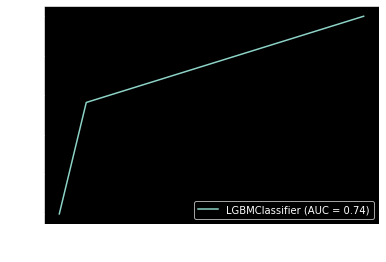

In [ ]:
AucDisp(best_model)

In [ ]:
test_preds = best_model.predict_proba(test[X])

In [ ]:
roc_auc_score(test[y], test_preds[:,1])

0.8532747007224966

<a name = correction6></n>

<a name = correction7></n>

In [ ]:
y_test = (test_preds[:,1] > 0.5).astype('int')

In [ ]:
test_accuracy = accuracy_score(test[y], y_test)
print (f'''Аккураси на тестовой выборке: {test_accuracy}''' )

Аккураси на тестовой выборке: 0.7932992617830777


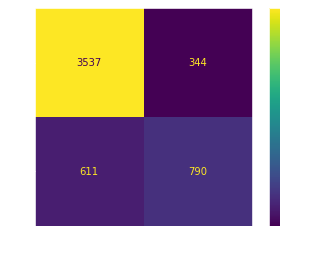

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(best_model)

Видим что первый класс модель так и не предсказывает адекватно

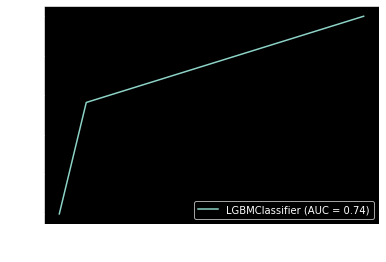

In [ ]:
AucDisp(best_model)

На тестовой выборке метрика roc_auc достигла требуемых показтелей > 0.85

In [ ]:
# отобразим
precision, recall, _ = precision_recall_curve(test[y], y_test)

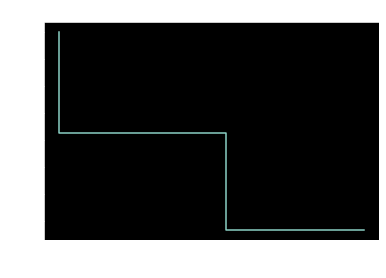

In [ ]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision Recall')
plt.show()

Несмотря на высокую метрику roc auc score мы видим, что предсказания модели несбалансированы, имеется  перекос  в сторону precision (0.65) в то время как   recall чуть лучше случайной модели - 0.519.

Считаю, что данную модель использовать в бизнесе нельзя, она бесполезна

## Вывод

В результате проведенного исследования мной была проделана следующая работа и достигнуты результаты:
- Загружены данные из базы данных left join, по колонке user_id.
В результате объединения датасет содерждал 7053 объектов и 19 признаков.
Названия признаков были перезаписаны в snake_case (изначально были в camel case).
-Анализ и предобработка выявили что в данных в признаках total_charges данные для новых клиентов обратились в Nan, поэтому я заменила эти пропуски значением 0. Так же имелись пропущенные значения в признаке end date. В этом признаке я пропуски не заполняла, а создала новый признак churn, который являлся целевым в моем исследовании, и значения с пропусками соответствовали объектам с 0, т.е. те у кого в графе end_date не было значения.
Далее было выявлено, что почти все признаки это булев тип, но записаны категориями, поэтому я заменила все признаки содержащие 2 уникальные категории на 0 и 1. После этого в данных осталось всего 2 признака, который являлся категориальным type, payment_method
- В данных отсутствуют аномальные значения, дупликаты.
- На основе признаков begin_date и end date был создан признак client_period, а исходные признаки были удалены чтобы избежать утечку данных.

**Машинное обучение**
Для того, чтобы передать наши данные в модели мл, я провела следующую подготовку:
- разделила выборку на train и test (70/25).
- перекодировала признаки type, payment_method. Кодировала с помощью среднего значения целевого признака для каждого уникального значения в признаке.
- масштабировала признаки с помощью standard_scaler (хотя можно было и не делать, но иначе мы не смогли бы исопльзовать нейронную сеть)

В результате мной были получены следующие результаты:

|model |roc_auc_score|
|----|-----|
| RandomForest(basic)| 0.8293  
|RandomForest(grid_search)| 0.8408
|CatBoost(basic)|0.8377
|Catboost(Optuna)|0.8356
|LightGBM(basic)|0.8259
|LightGBM(Optuna)|0.8443
|Neural Net with dropout|0.8377

Для всех моделей подбирались гиперпараметры (кроме нейросети). Способ подбора гиперпараметров указан в скобках. Таким образом, лучший результат был достигнут моделью LightGBM, использующий gradient descent алгоритм.

Далее мной была предпринята попытка создать новые признаки на основе самых важных для моделей и были созданы 3 новых признака:
- total_services: сумма всех услуг клиента
- mean_monthly_spending: средниие траты в месяц
- service_per_period: сколько сервисом клиент оформил за период
 На этих данных модель показала аналогичный результат - . Поэтому использовать новые признаки не имеет смысла.

 Итоговое тестирование модели на test выборке было проведено моделью lightGbm c параметрами
- 'num_leaves': 203,
-  'learning_rate': 0.07363008988636893,
-  'boosting_type': 'gbdt',
-  'lambda_l1': 7.119095487843003,
-  'lambda_l2': 9.525521905551784,
-  'bagging_fraction': 0.4494637058926308,
-  'bagging_freq': 4,
-  'min_child_samples': 89.

На тестовой выборке метрика roc_auc достигла требуемых показтелей > 0.85, но несмотря на это предсказания модели несбалансированы, имеется перекос в сторону precision (0.65) в то время как recall чуть лучше случайной модели - 0.519.

Считаю, что данную модель использовать в бизнесе нельзя, она бесполезна из-за того, что не находит позитивный класс
